In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp

In [2]:
# import cpp lib for spectrum calculation and initialize argtypes for functions in it

lib = ctypes.CDLL("./getspec_dip.dll", winmode=0)

c_floating = ctypes.c_double;

class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_int
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating, ctypes.c_bool,
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [3]:
Npow = 16; 
L = 2**Npow;  # number of examined dots

# initialize arrays
twist = lib.reserve_twists(Npow)
bitrev = lib.reserve_bitrev(Npow)
Ex = lib.reserve_complex_array(L)
Ey = lib.reserve_complex_array(L)
tmpEx = lib.reserve_complex_array(L)
tmpEy = lib.reserve_complex_array(L)
specx = lib.reserve_array(L)
specy = lib.reserve_array(L)

In [4]:
alpha = 4.;
kappa = 300.;
gamma_d = 1500.;
gamma_a =  1.72;
gamma_p = 2*np.pi*30;
beta = 0.2;
mu = 7.;

C_sp = 5e-5;
N_th = 6.25e6;
N_th = 1
N_tr = 5.935e6;
N_tr = 0.95*N_th
N_rel = N_tr / N_th

Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 3;

tauDt = round(np.floor(tau/Dt));
if tauDt < 1:
    tauDt = 1
tau = tauDt * Dt;  # fix tau in order to make it right value

skip = round(offset * L);  # how many dots will be skipped by offset

freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)
fstep = freqs[1]-freqs[0]

In [116]:
from matplotlib.ticker import MultipleLocator, LogLocator, AutoMinorLocator

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage[english,russian]{babel}'

def plot_specs(freqs, specx, specy, wnd=None, fout=None):
    if wnd is None:
        wnd = np.arange(freqs.shape[0], dtype=np.int32)
    plt.figure(figsize=(8,4.5), dpi=300)
    plt.plot(freqs[wnd], specx[wnd], 'r-', linewidth=0.5, label=r"$S_x$")
    plt.plot(freqs[wnd], specy[wnd], 'b-', linewidth=0.5, label=r"$S_y$")
    plt.legend(loc="upper right")
    ax = plt.gca()
    ax.set_xlabel(r"$f\cdot\tau_e$", loc="right")
    ax.set_ylabel(r"$S$, усл. ед.", loc="top", rotation="horizontal", labelpad=-20.)
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.linspace(1.,10,10), numticks=15))
    plt.grid()
    if fout is None:
        plt.show()
    else:
        plt.savefig(fout)
        
        
def plot_specs_fit(freqs, specx, specy, fdx, spx, fdy, spy, wnd=None, majorx=None, fout=None):
    if wnd is None:
        wnd = np.arange(freqs.shape[0], dtype=np.integer)
        fmin = min(np.min(fdx), np.min(fdy))
        fmax = max(np.max(fdx), np.max(fdy))
        wndmin = int(np.abs(freqs-fmin).argmin())
        wndmax = int(np.abs(freqs-fmax).argmin())
        wnd = np.arange(wndmin, wndmax, dtype=np.integer)
    
    mult = 1 / 0.02 * 299.792458 / (194.95 * 194.95)
    
    plt.figure(figsize=(8,4.5), dpi=300)
    plt.plot(freqs[wnd]/1000, mult*specx[wnd], 'r:', linewidth=0.8, label=r"$S_x$ fit")
    plt.plot(freqs[wnd]/1000, mult*specy[wnd], 'b:', linewidth=0.8, label=r"$S_y$ fit")
    plt.plot(fdx/1000, mult*spx, 'r-', linewidth=1., alpha=0.5, label=r"$S_x$ experiment")
    plt.plot(fdy/1000, mult*spy, 'b-', linewidth=1., alpha=0.5, label=r"$S_y$ experiment")
    plt.legend(loc="upper right")
    ax = plt.gca()
    ax.set_xlabel(r"$f$, ТГц", loc="right")
    ax.set_ylabel(r"$S$, мВт/ГГц", loc="top", rotation="horizontal", labelpad=-20.)
    ax.set_yscale("log")
    if majorx is None:
        ax.xaxis.set_major_locator(MultipleLocator(10/1000))
        ax.xaxis.set_minor_locator(MultipleLocator(2/1000))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(majorx/1000))
        ax.xaxis.set_minor_locator(MultipleLocator(majorx/1000/5))
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.linspace(1.,10,10), numticks=15))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.grid()
    if fout is None:
        plt.show()
    else:
        plt.savefig(fout)
        
        
def plot_trains(time, Ex, Ey, wnd=None, fout=None):
    if wnd is None:
        wnd = np.arange(time.shape[0])
    plt.figure(figsize=(8,4.5), dpi=300)
    #if np.max(Ex) > np.max(Ey):
    #    plt.plot(time[wnd], Ex[wnd], 'r-', linewidth=0.5, label=r"$E_x$")
    #    plt.plot(time[wnd], Ey[wnd], 'b-', linewidth=0.5, label=r"$E_y$")
    #else:
    #    plt.plot(time[wnd], Ey[wnd], 'b-', linewidth=0.5, label=r"$E_y$")
    #    plt.plot(time[wnd], Ex[wnd], 'r-', linewidth=0.5, label=r"$E_x$")
    
    plt.plot(time[wnd], Ex[wnd], 'r-', linewidth=0.5, label=r"$E_x$")
    plt.plot(time[wnd], Ey[wnd], 'b-', linewidth=0.5, label=r"$E_y$")
    
    plt.legend(loc="upper right")
    ax = plt.gca()
    ax.set_xlabel(r"$t/\tau_e$", loc="right")
    ax.set_ylabel(r"$E$, усл. ед.", loc="top", rotation="horizontal", labelpad=-20.)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    #ax.yaxis.set_minor_locator(LogLocator(base=10, subs=[1.1, 1.2, 1.3]))
    plt.grid()
    if fout is None:
        plt.show()
    else:
        plt.savefig(fout)

In [35]:
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_example = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 
Nav = 10

In [36]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt, False,
            *params_example);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 5.73 s


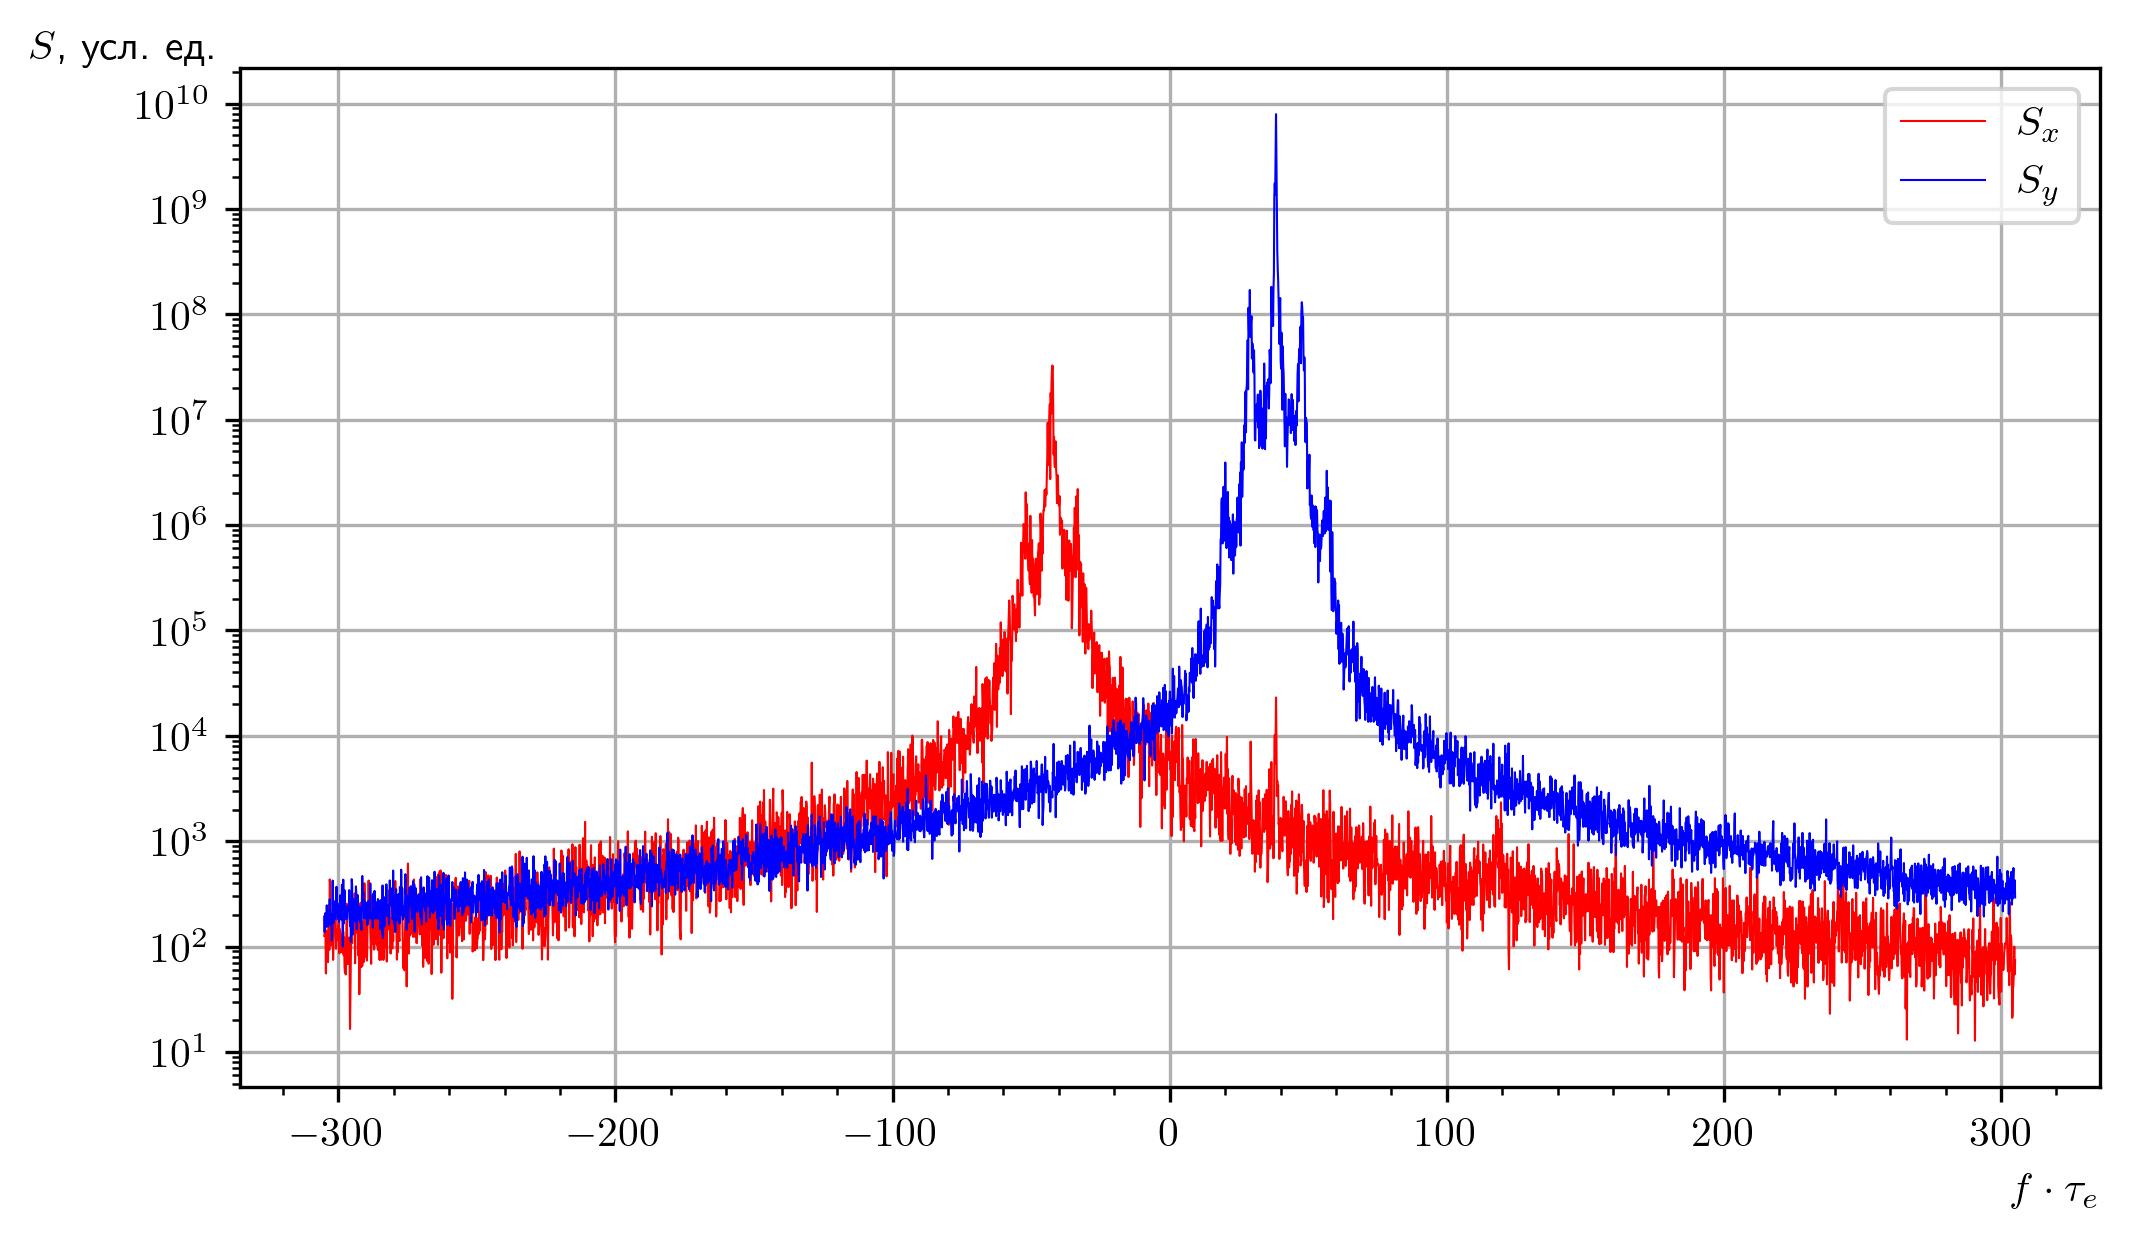

In [37]:
# plt.figure(figsize=(16,9), dpi=120)
WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, "include_in_dip/example.pdf")

In [18]:
data = np.loadtxt("SDEsolution_exmpl.txt")
Ep = np.sqrt(data[:, 0]) * np.exp(1j*(data[:,2] + data[:,3]))
Em = np.sqrt(data[:, 1]) * np.exp(1j*(data[:,2] - data[:,3]))
EEx = (Ep + Em) / np.sqrt(2)
EEy = (Ep - Em) / np.sqrt(2) / 1j
time = np.arange(EEx.shape[0])*tau

In [27]:
smpl = np.arange(int(0.2*EEx.shape[0]), int(0.3*EEx.shape[0]), 10)

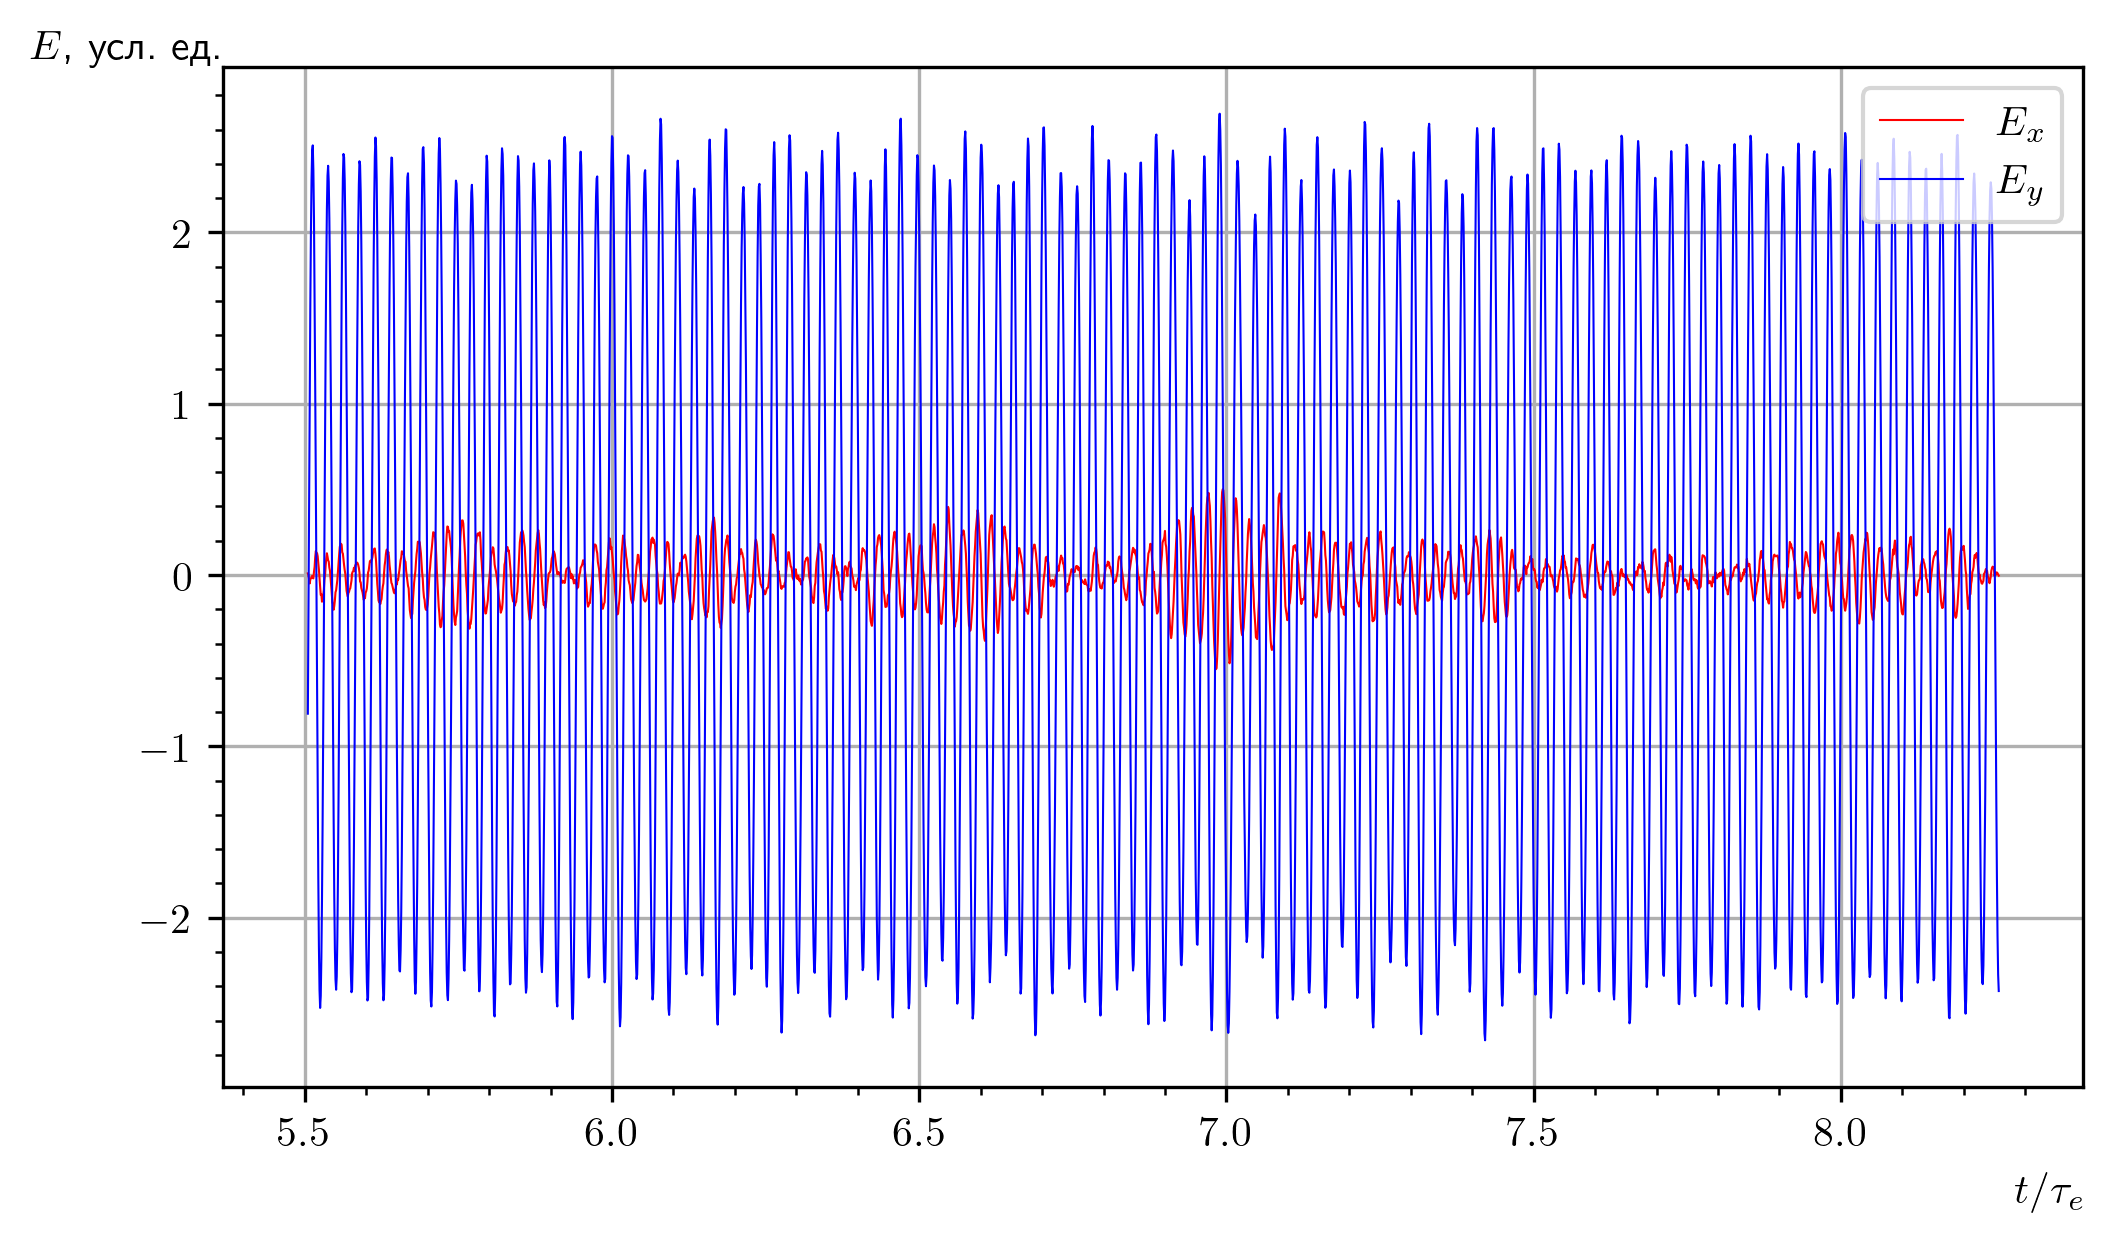

In [28]:
plot_trains(time, np.real(EEx), np.real(EEy), smpl, "include_in_dip/example_train.pdf")

In [29]:
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_example = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 20., 5e-5, 0.95] 
Nav = 10

In [30]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
            *params_example);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 5.58 s


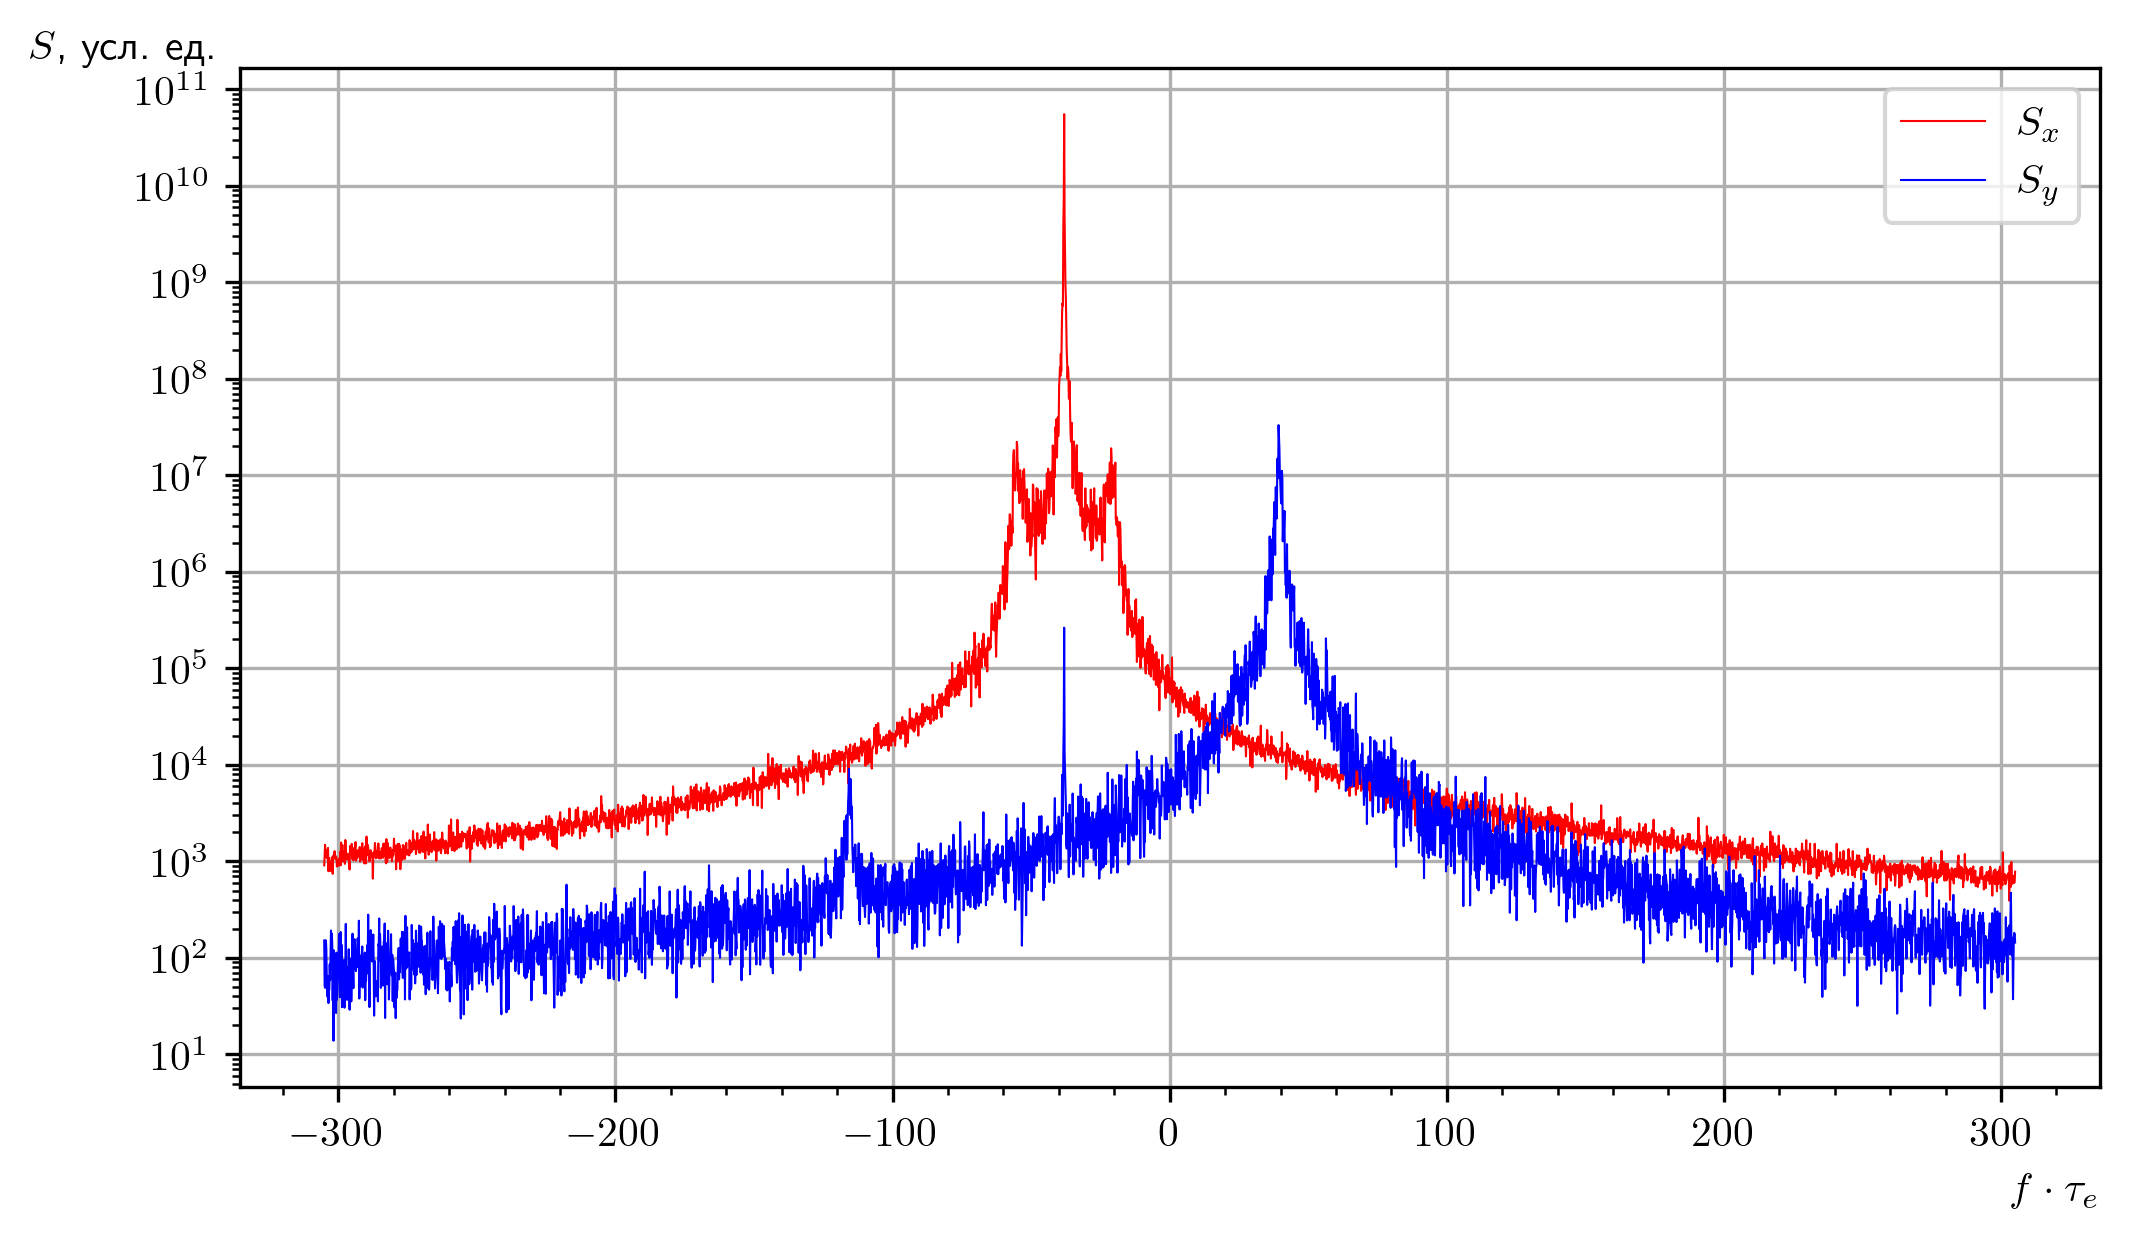

In [31]:
# plt.figure(figsize=(16,9), dpi=120)
WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, 'include_in_dip/example2.pdf')

In [32]:
data2 = np.loadtxt("SDEsolution_exmpl2.txt")
Ep2 = np.sqrt(data2[:, 0]) * np.exp(1j*(data2[:,2] + data2[:,3]))
Em2 = np.sqrt(data2[:, 1]) * np.exp(1j*(data2[:,2] - data2[:,3]))
EEx2 = (Ep2 + Em2) / np.sqrt(2)
EEy2 = (Ep2 - Em2) / np.sqrt(2) / 1j
time2 = np.arange(EEx2.shape[0])*tau

In [33]:
smpl2 = np.arange(int(0.2*EEx2.shape[0]), int(0.3*EEx2.shape[0]), 10)

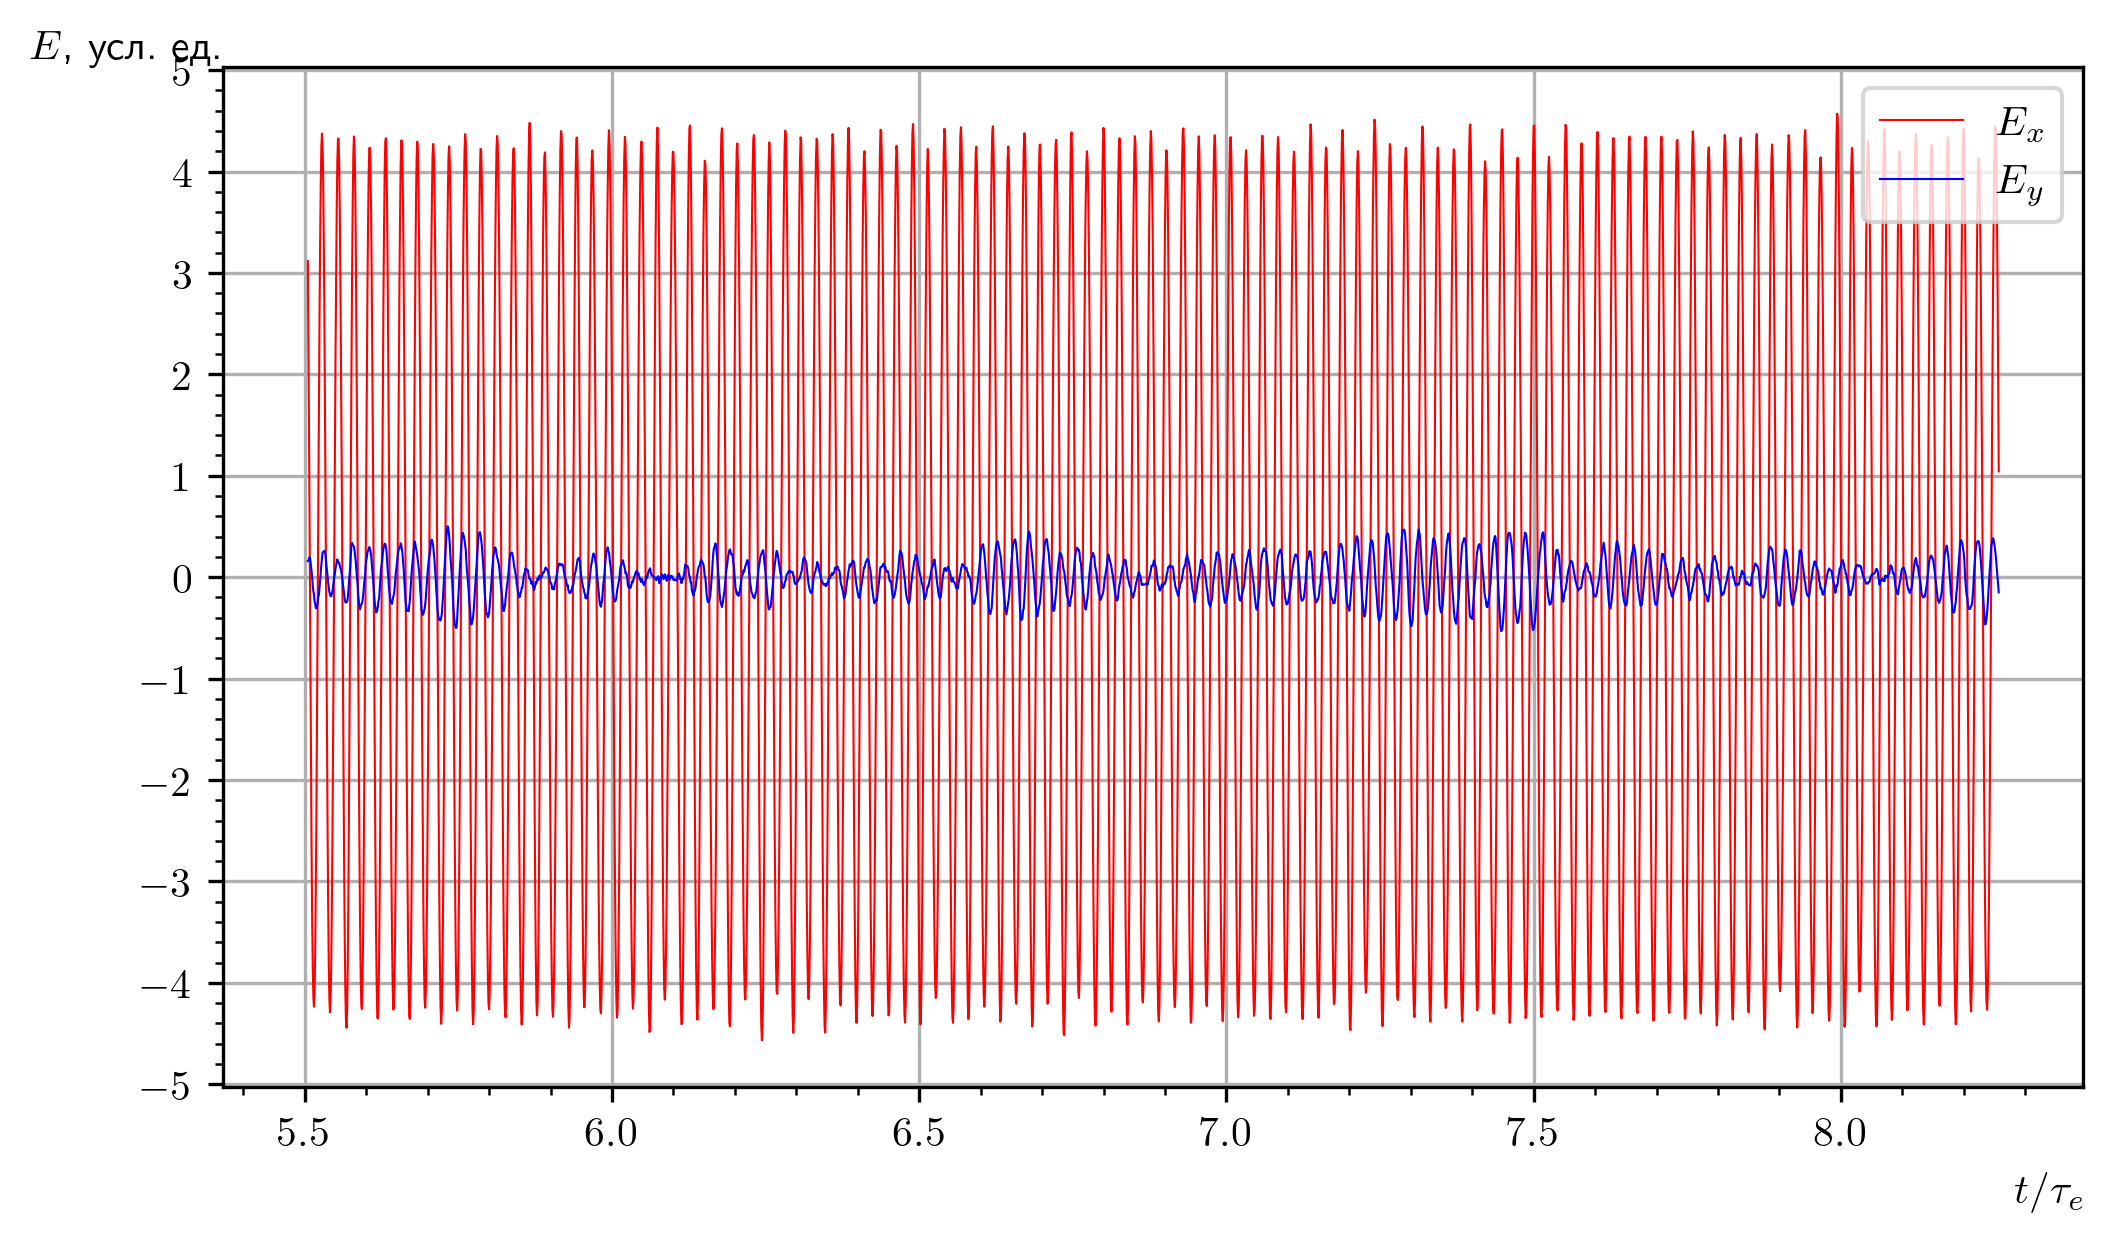

In [34]:
plot_trains(time2, np.real(EEx2), np.real(EEy2), smpl2, "include_in_dip/example2_train.pdf")

In [9]:
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_example = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 
Nav = 1000

In [10]:
%%time
res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
            *params_example);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 6min 4s


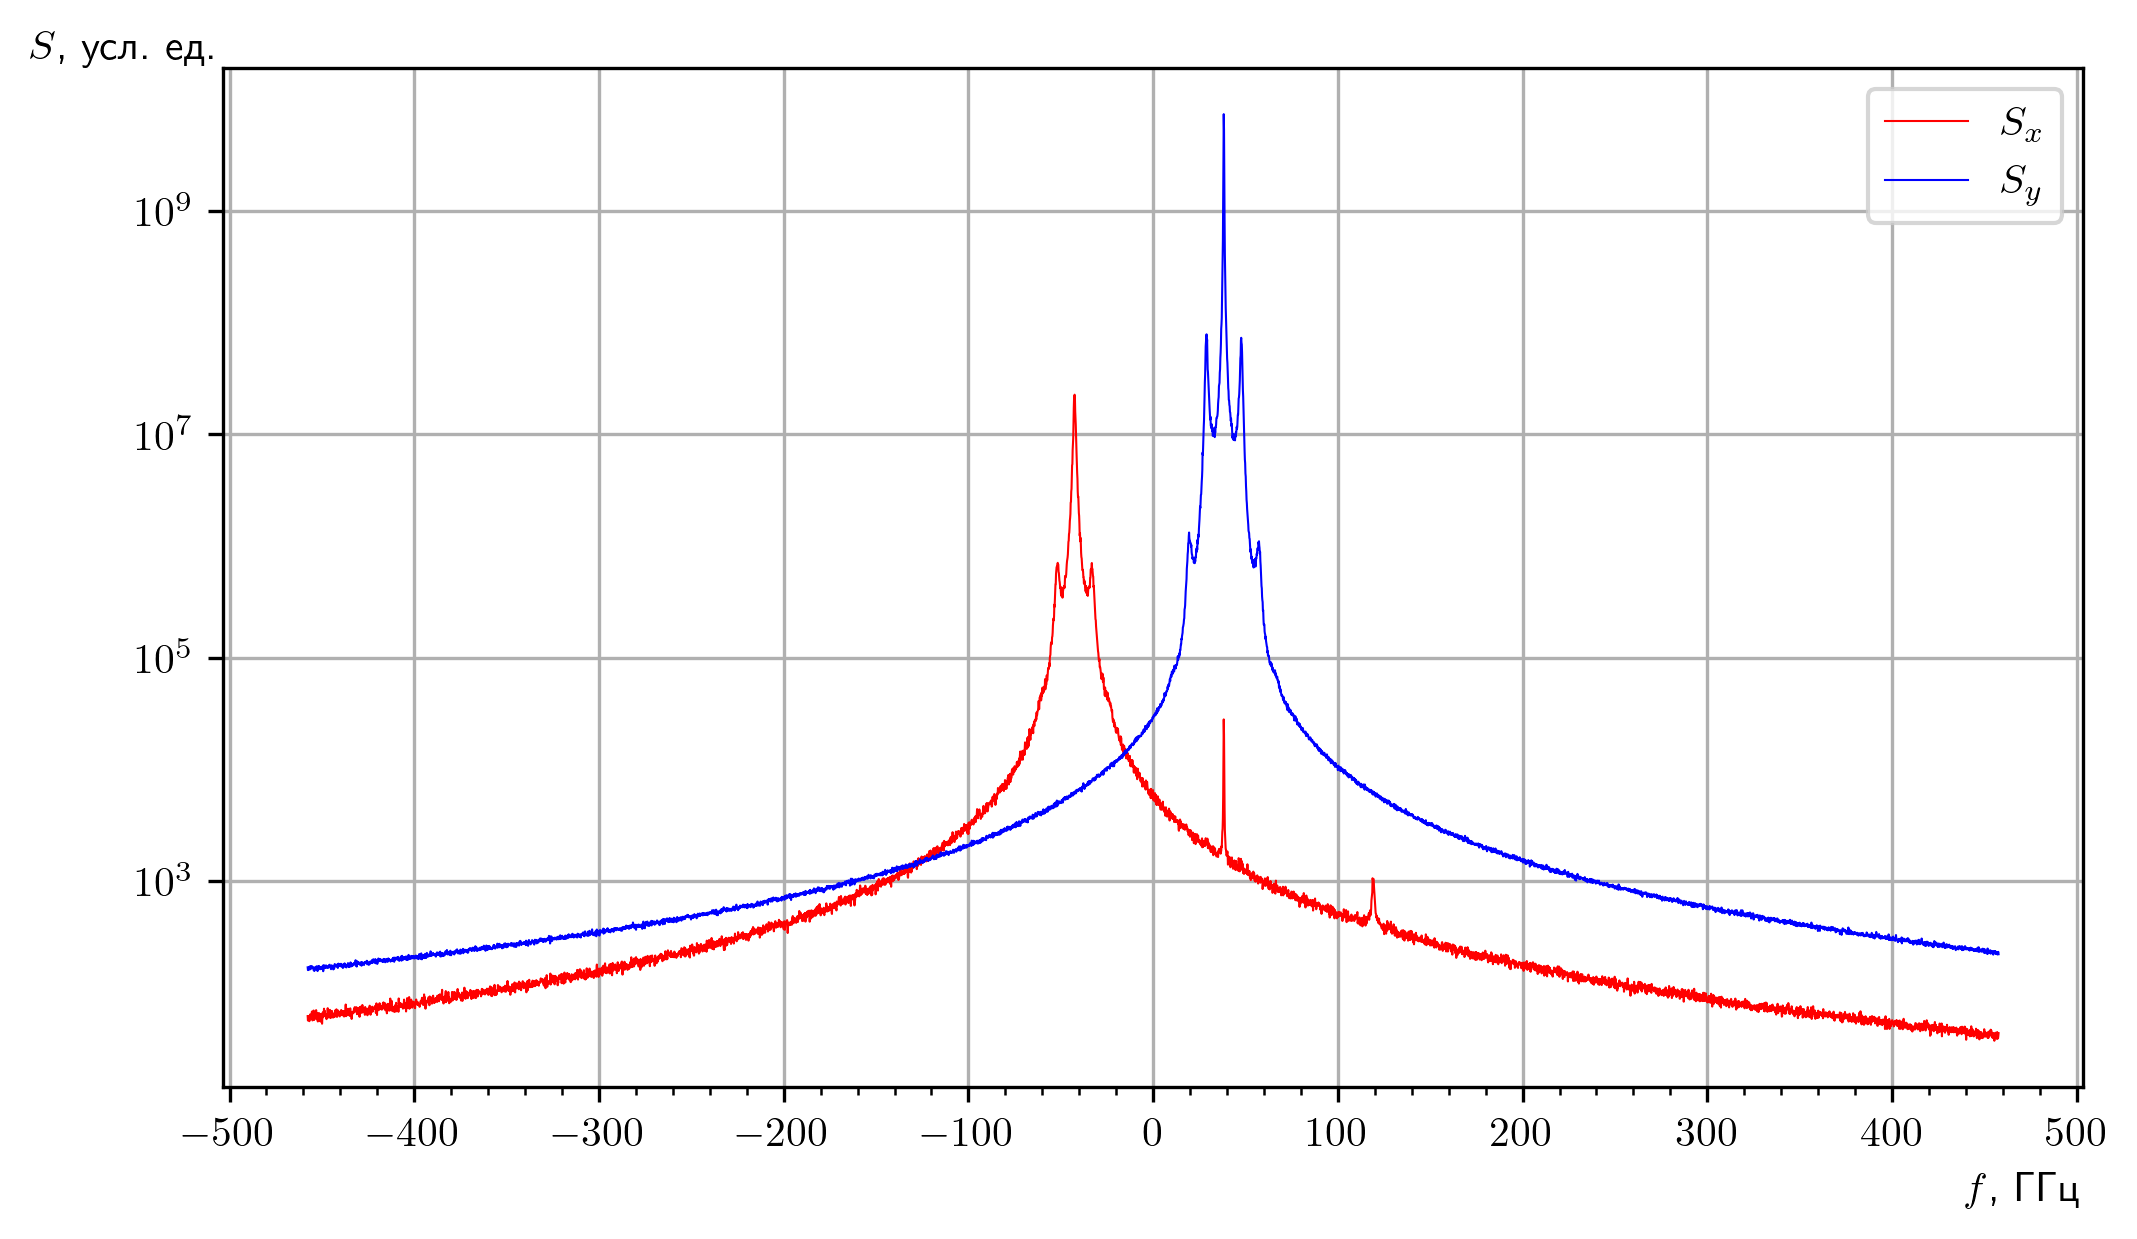

In [11]:
# plt.figure(figsize=(16,9), dpi=120)
WW = 3000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, 'include_in_dip/example_fine.pdf')

In [12]:
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_example = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 20., 5e-5, 0.95] 
Nav = 1000

In [13]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt, False,
            *params_example);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 6min 3s


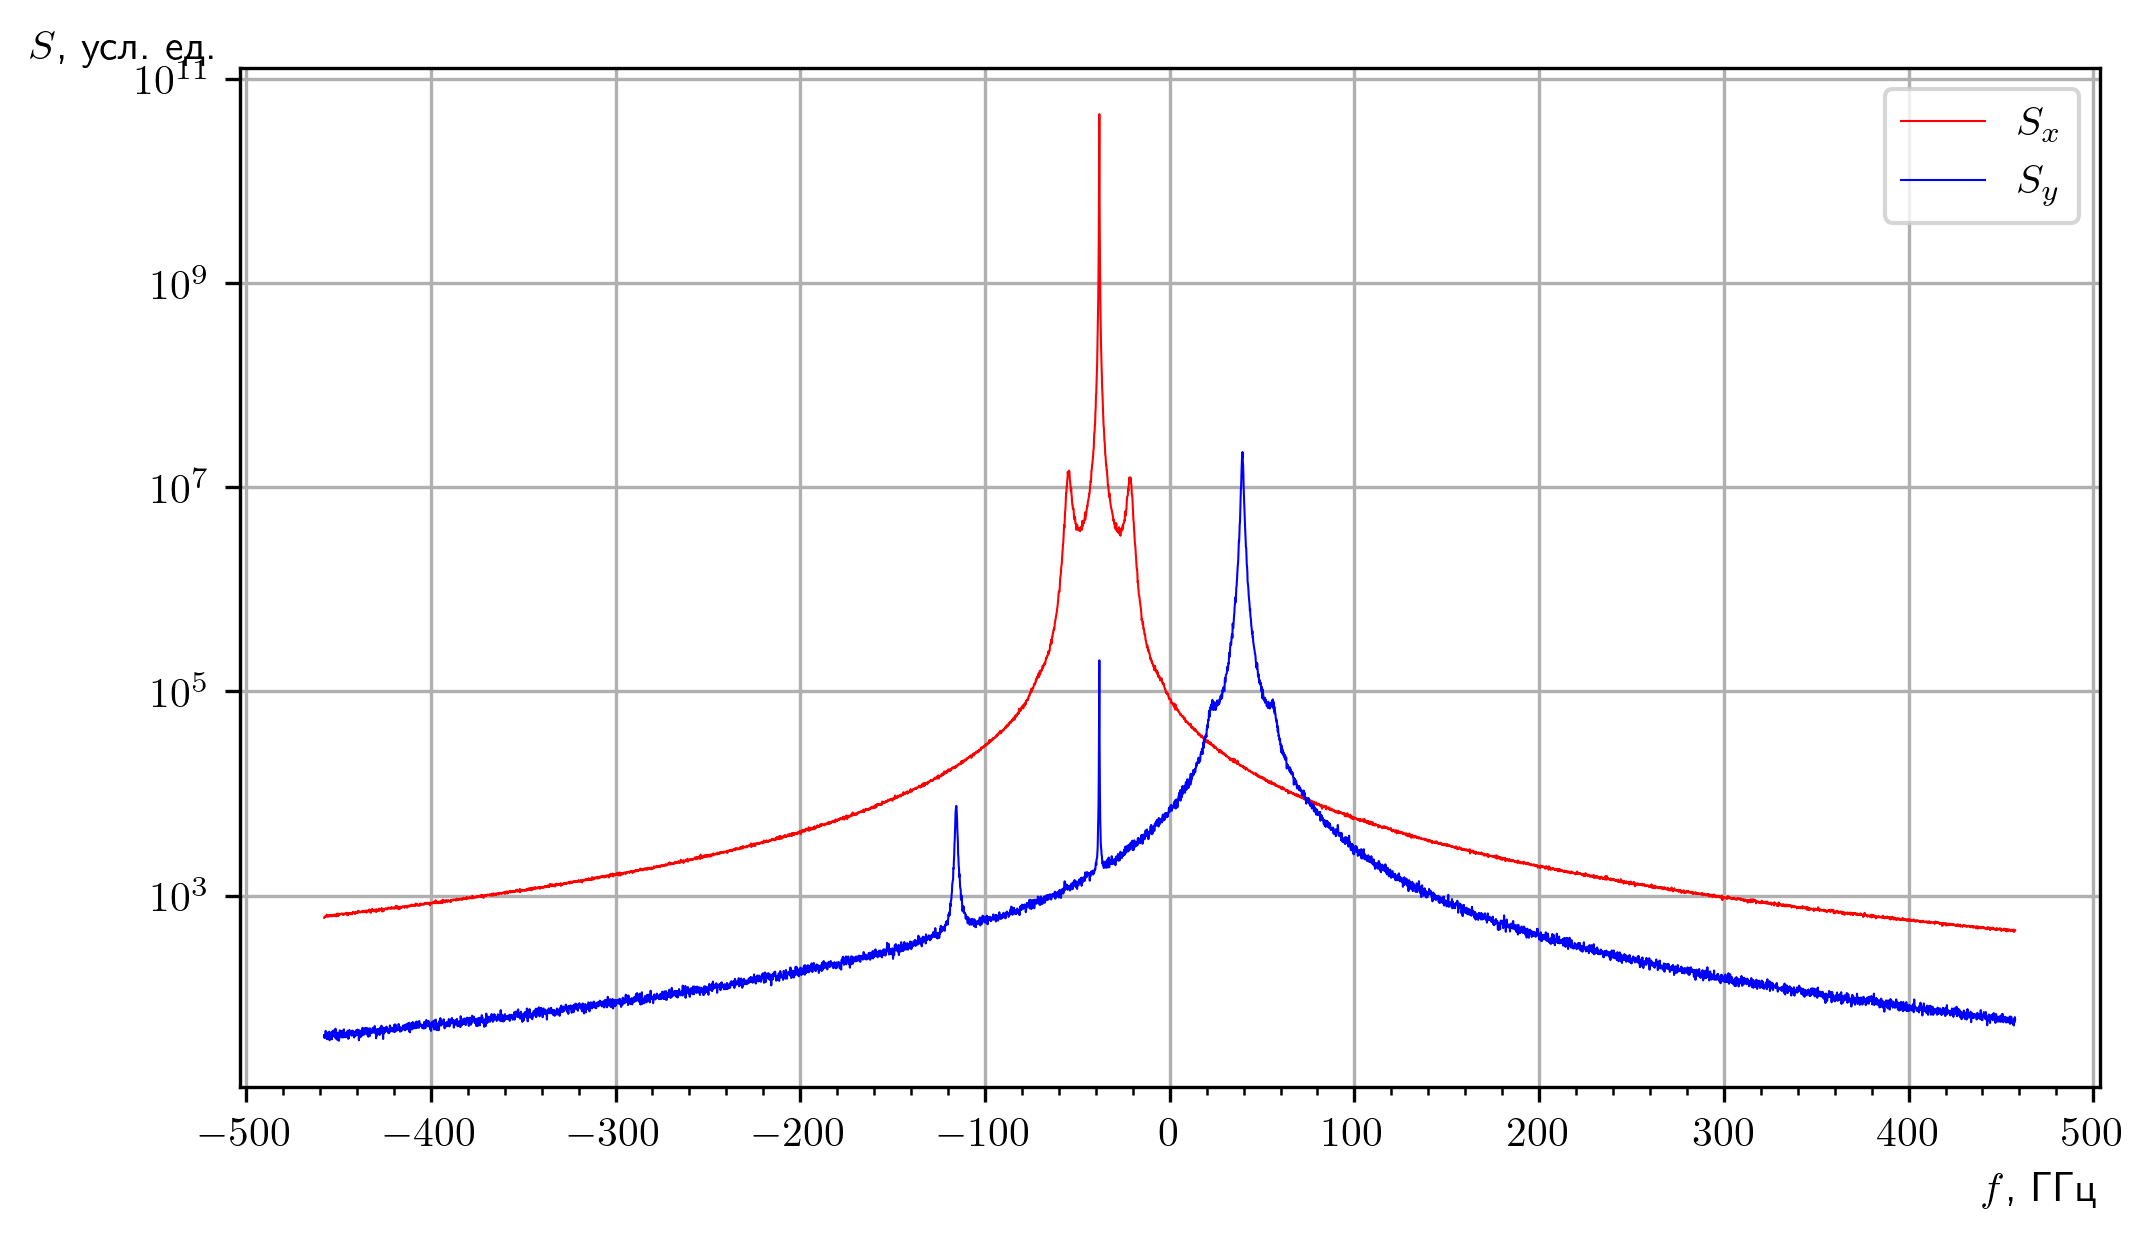

In [14]:
# plt.figure(figsize=(16,9), dpi=120)
WW = 3000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, 'include_in_dip/example2_fine.pdf')

Vary Parameters
--------------------------

In [10]:
Nav = 10000

27
487
0
2970
1008
0
0
0
0
501
2816
663
0
0
924
20
0
0
1277
Wall time: 1h 5min 30s


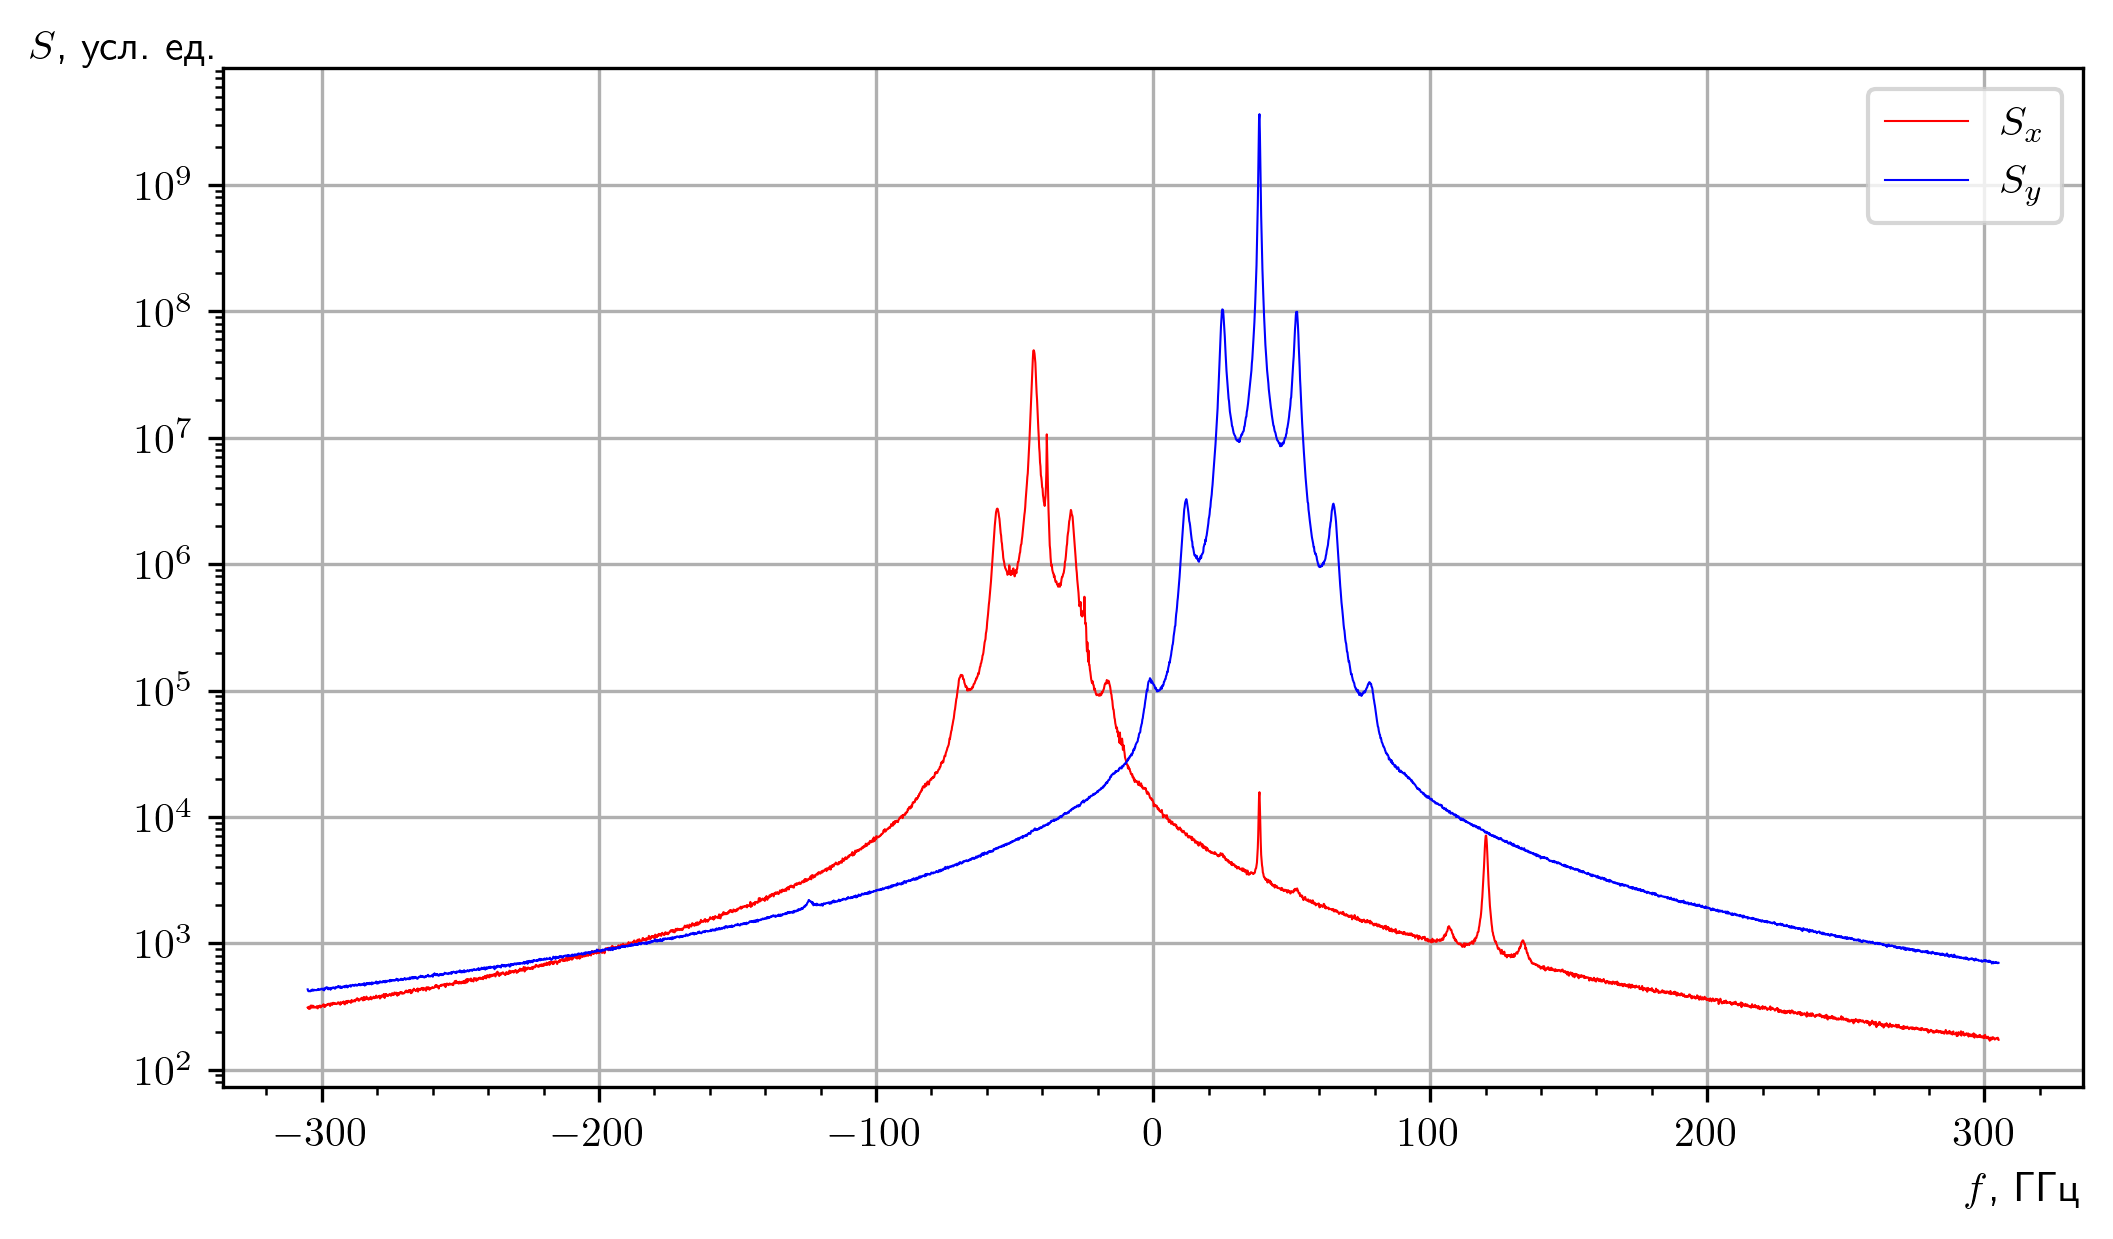

In [11]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 600., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\kappa600_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

1918
1158
1178
549
25
1907
70
4847
Wall time: 1h 7min 46s


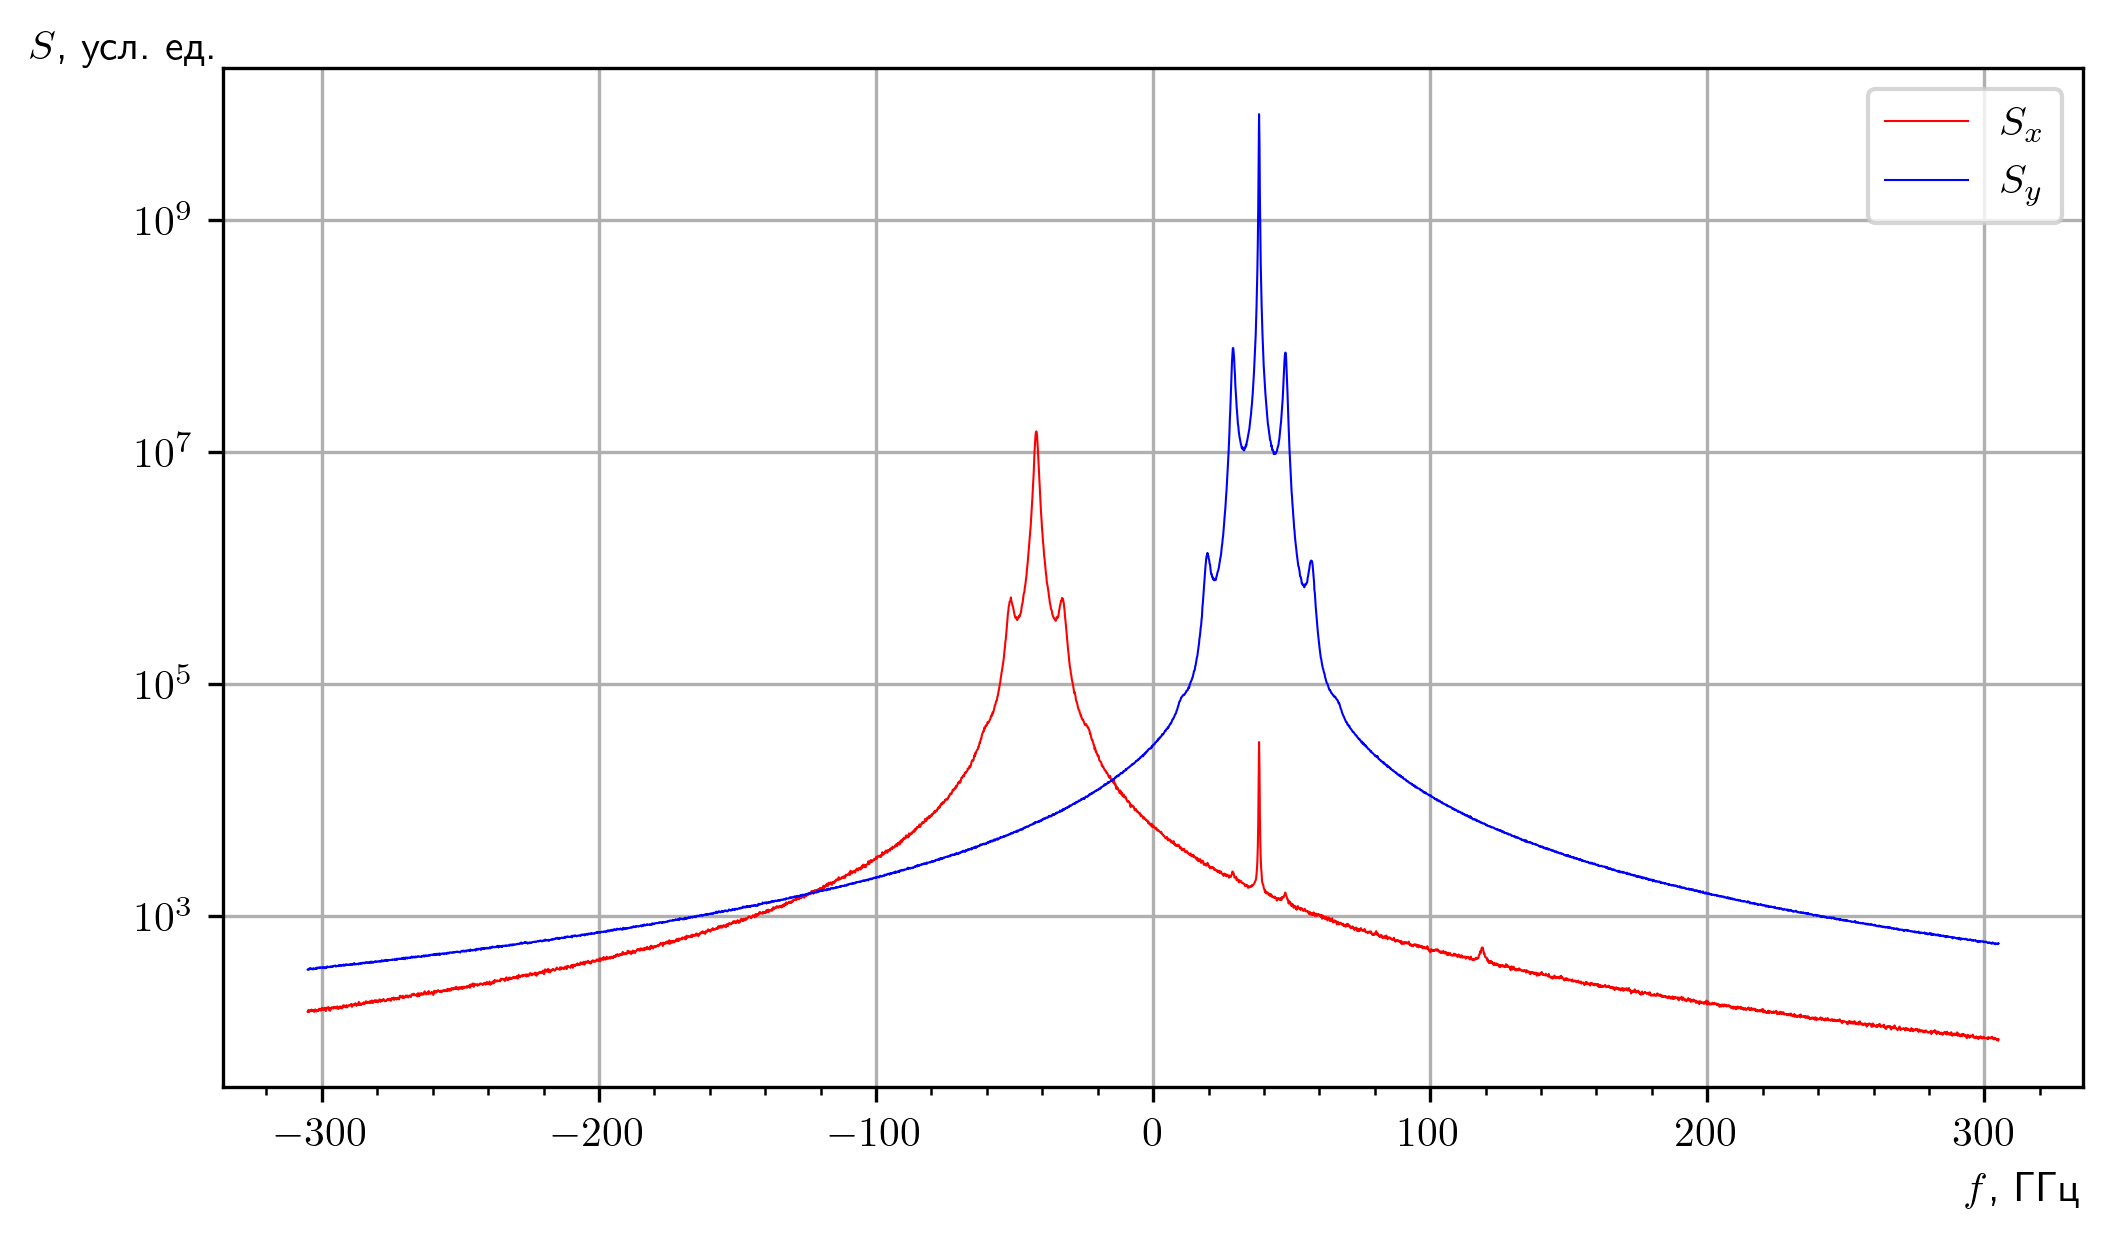

In [12]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 300., 1.0, 3000., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\gammad3000_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

96
4411
4462
1825
Wall time: 1h 2min 26s


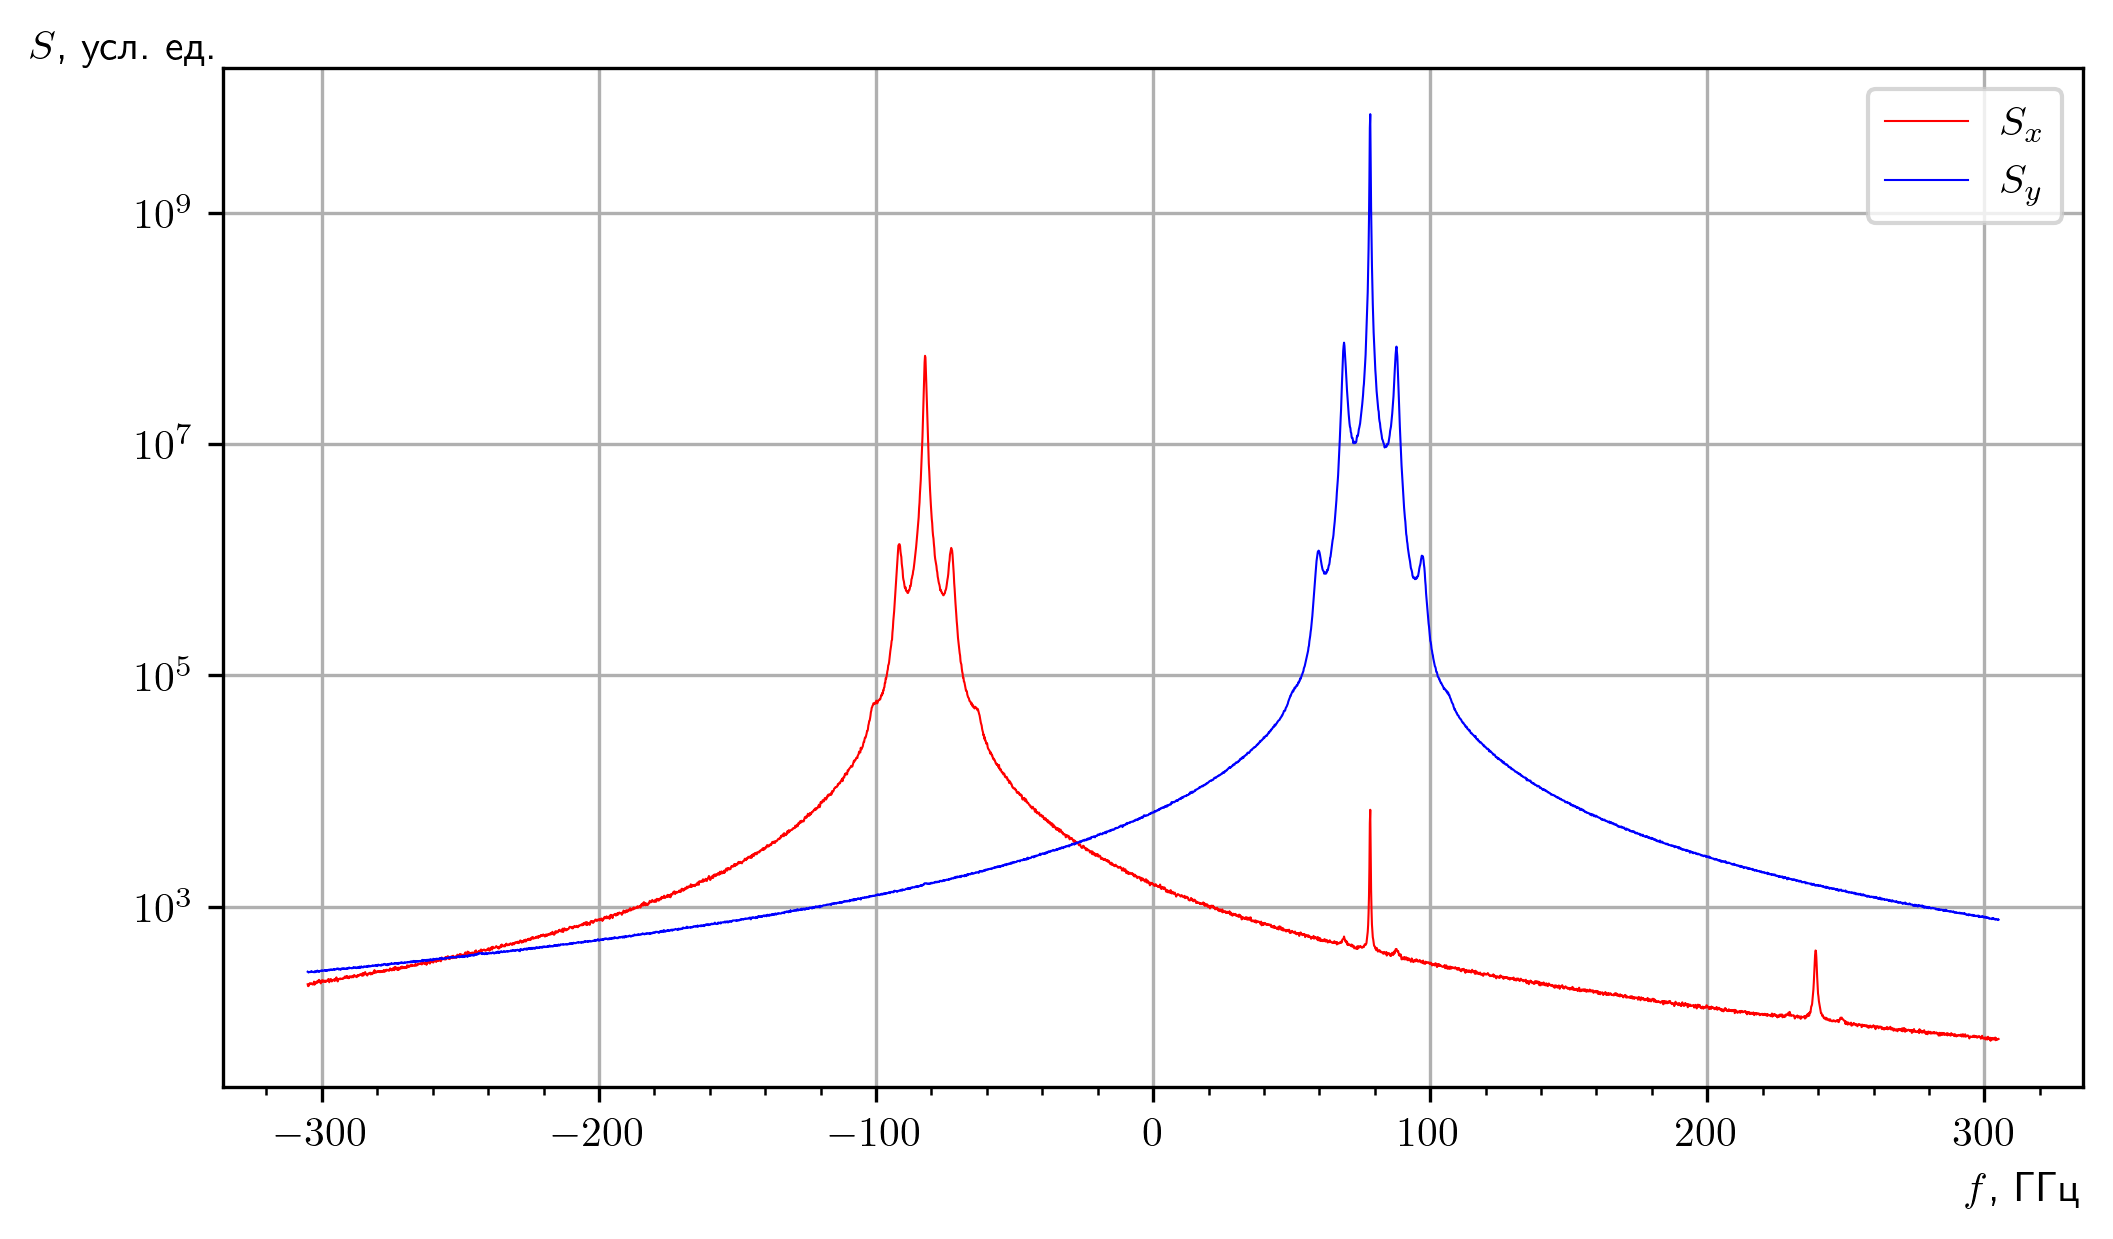

In [13]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 300., 1.0, 1500., 2.5, 2*np.pi*80, 0.2, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\gammap80_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

2252
1350
4788
454
795
7076
Wall time: 1h 36min 59s


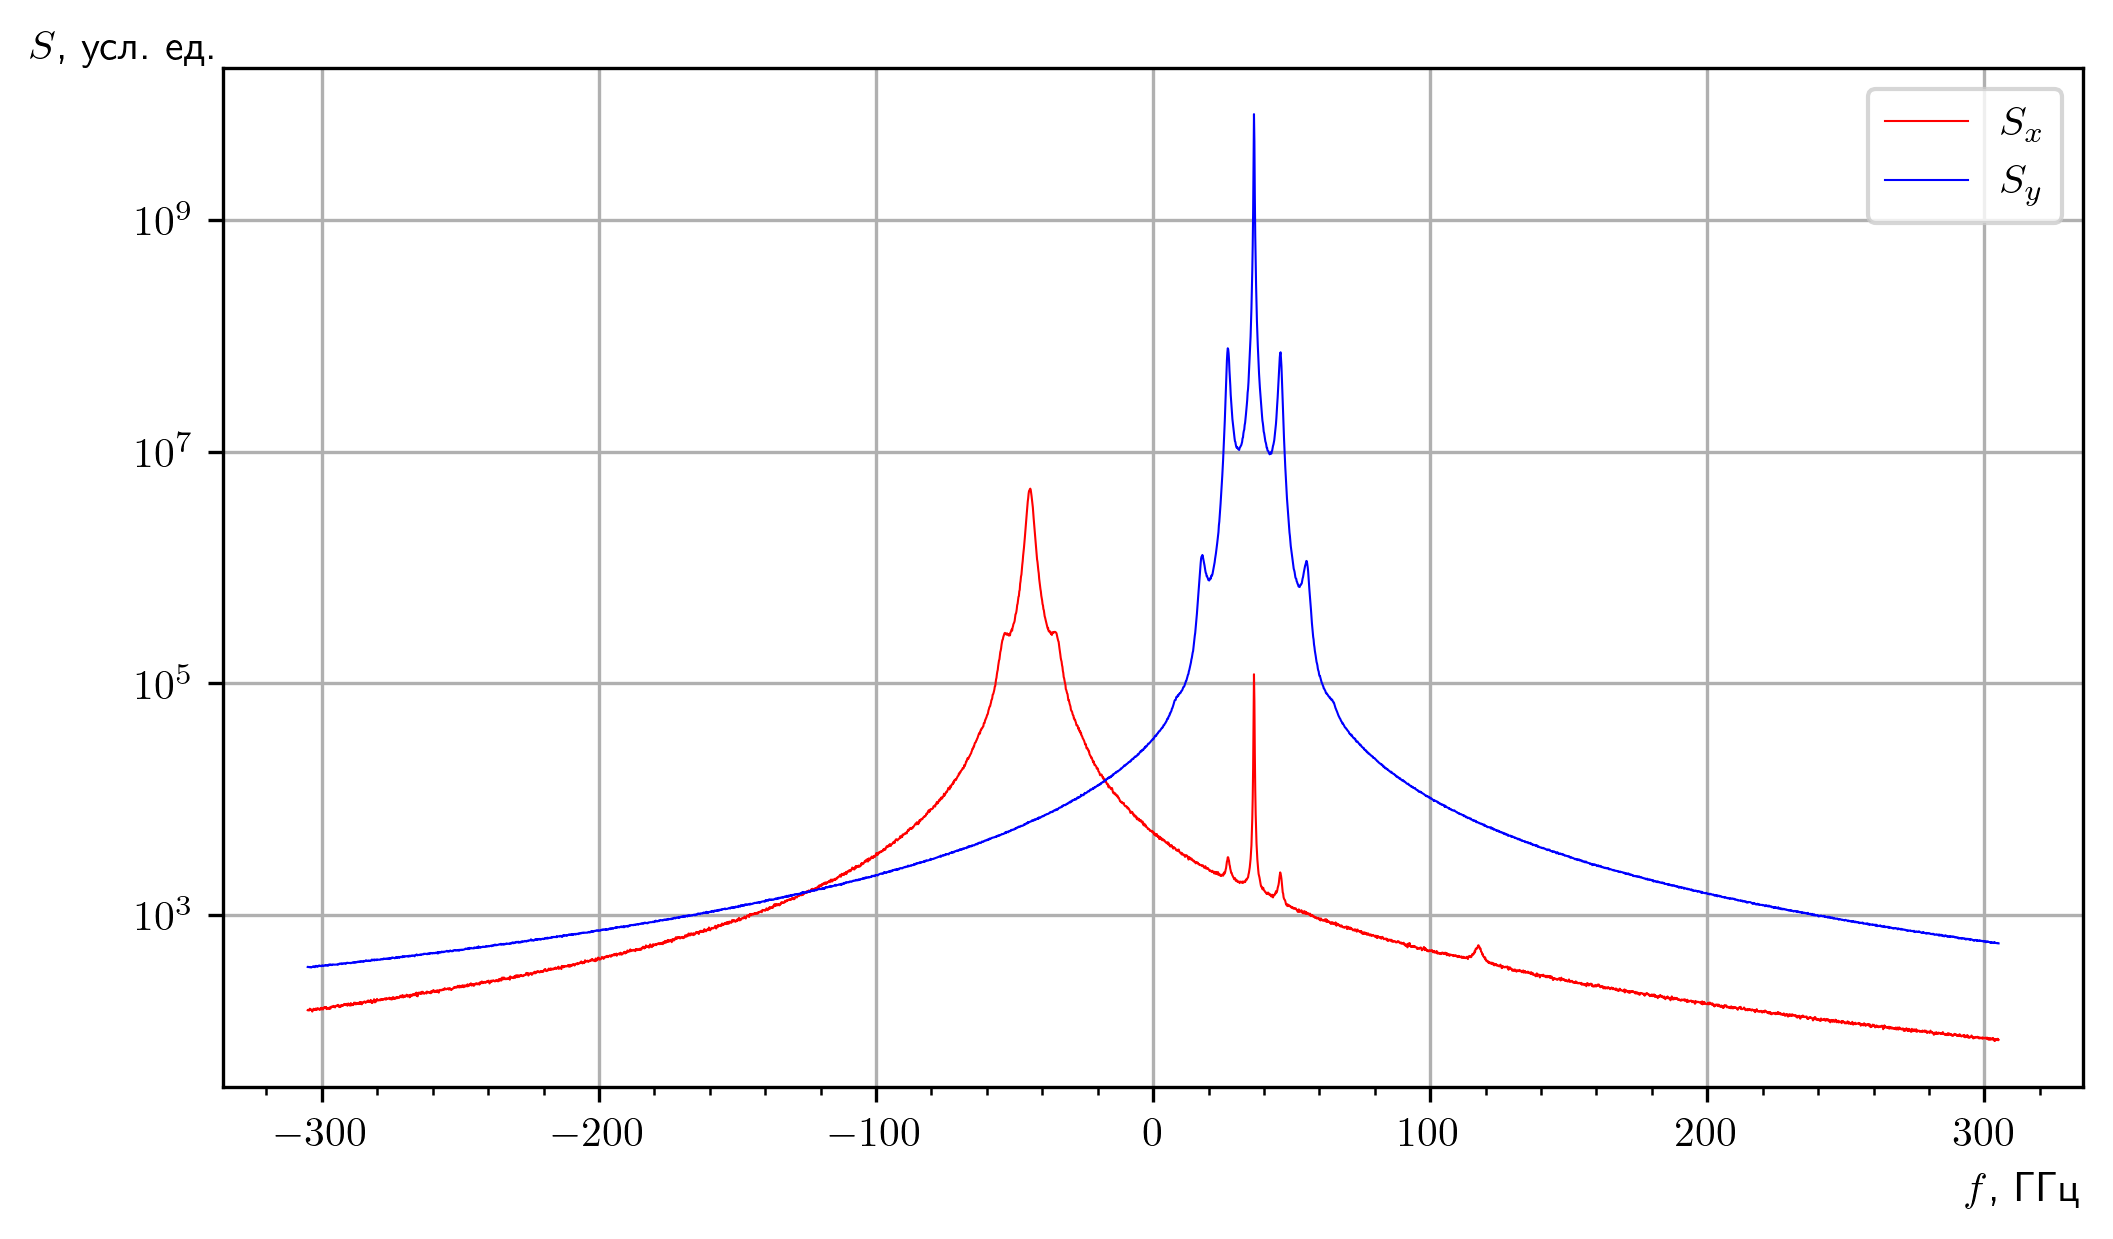

In [14]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 300., 1.0, 1500., 5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\gammaa5_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

466
0
0
198
0
646
0
830
0
1065
0
1526
0
885
0
442
2158
613
707
2685
Wall time: 1h 12min 36s


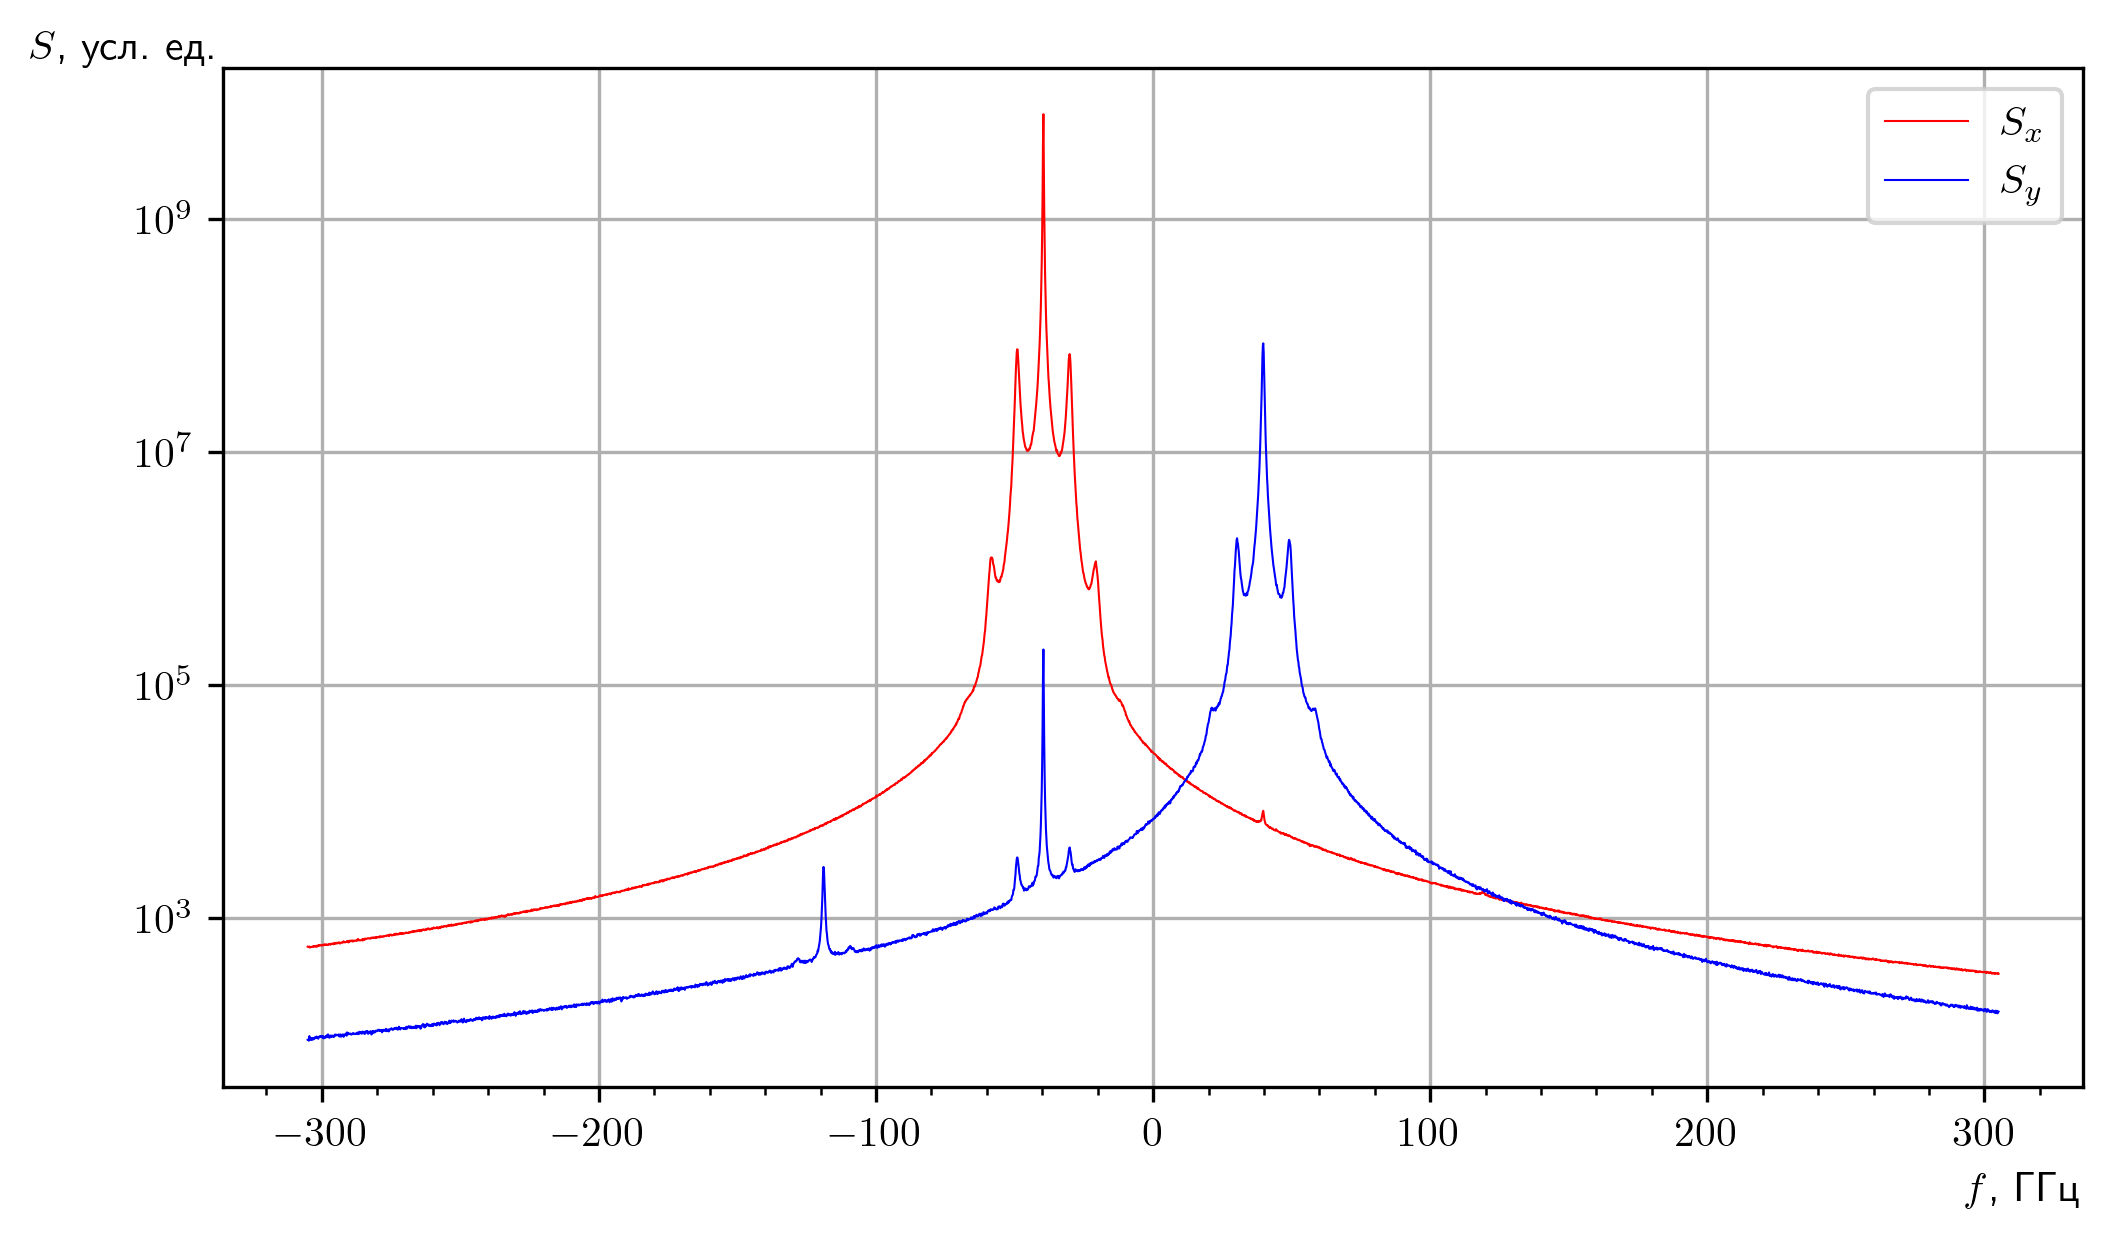

In [15]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.7, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\beta07_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

1951
981
105
1836
390
676
509
494
161
4471
Wall time: 1h 7min 4s


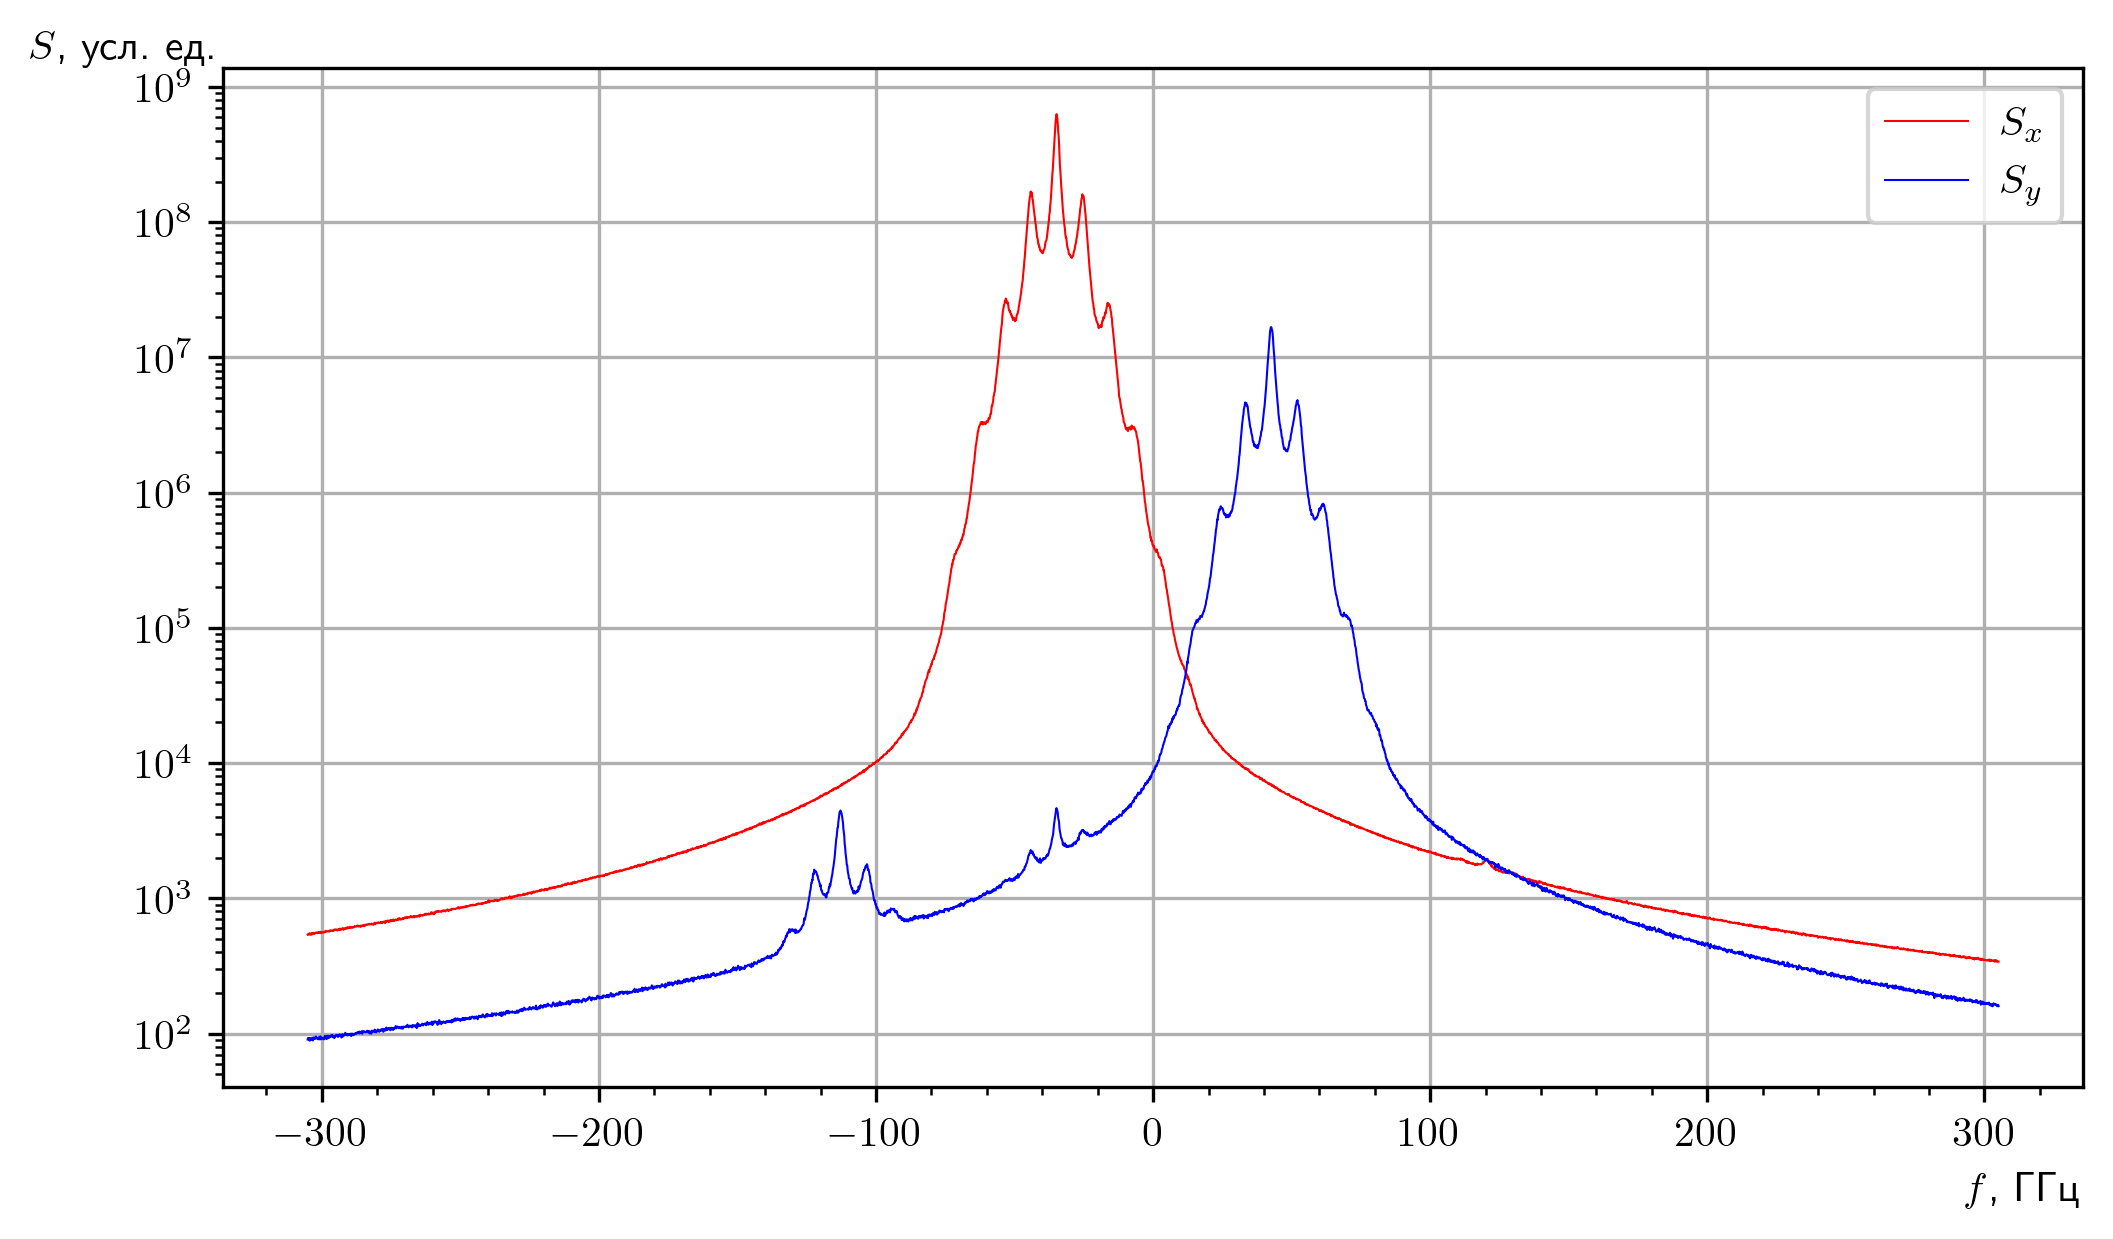

In [16]:
%%time
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [15., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)


filename = r'include_in_dip\alpha15_fine'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

In [17]:
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_example1 = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 7., 5e-5, 0.95] 

5321
957
6954
Wall time: 1h 16min 37s


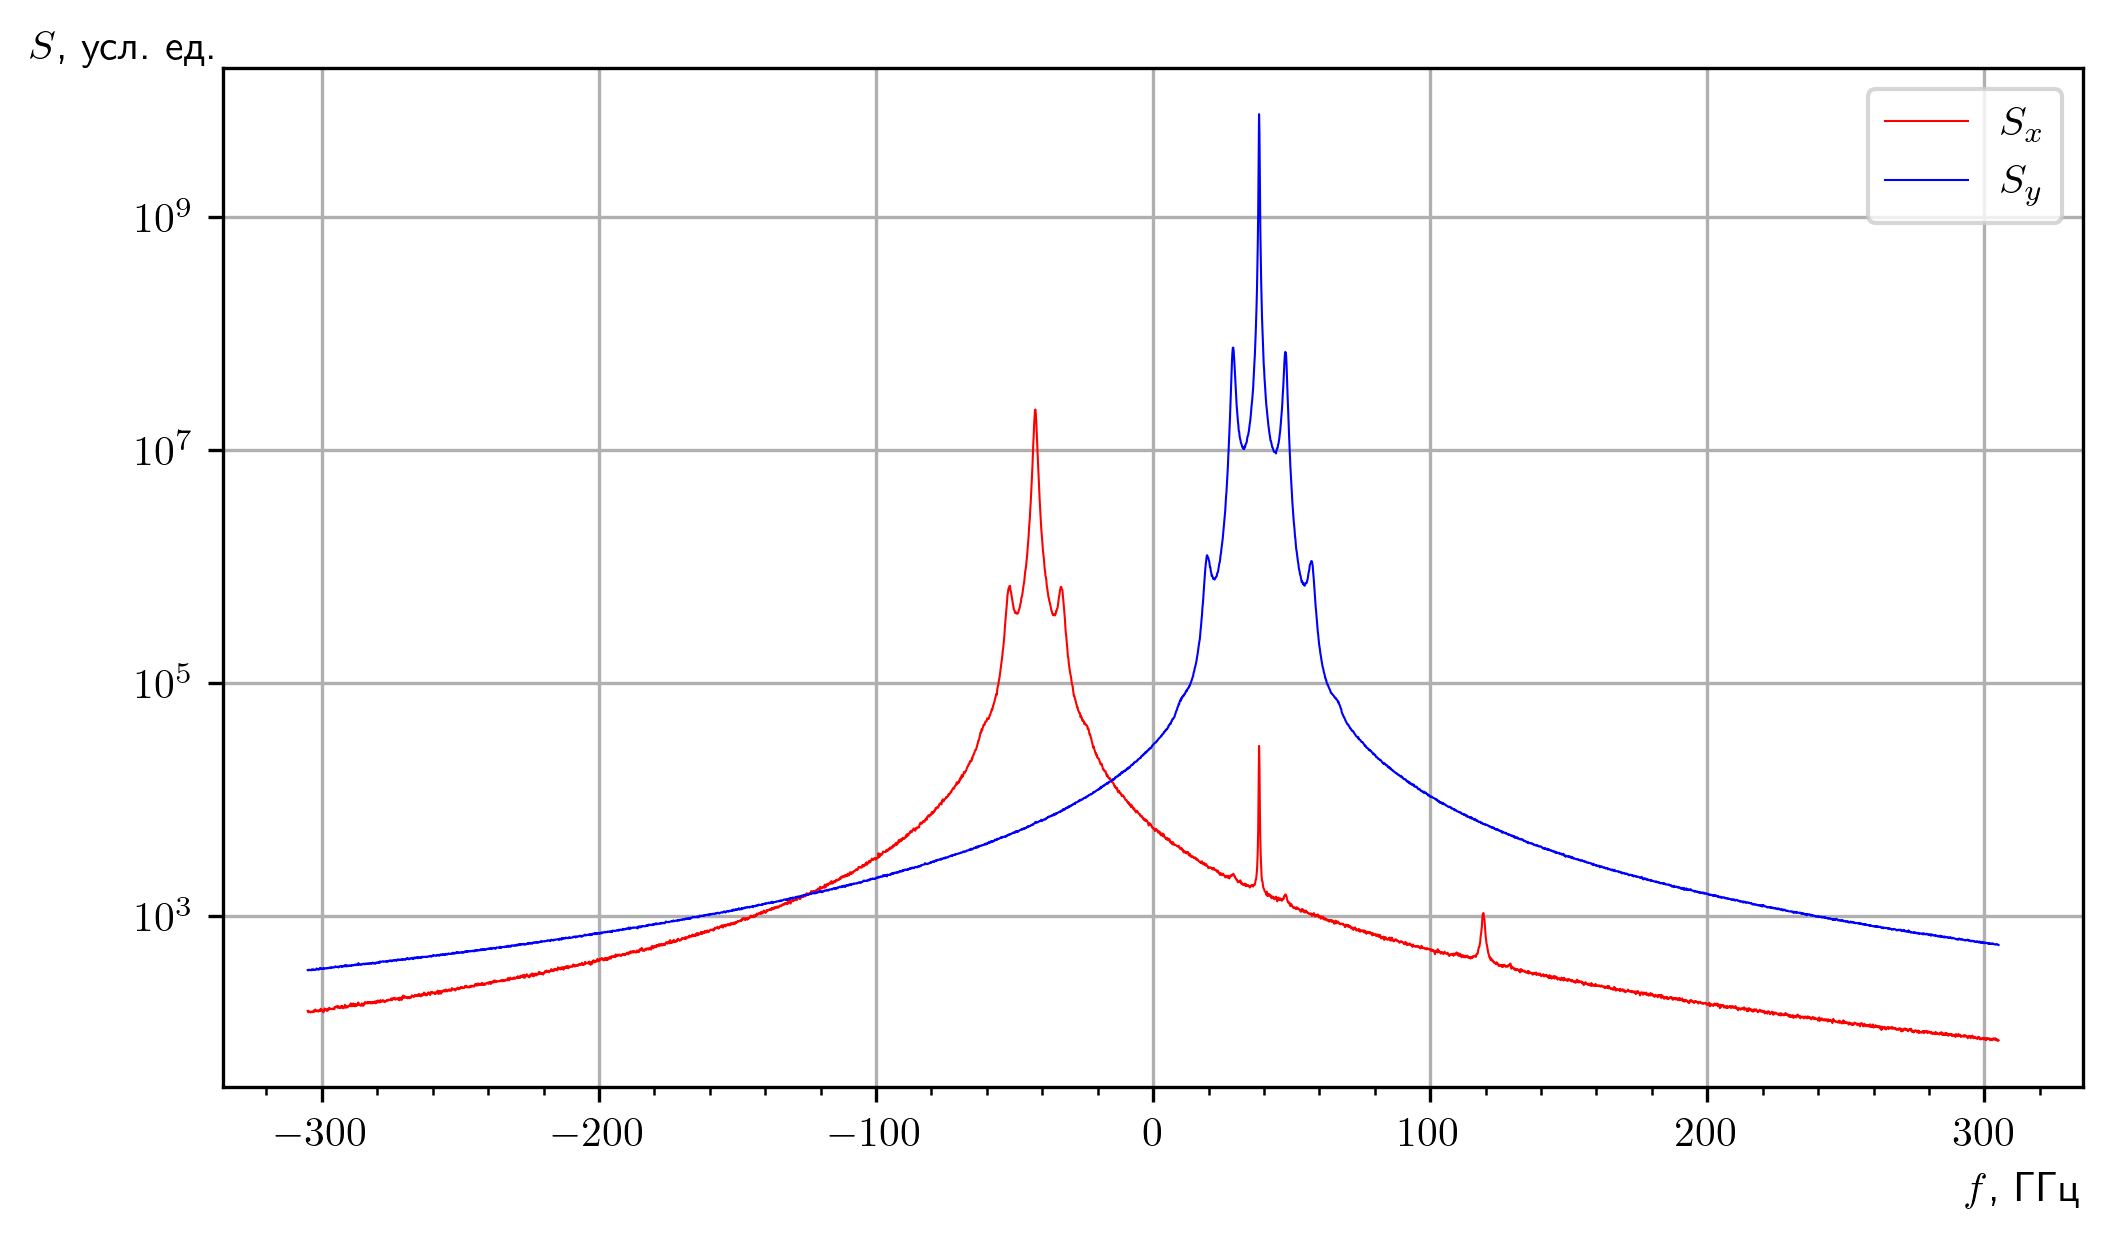

In [18]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\example_test'

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_example1);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged


np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

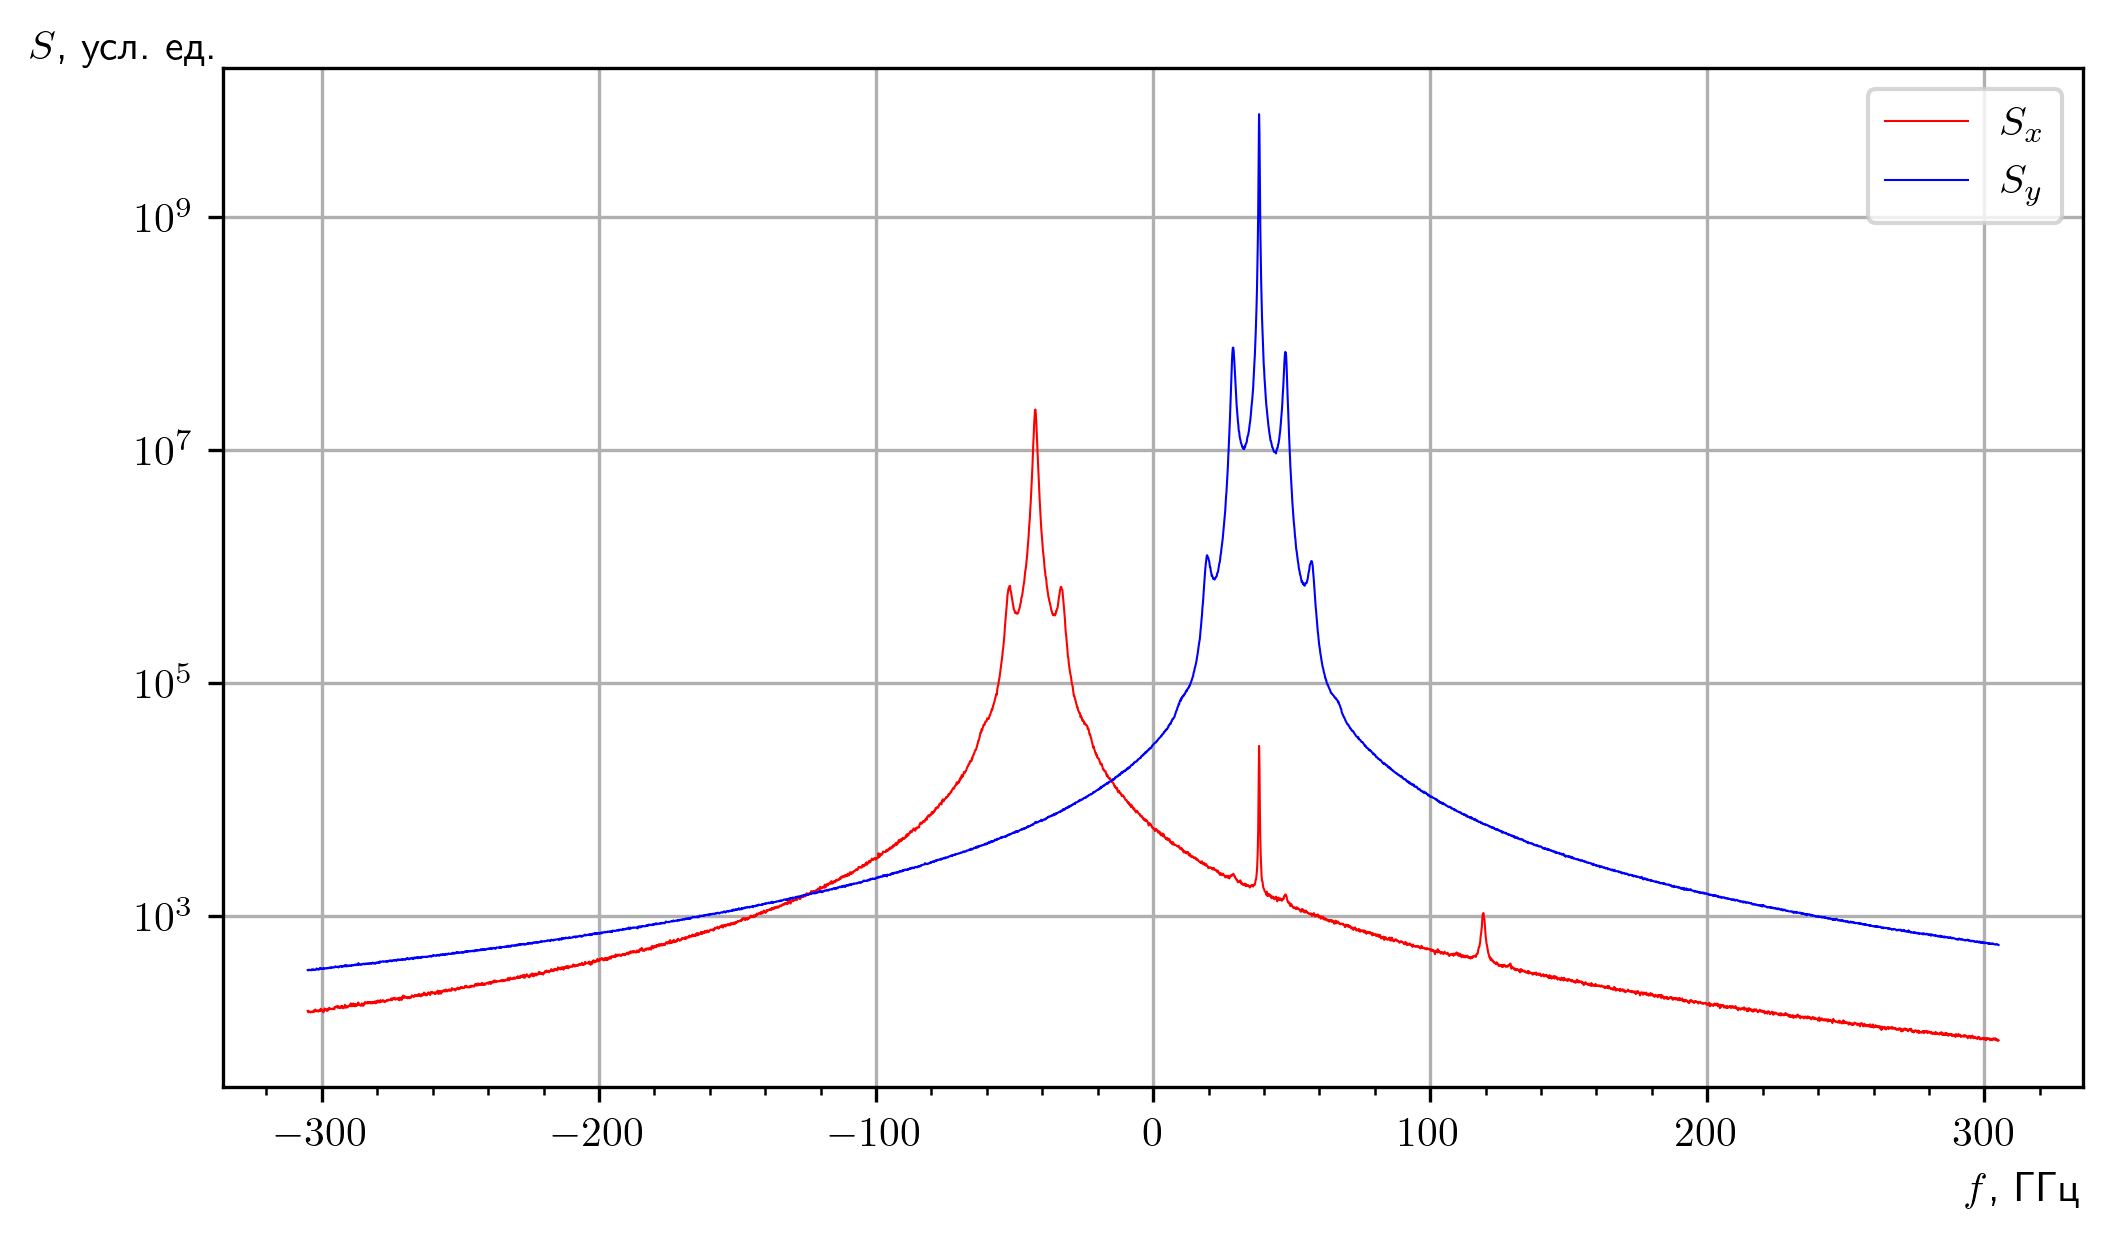

In [20]:
WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

In [14]:
params_example2 = [5., 300., 1.0, 1500., 2.5, 2*np.pi*40, 0.2, 20., 5e-5, 0.95] 

789
2631
1481
859
1377
2857
3740
Wall time: 3h 39min 20s


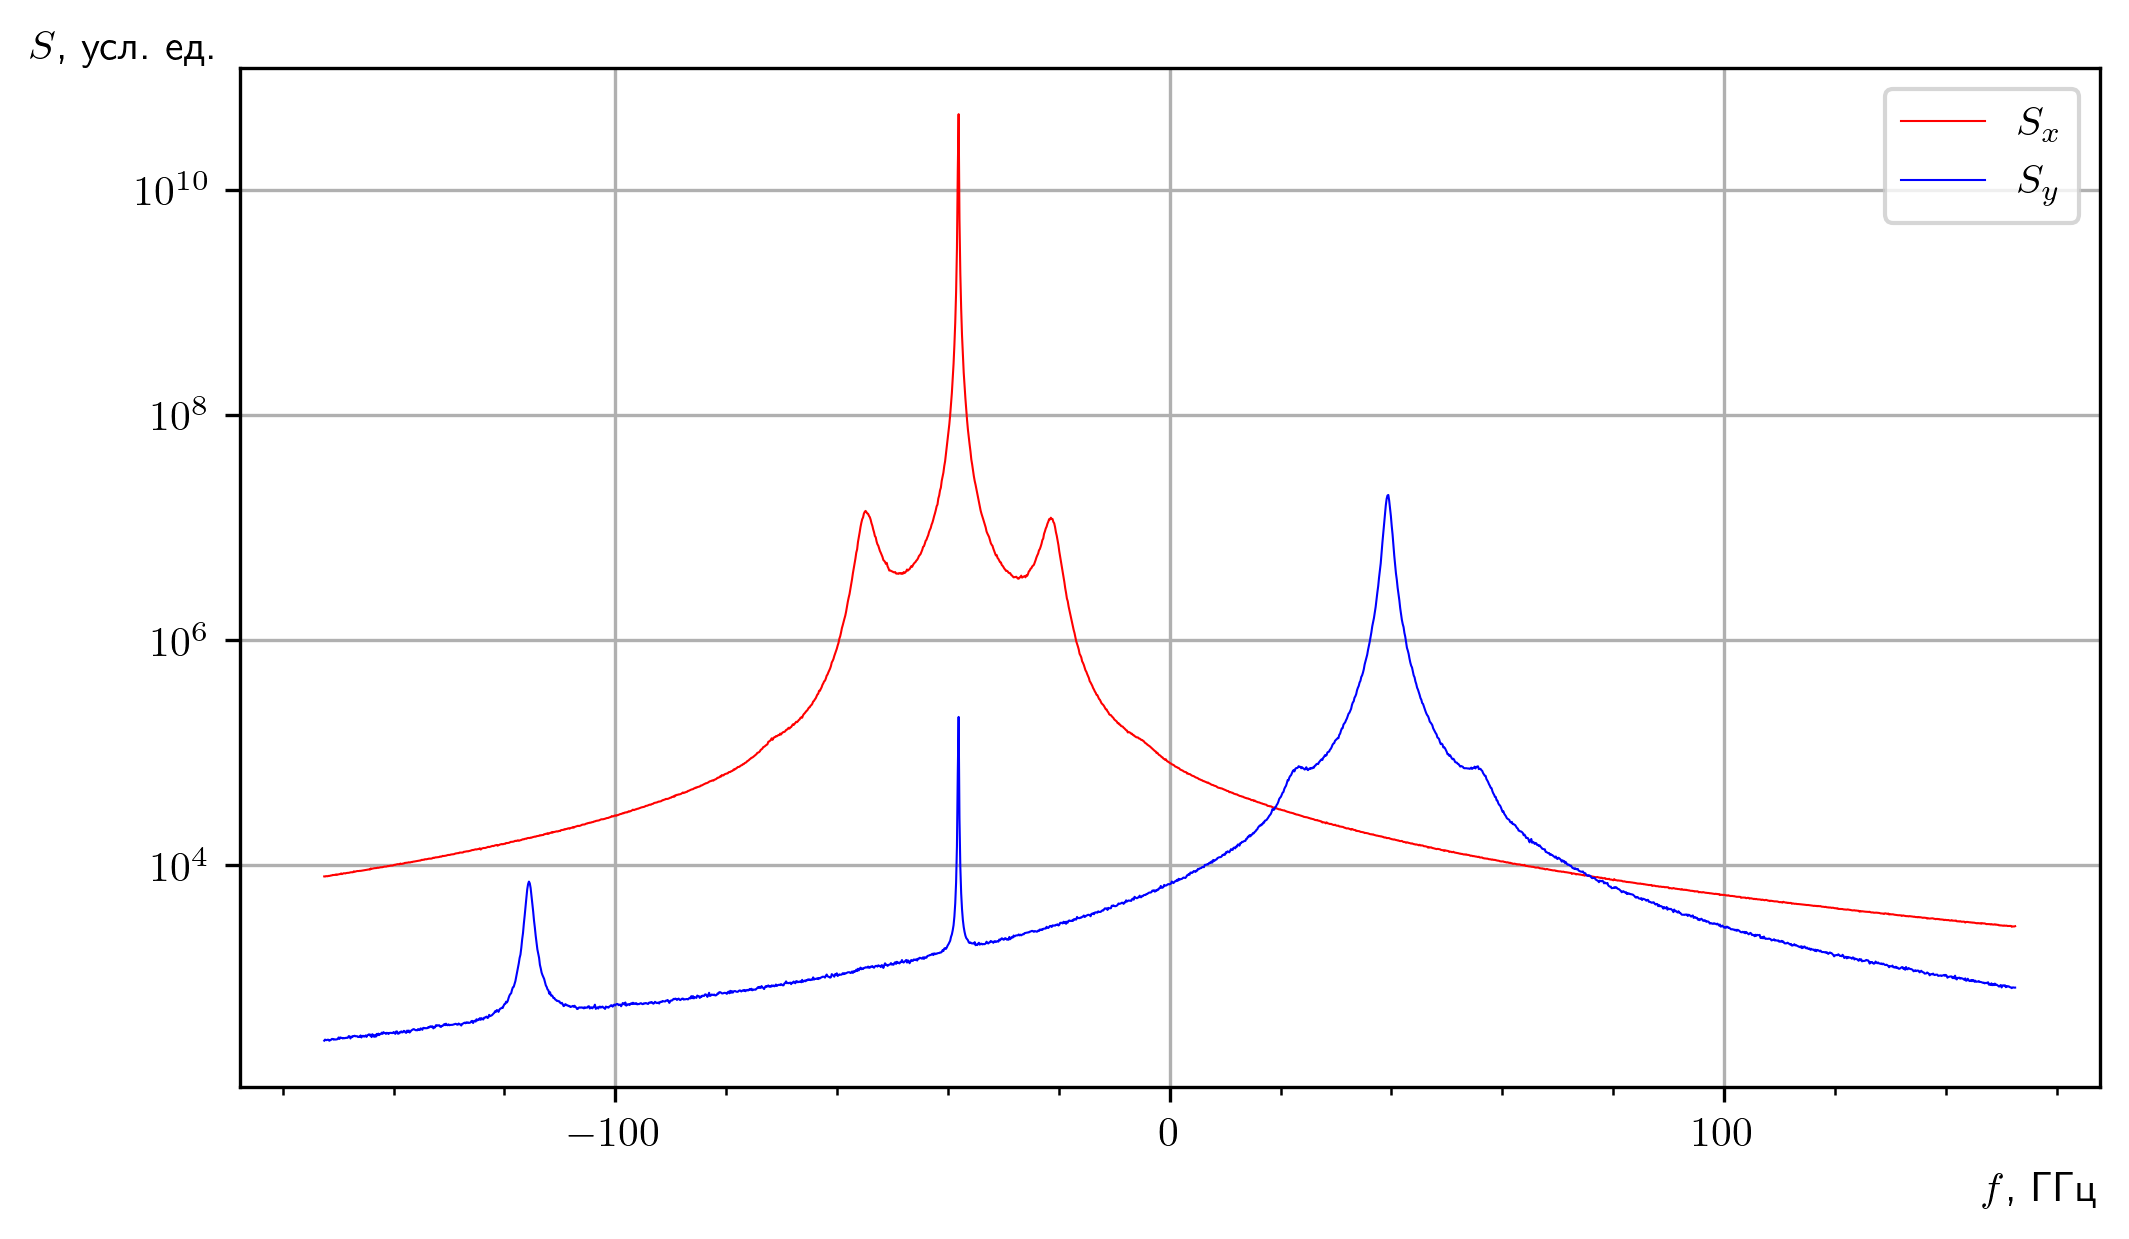

In [15]:
%%time
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\example2_10000'

Nav = 10000

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_example2);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

-1
Wall time: 6min 41s


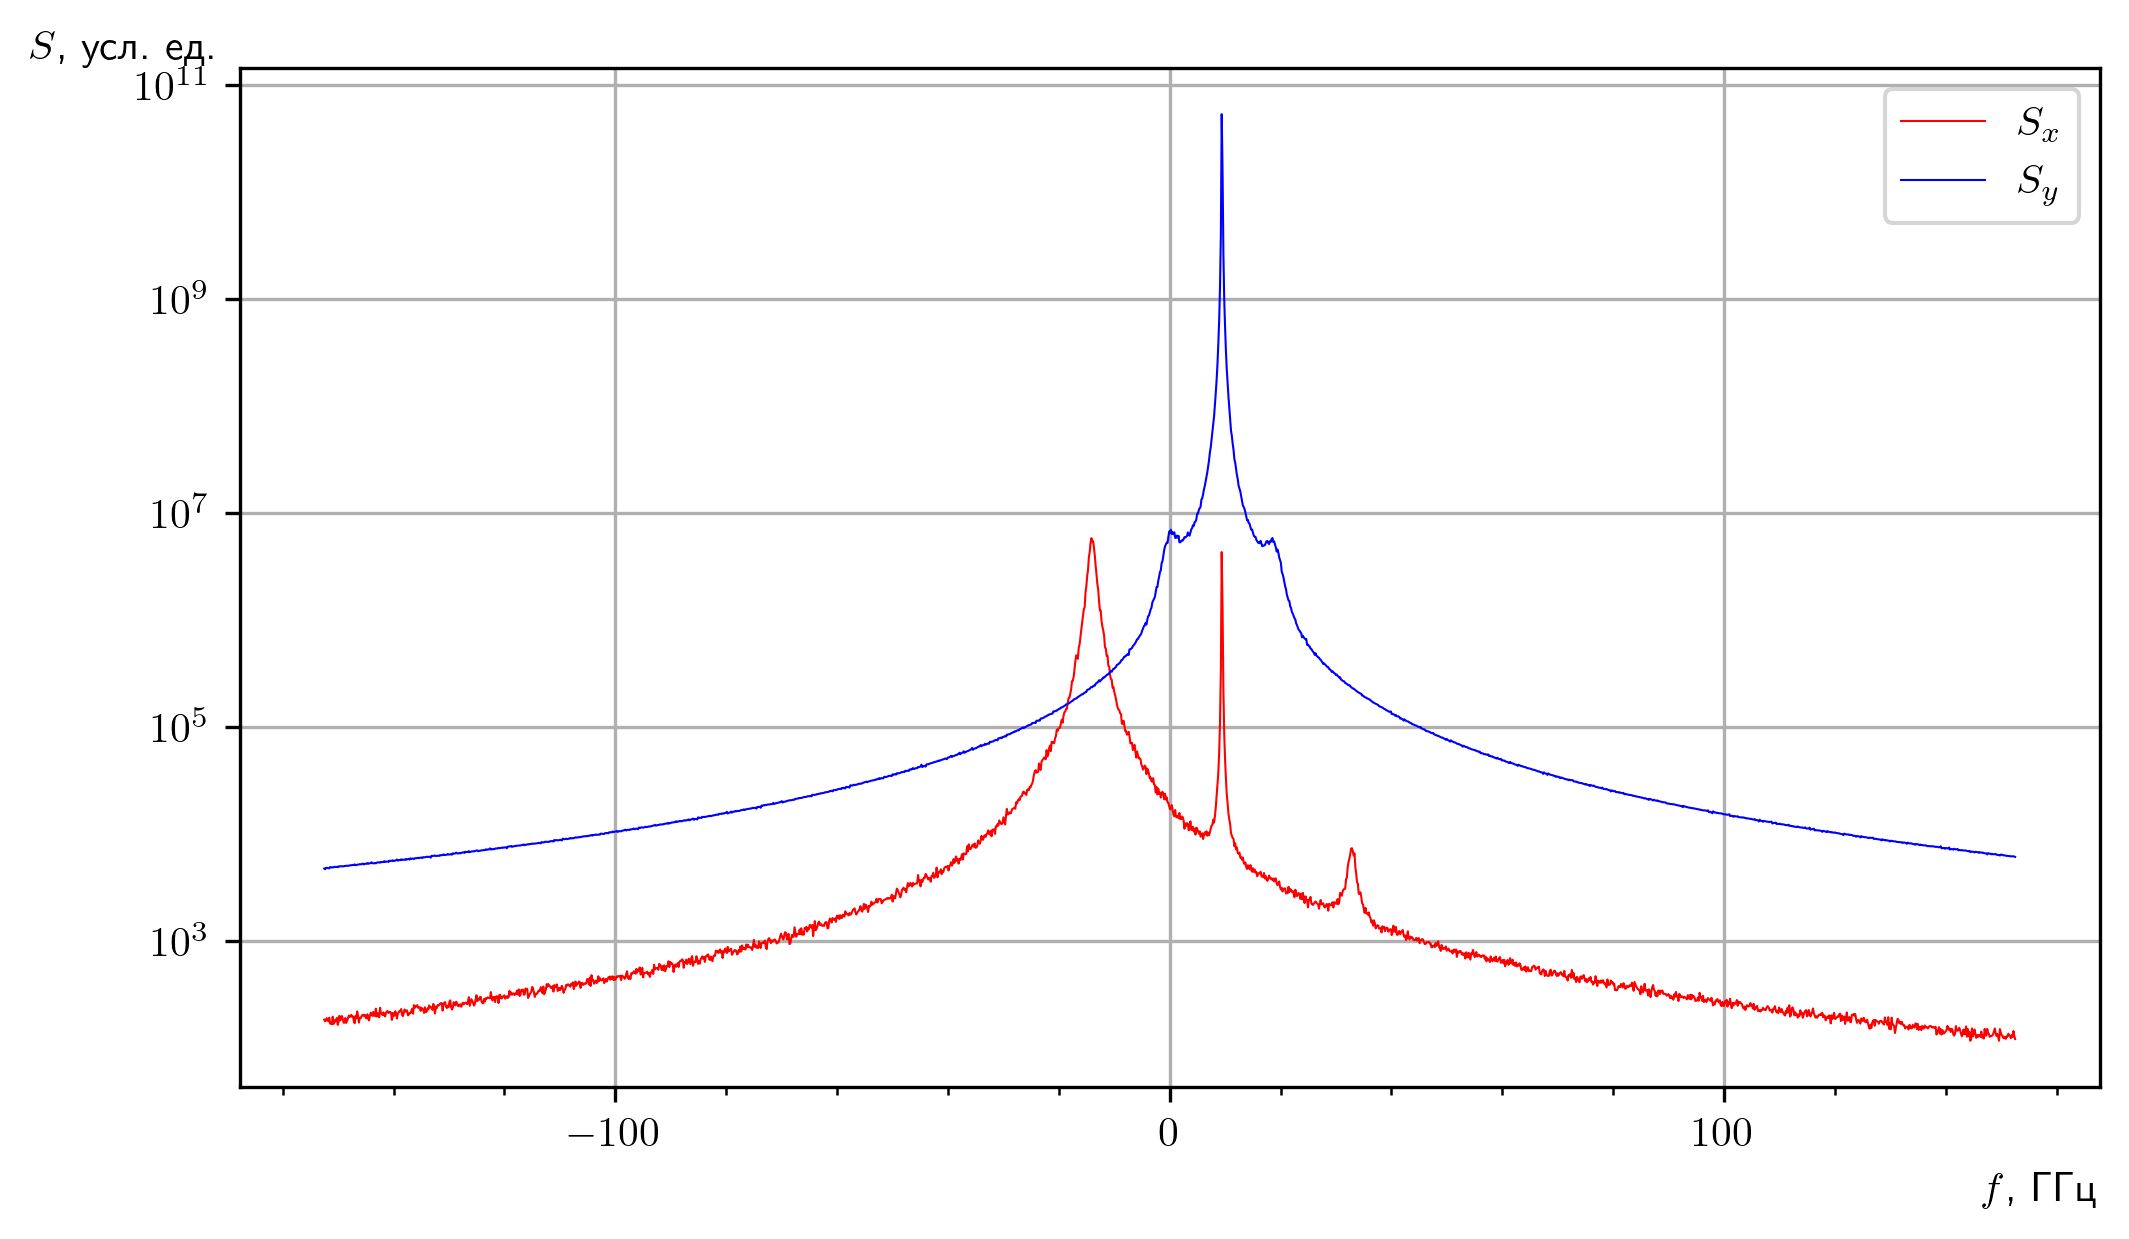

In [11]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params_new = [5., 100., 1.0, 1000., 2.5, 2*np.pi*11, -0.3, 20., 5e-5, 0.95] 


spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

Nav = 1000
filename = r'include_in_dip\spec_like_exp'


averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params_new);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged

    
np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

In [12]:
averaged

1000

In [7]:
np.savetxt("Spec_like_exp.txt", np.transpose([freqs, spx, spy]))

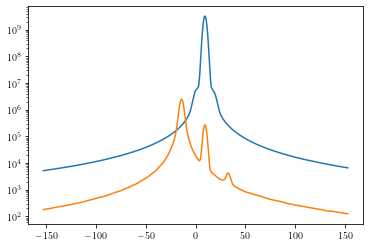

In [11]:
plt.plot(freqs[wnd], sp.ndimage.gaussian_filter1d(spy, 10)[wnd], freqs[wnd], sp.ndimage.gaussian_filter1d(spx, 10)[wnd])
plt.yscale("log")

In [9]:
spx.shape

(65536,)

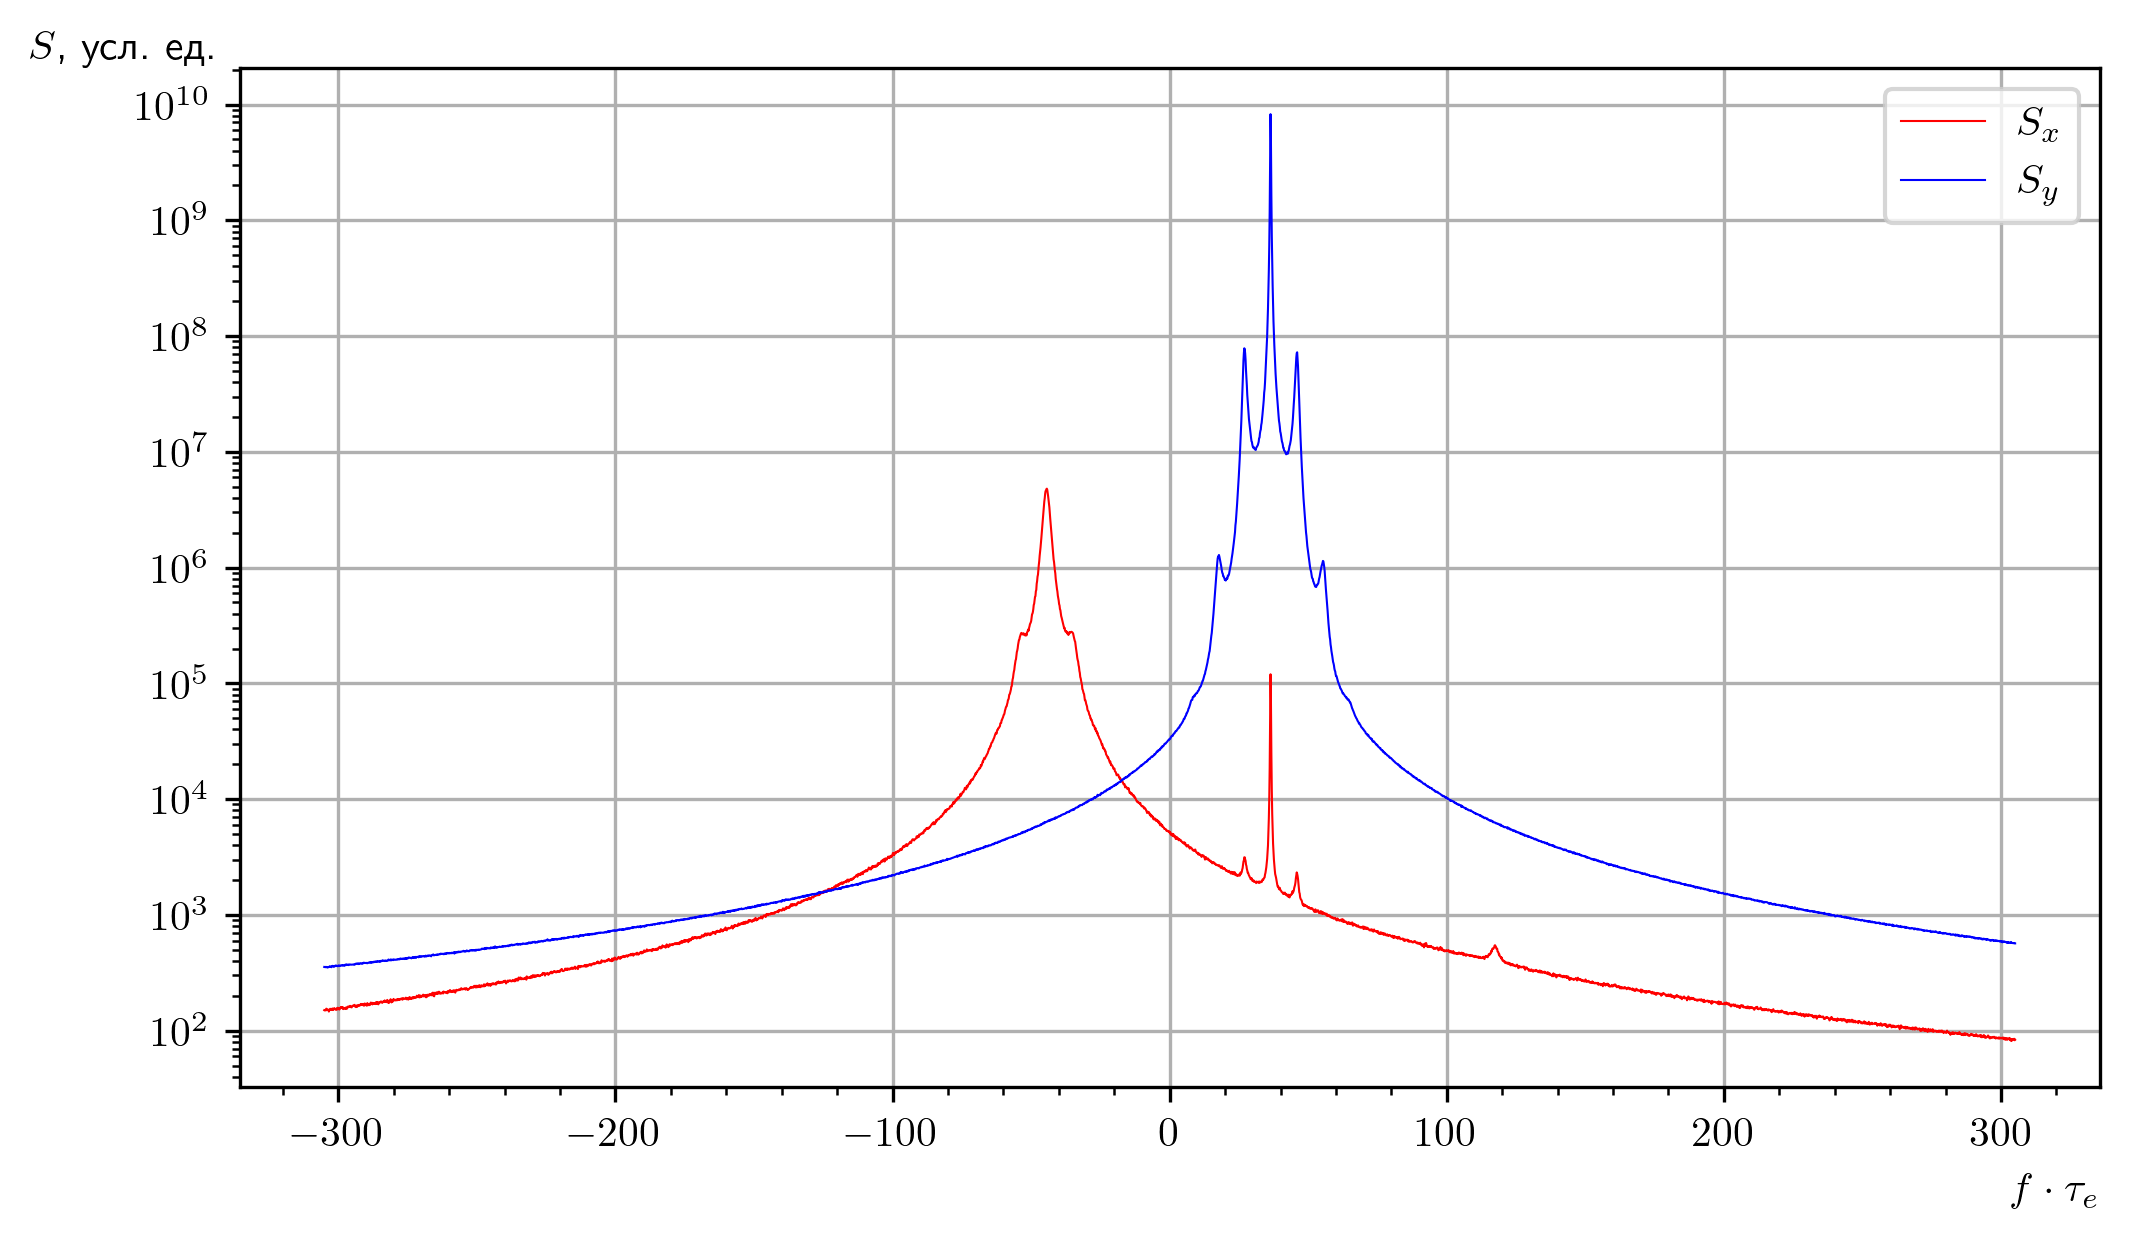

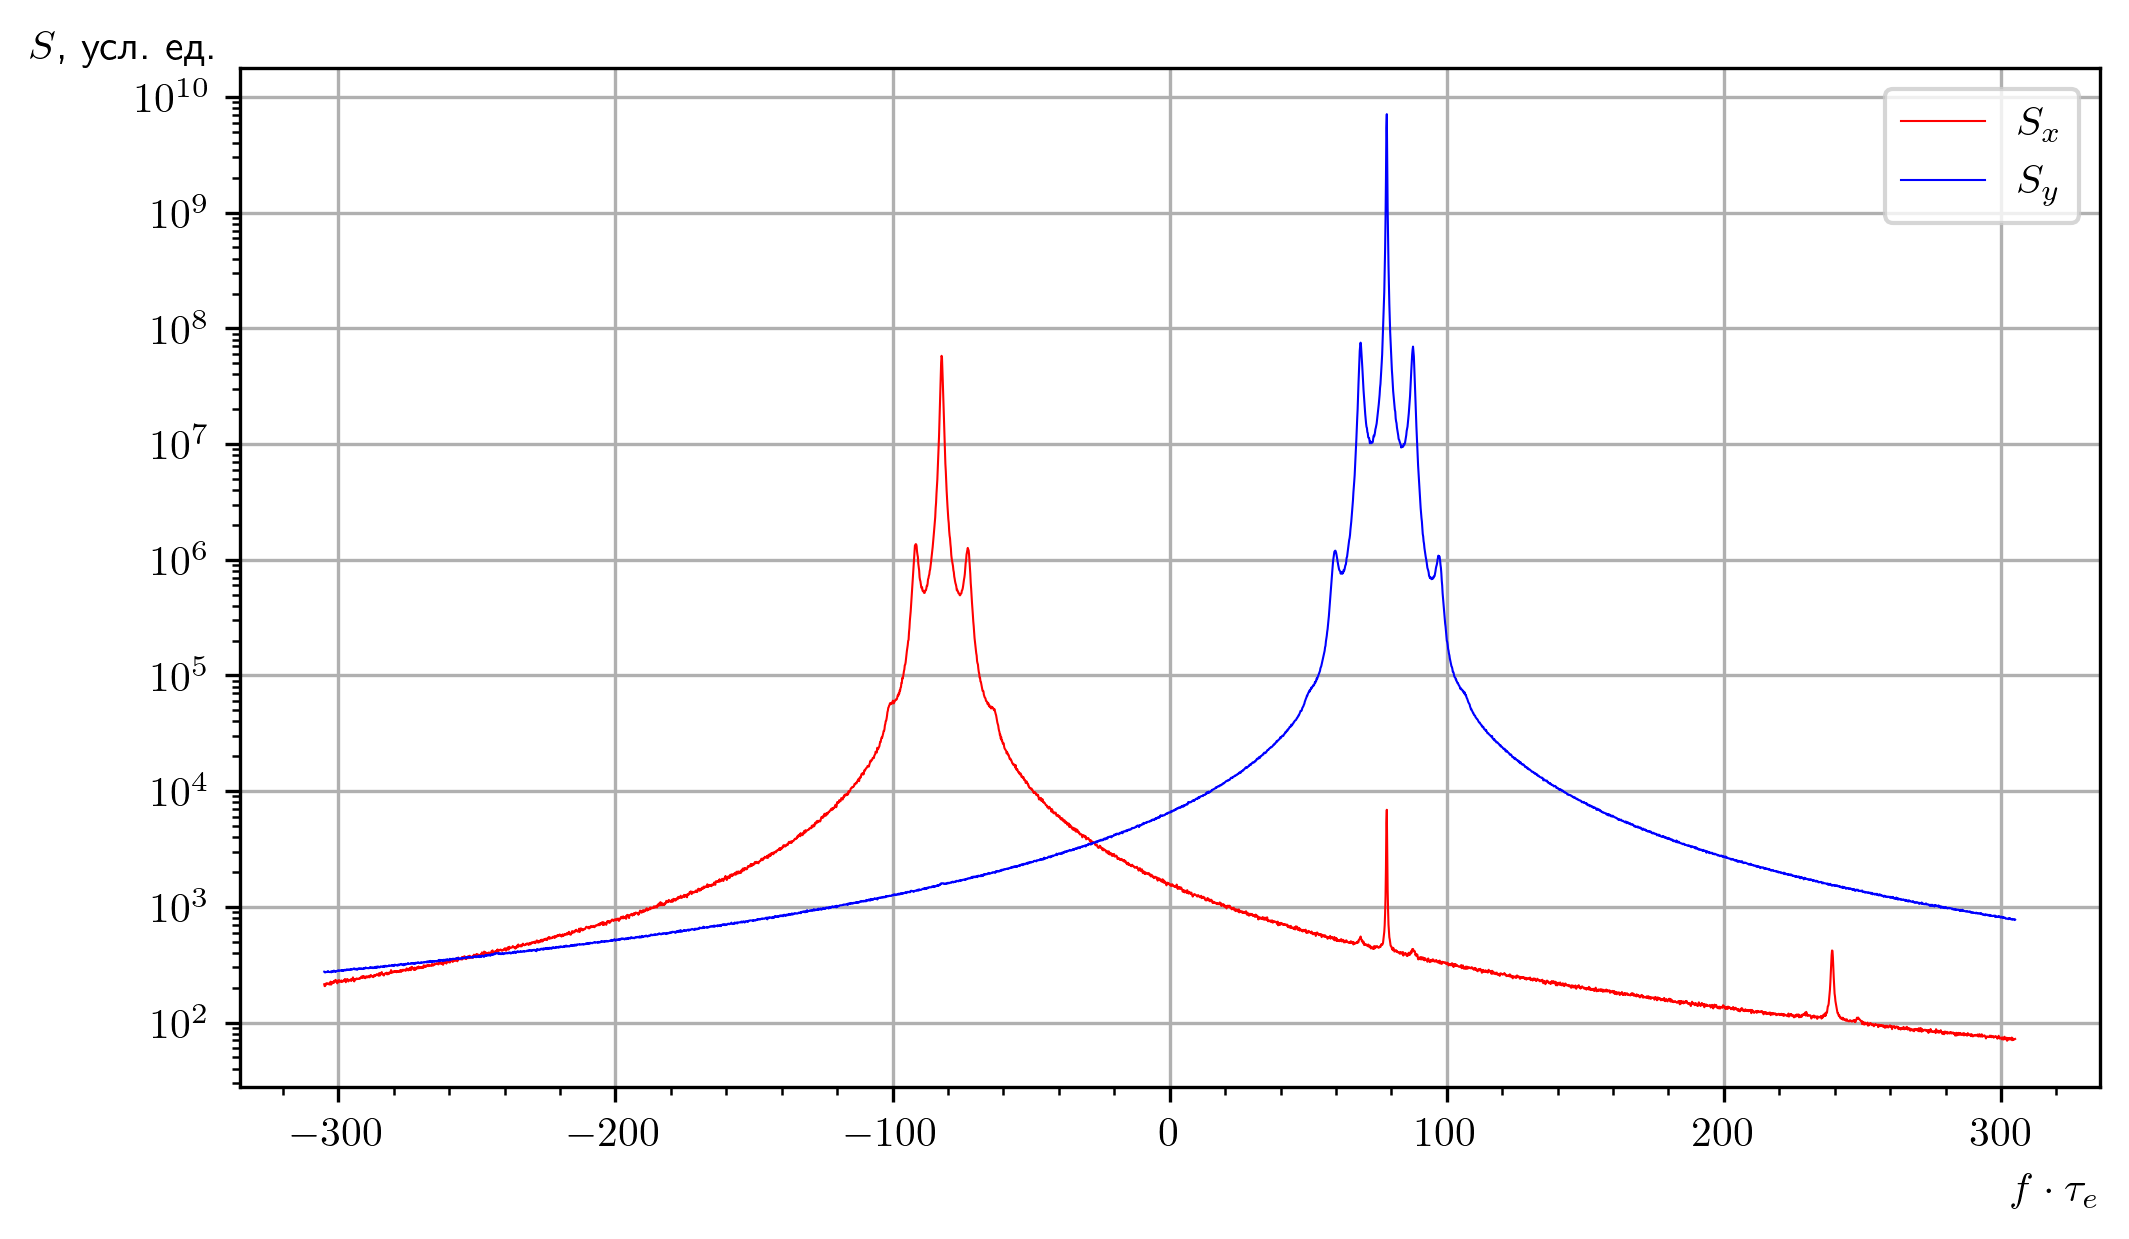

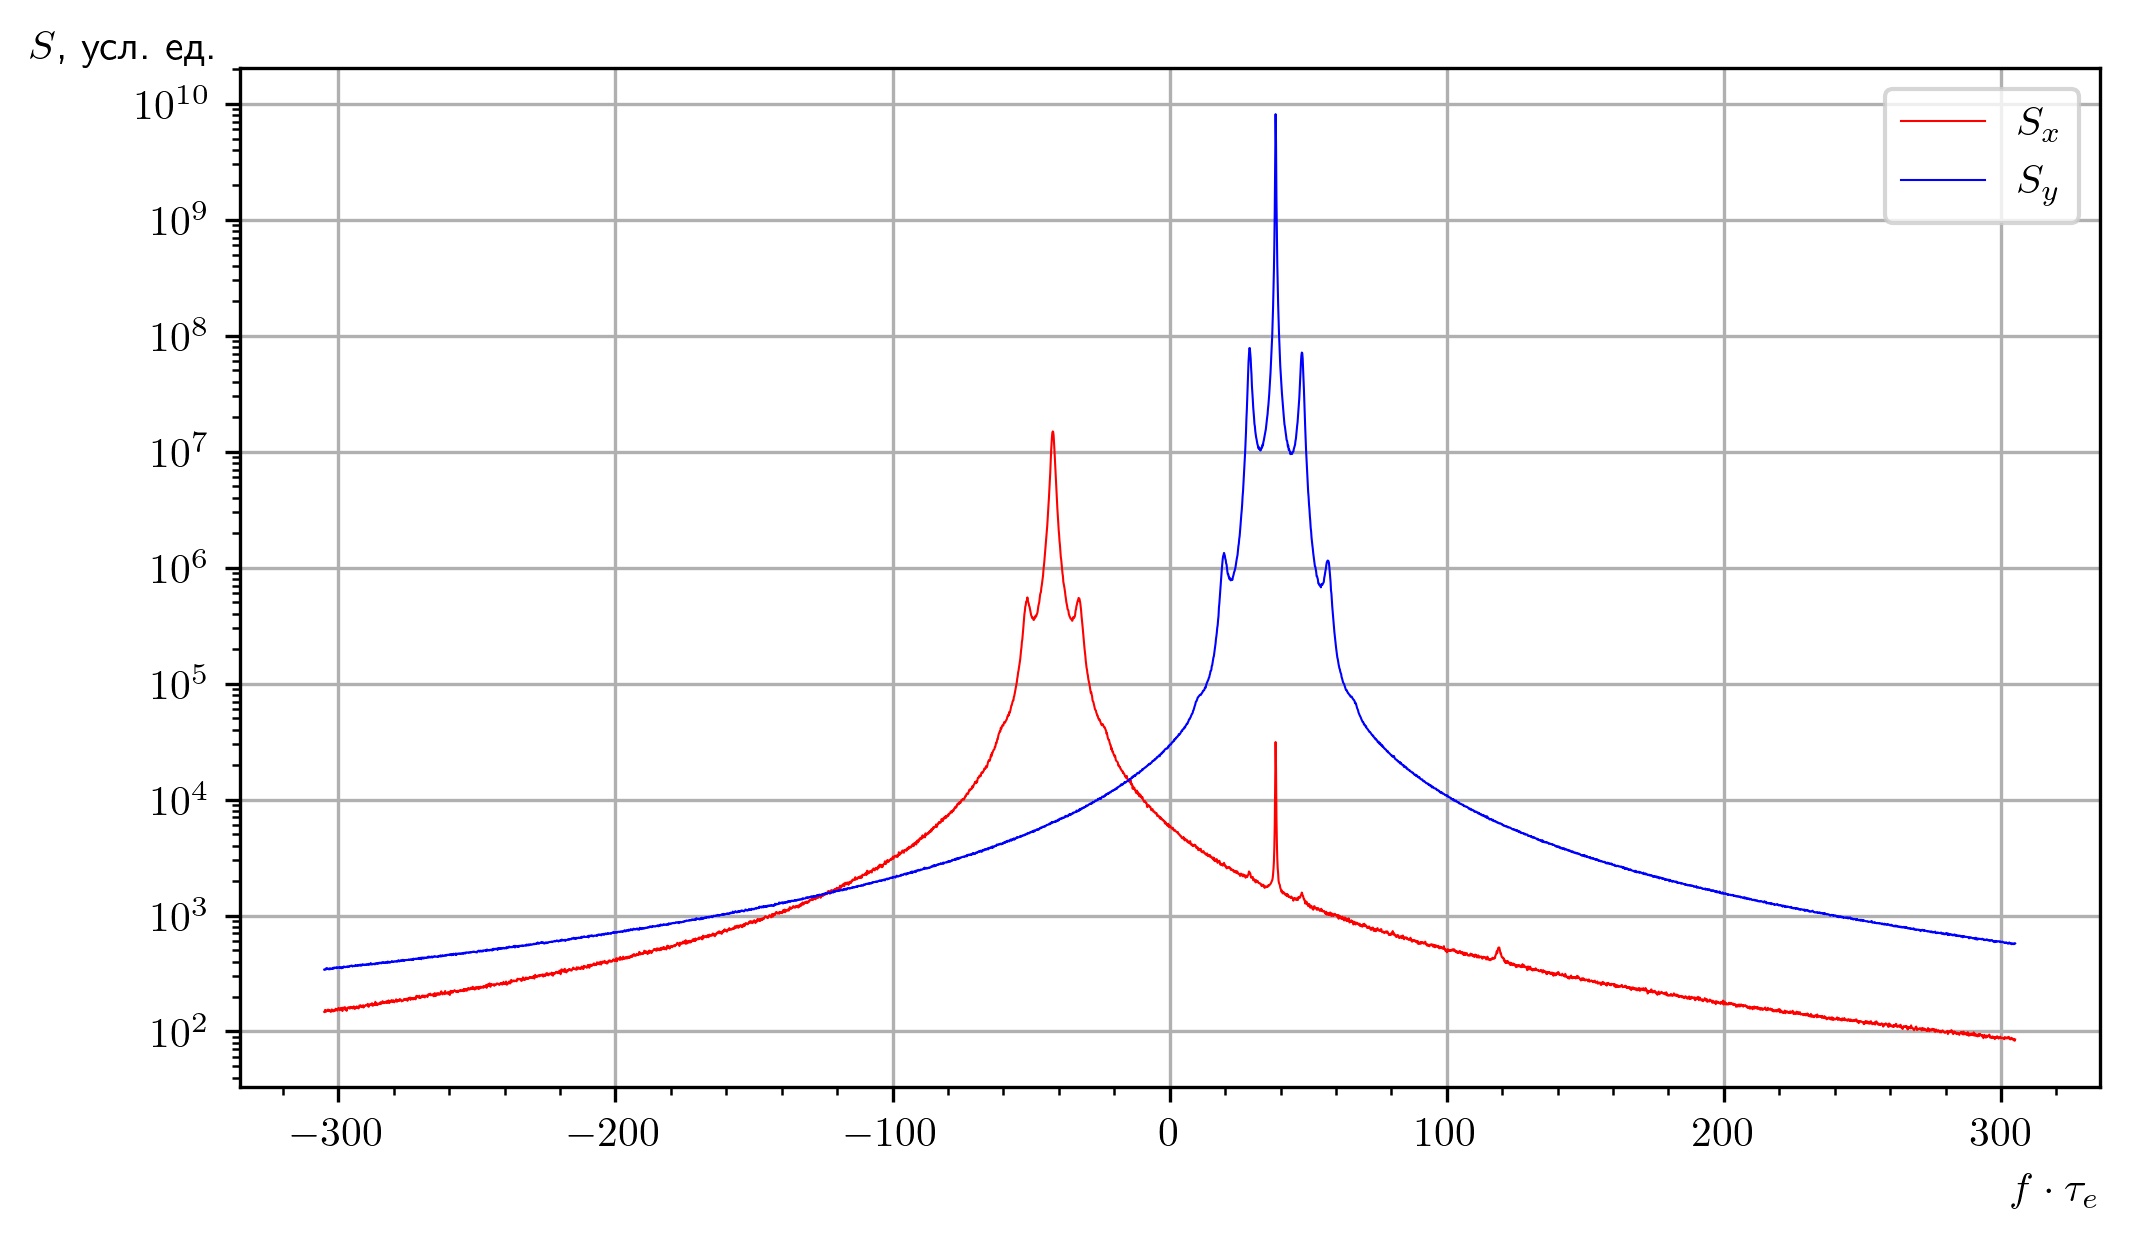

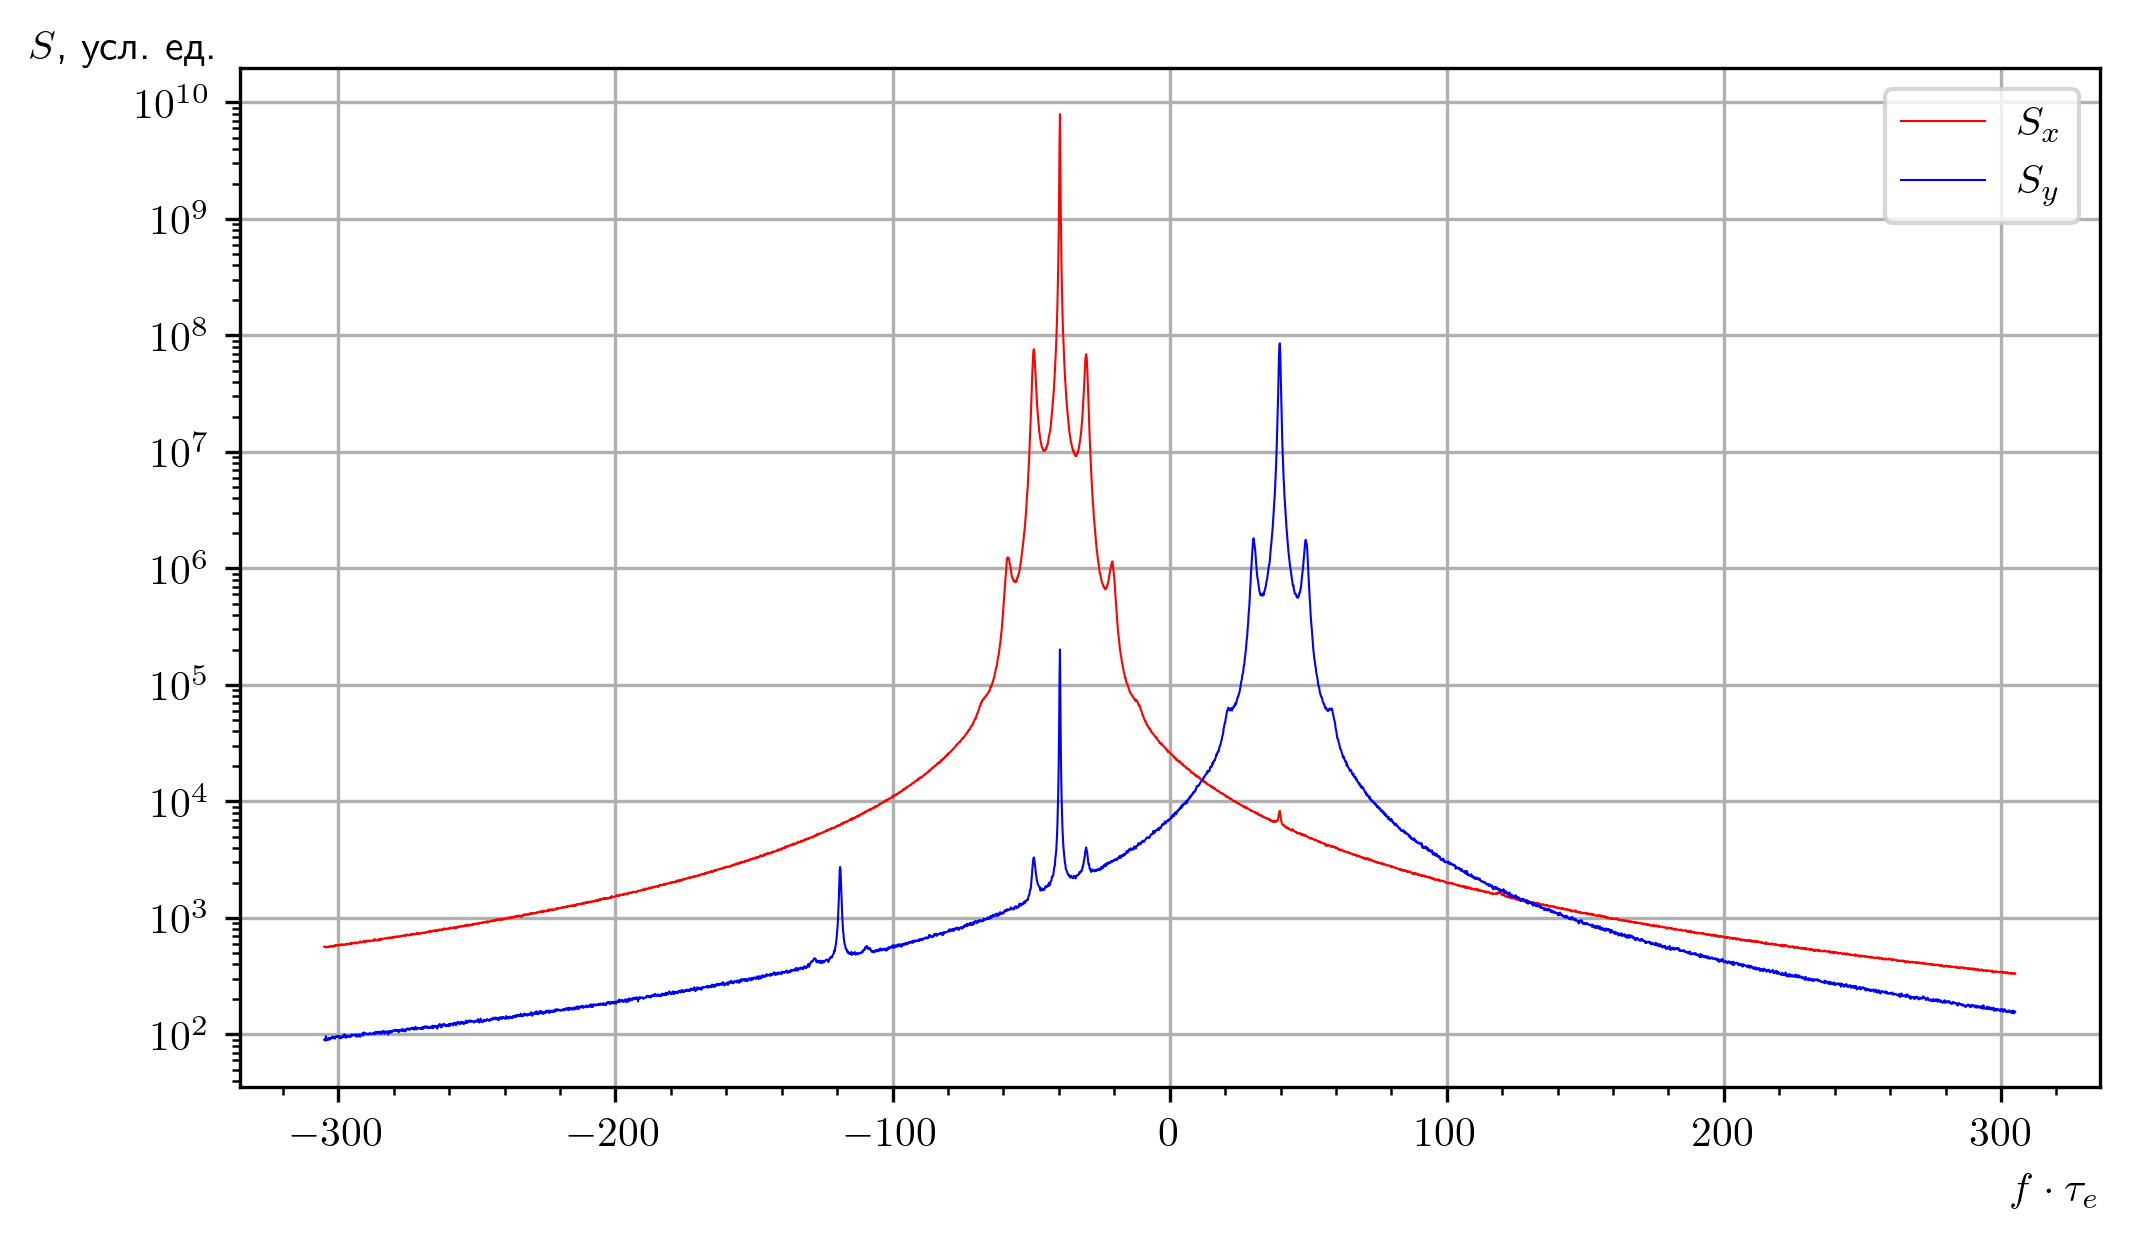

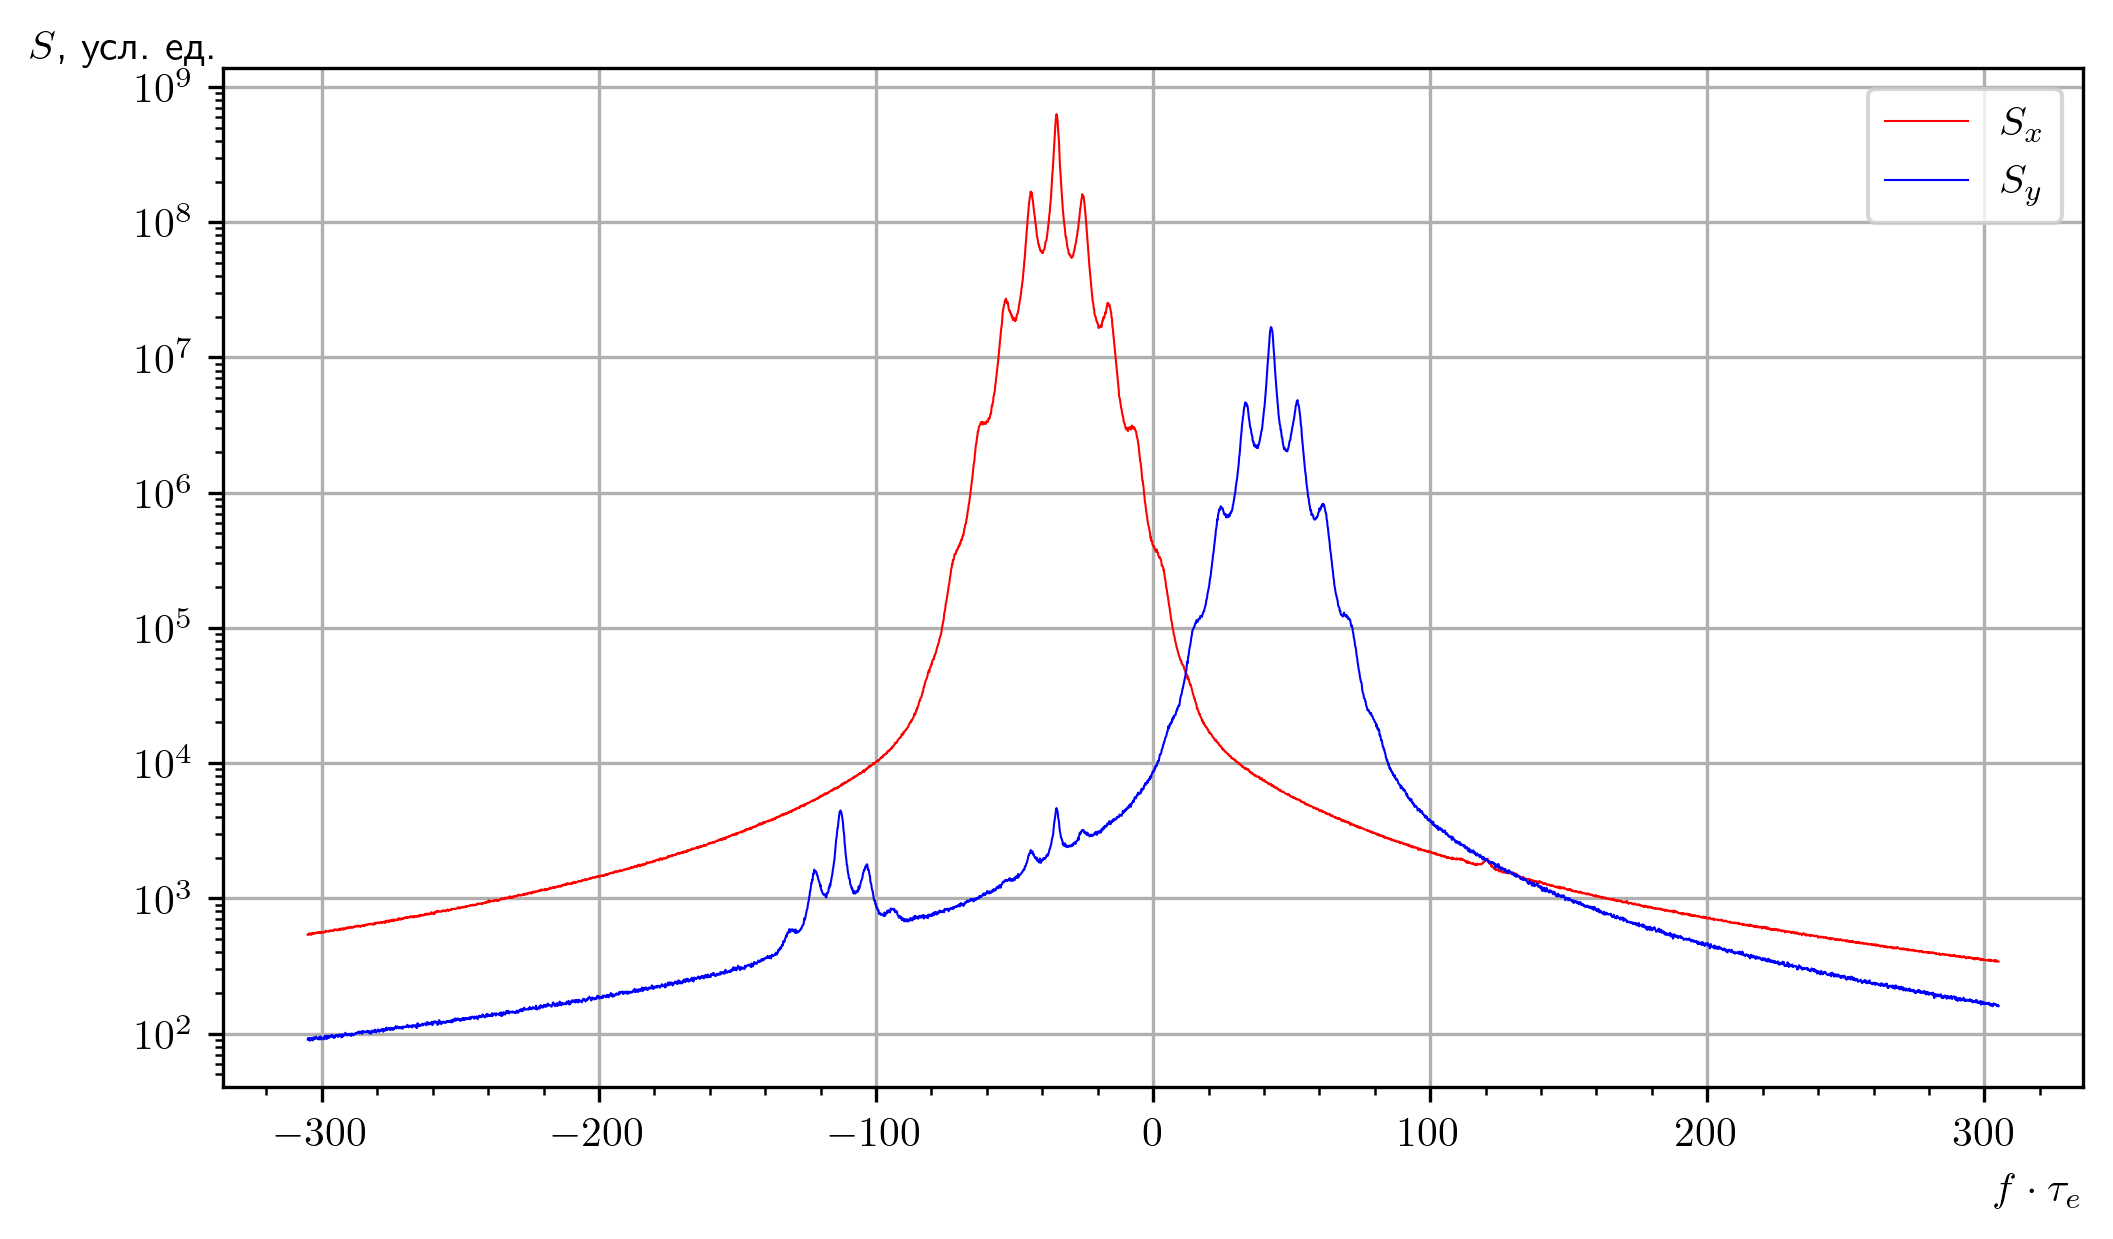

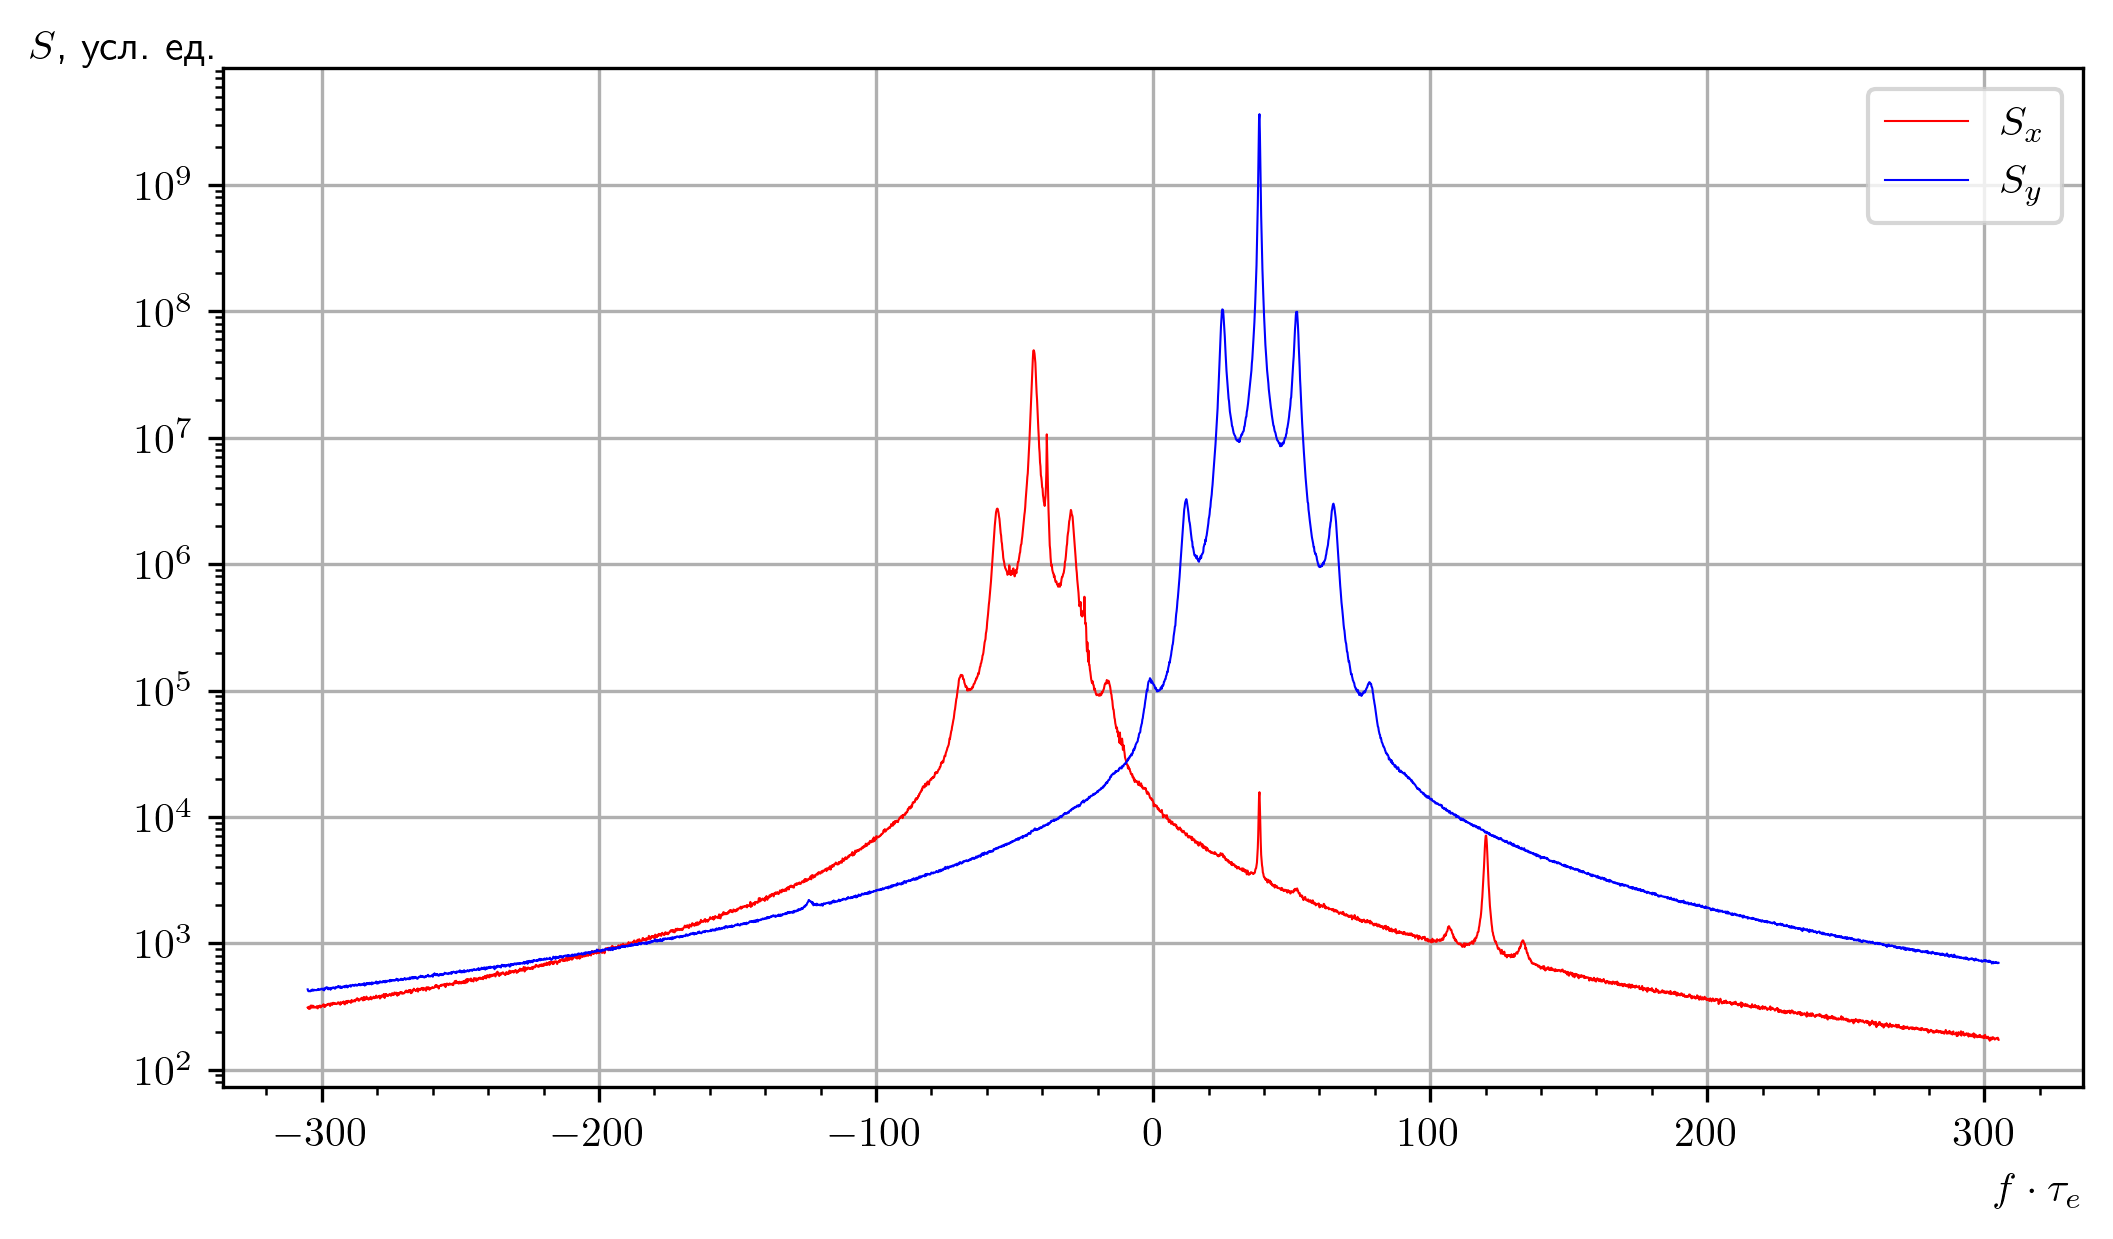

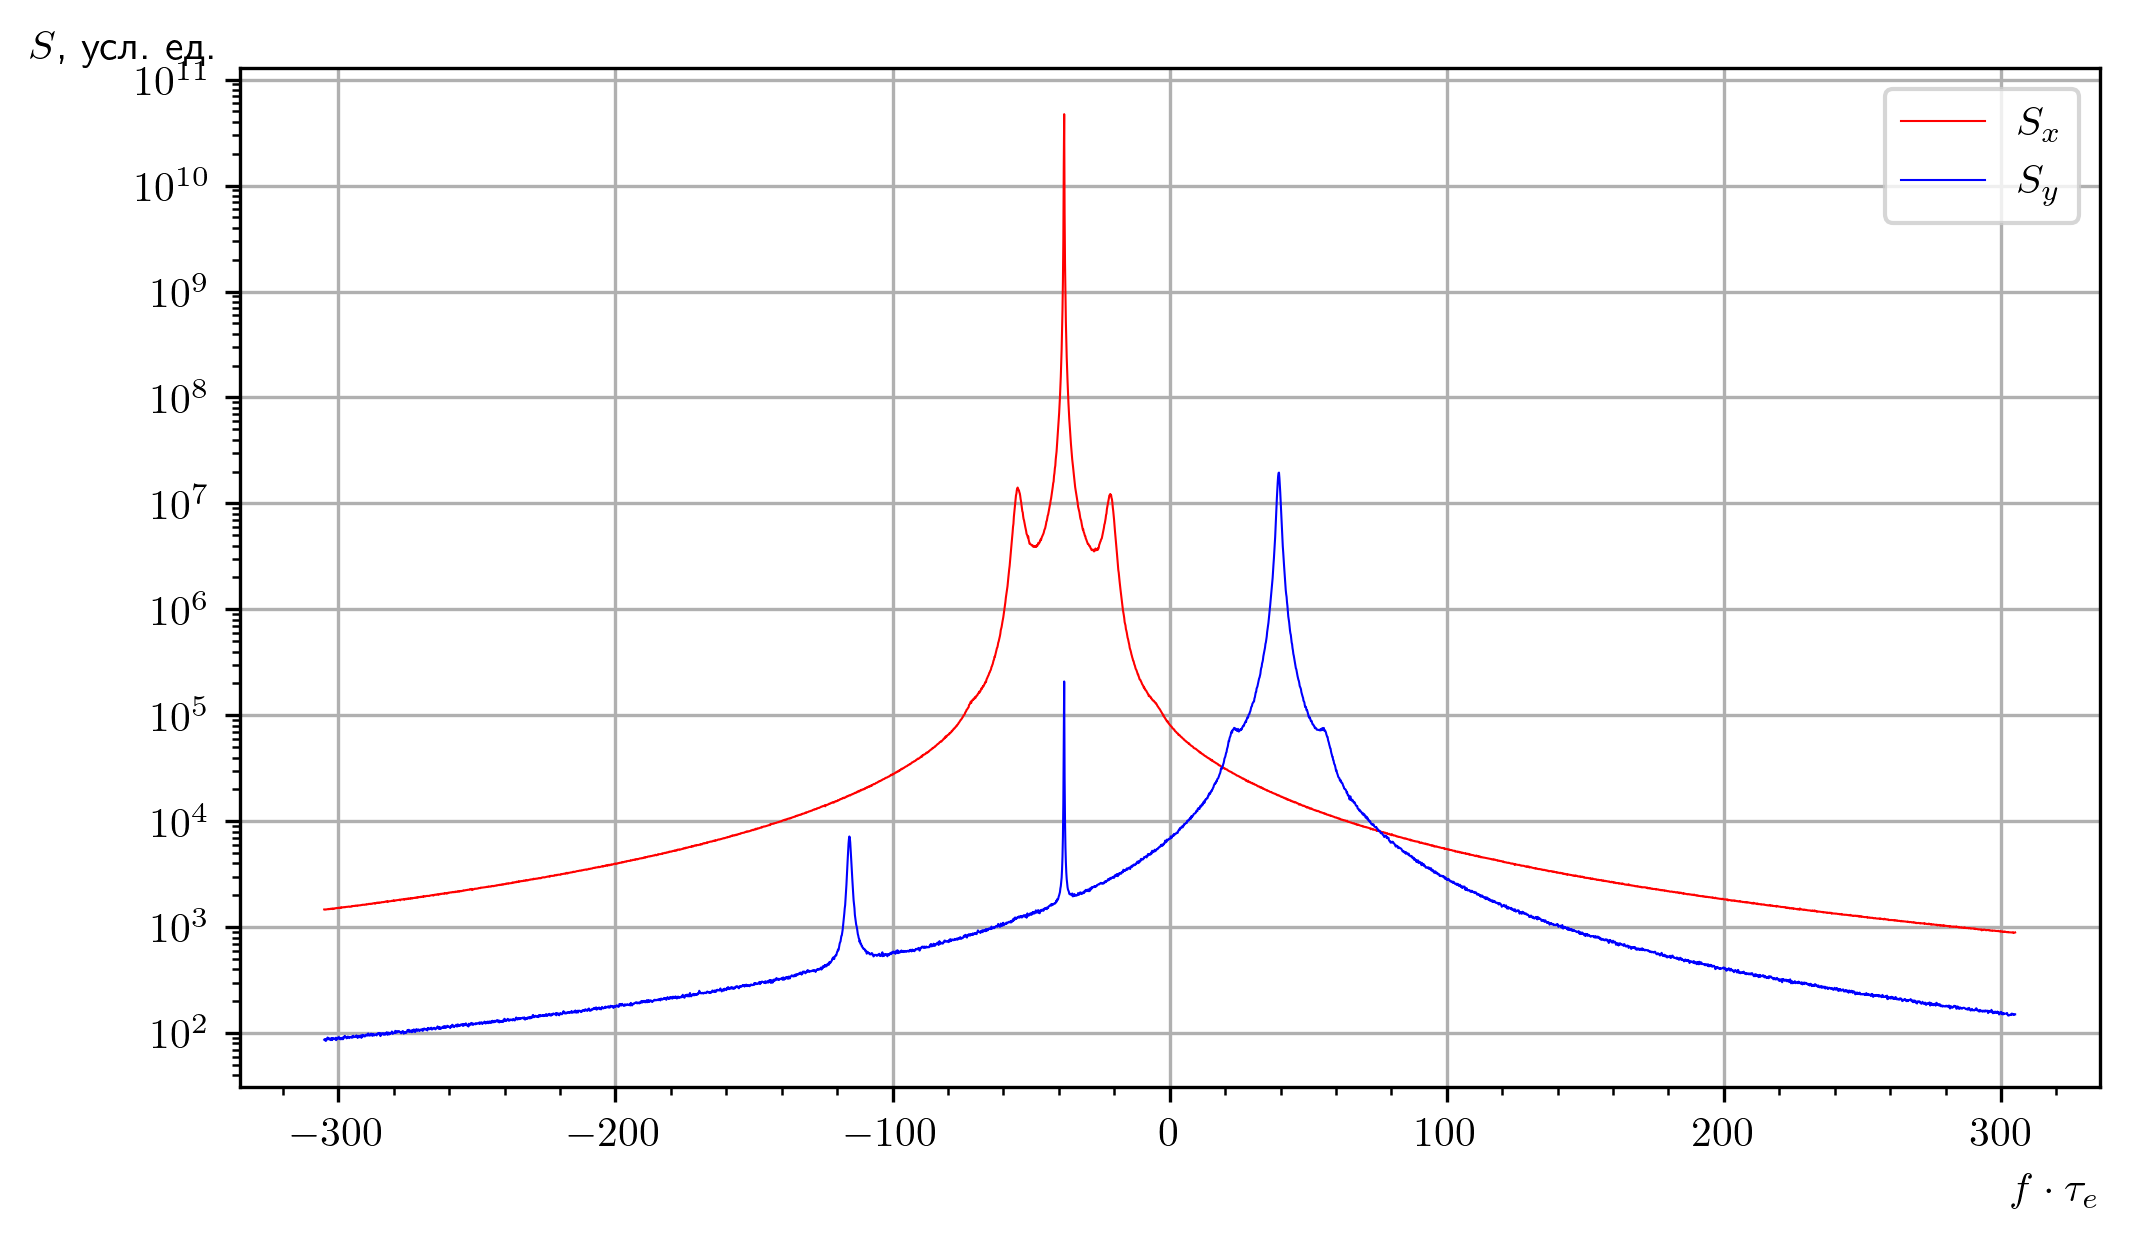

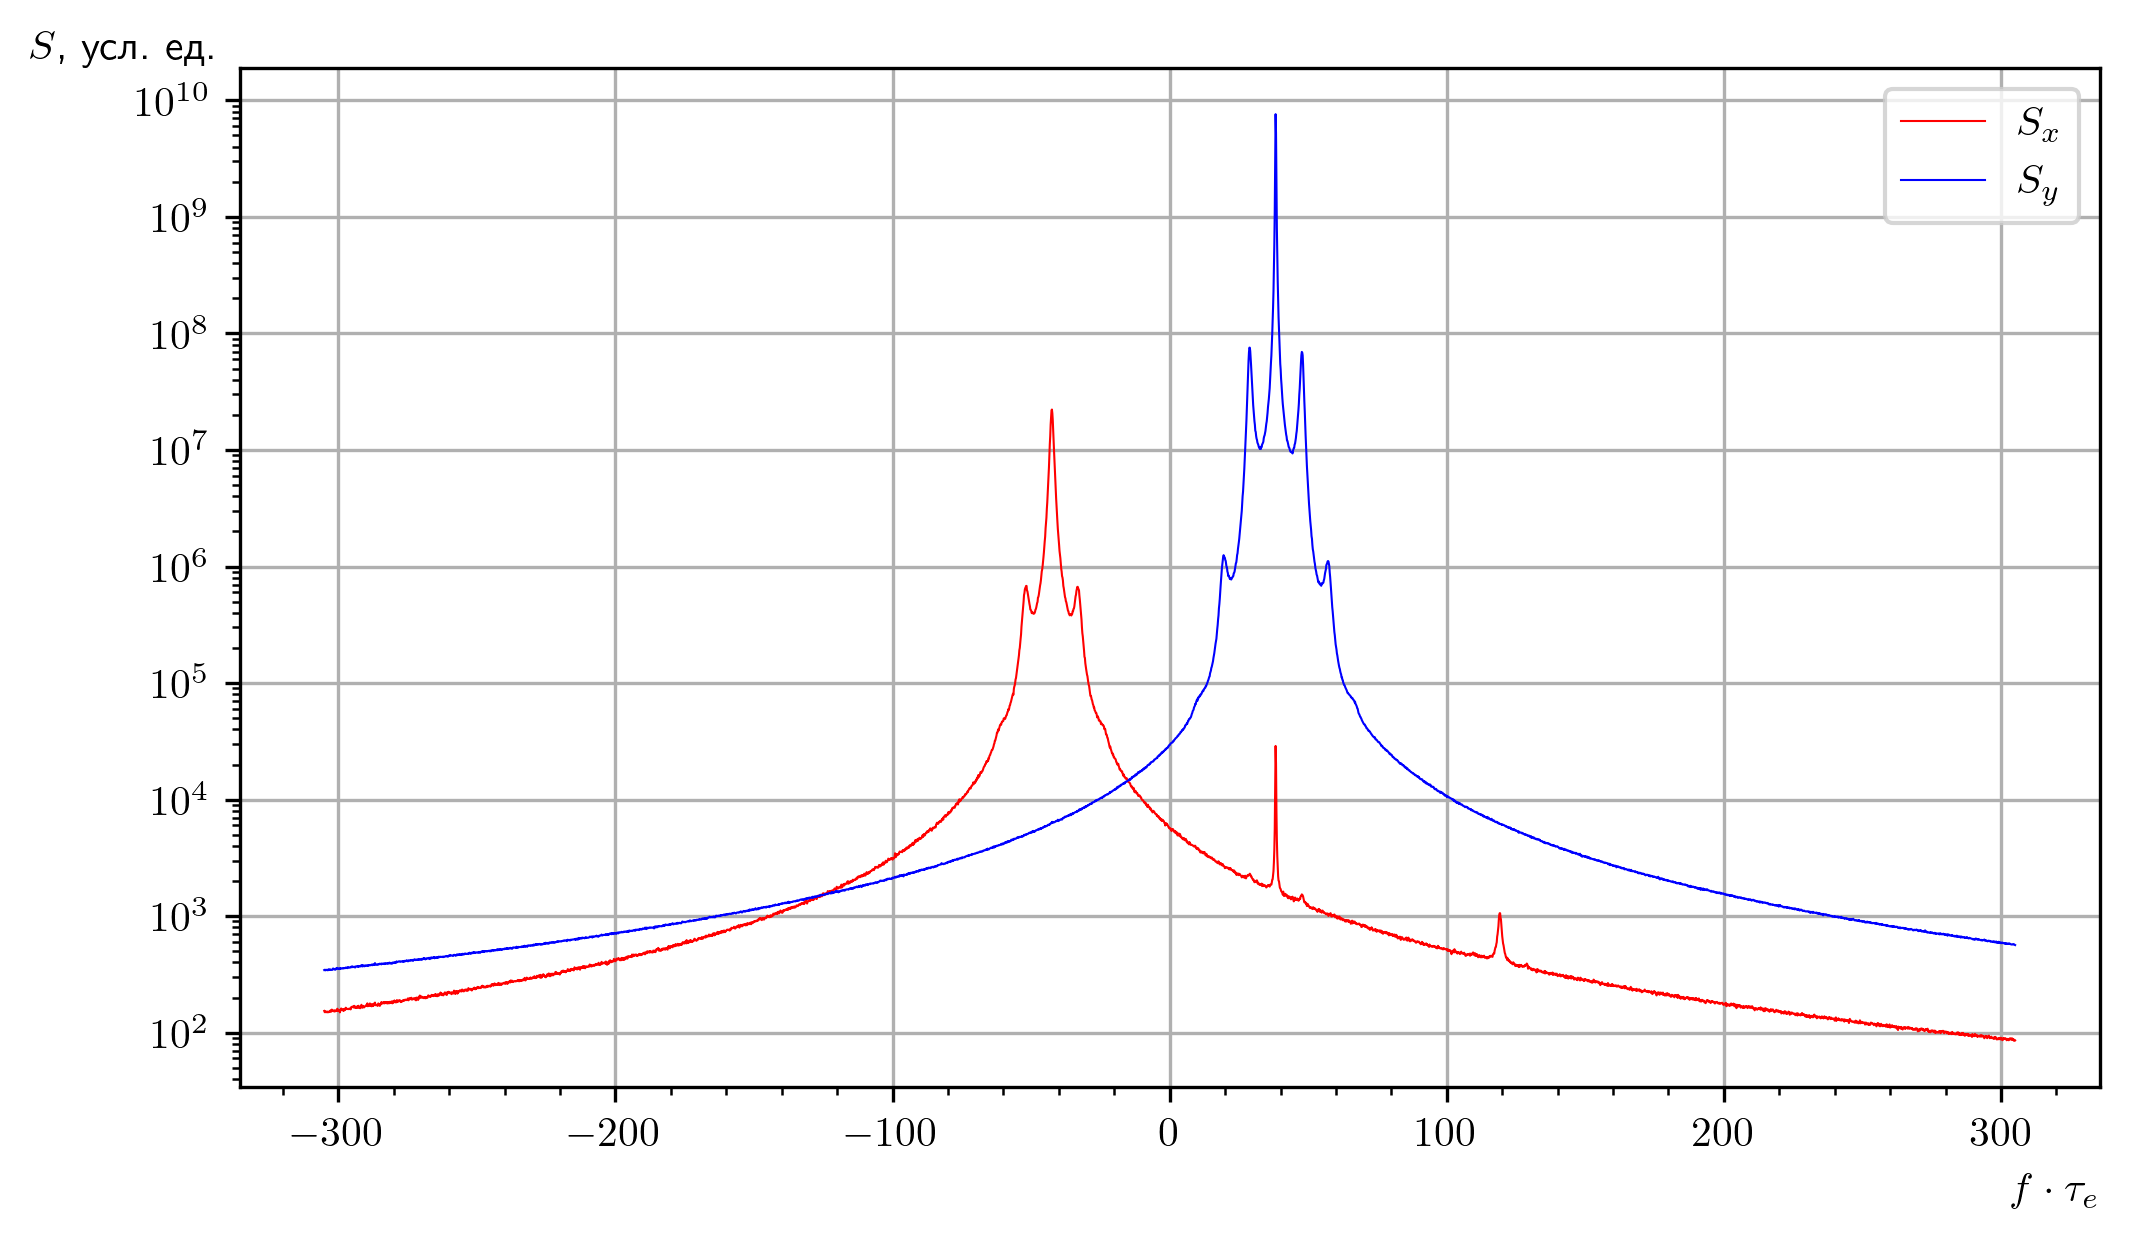

In [38]:
fnames = ["include_in_dip/gammaa5_fine", "include_in_dip/gammap80_fine", "include_in_dip/gammad3000_fine", 
          "include_in_dip/beta07_fine", "include_in_dip/alpha15_fine", "include_in_dip/kappa600_fine",
          "include_in_dip/example2_10000", "include_in_dip/example1_10000"]
WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)

for fname in fnames:
    datai = np.loadtxt(fname+".txt")
    plot_specs(datai[:,0],datai[:,1],datai[:,2],wnd,fname+"_new.pdf")

Fitting experimental data
------------------------

In [41]:
params450 = [5., 1750., 1.0, 2700, 75.5, 2*np.pi*241, -0.05, 60., 5e-5, 0.956329] 
params345 = [5., 1750., 1.0, 2700, 75.5, 2*np.pi*241, -0.05, 41.072243815164356, 5e-5, 0.956329] 
params233 = [5., 1750., 1.0, 2700, 75.5, 2*np.pi*241, -0.05, 20.506508729718032, 5e-5, 0.956329] 
Nav = 1000

-2
Wall time: 7min 38s


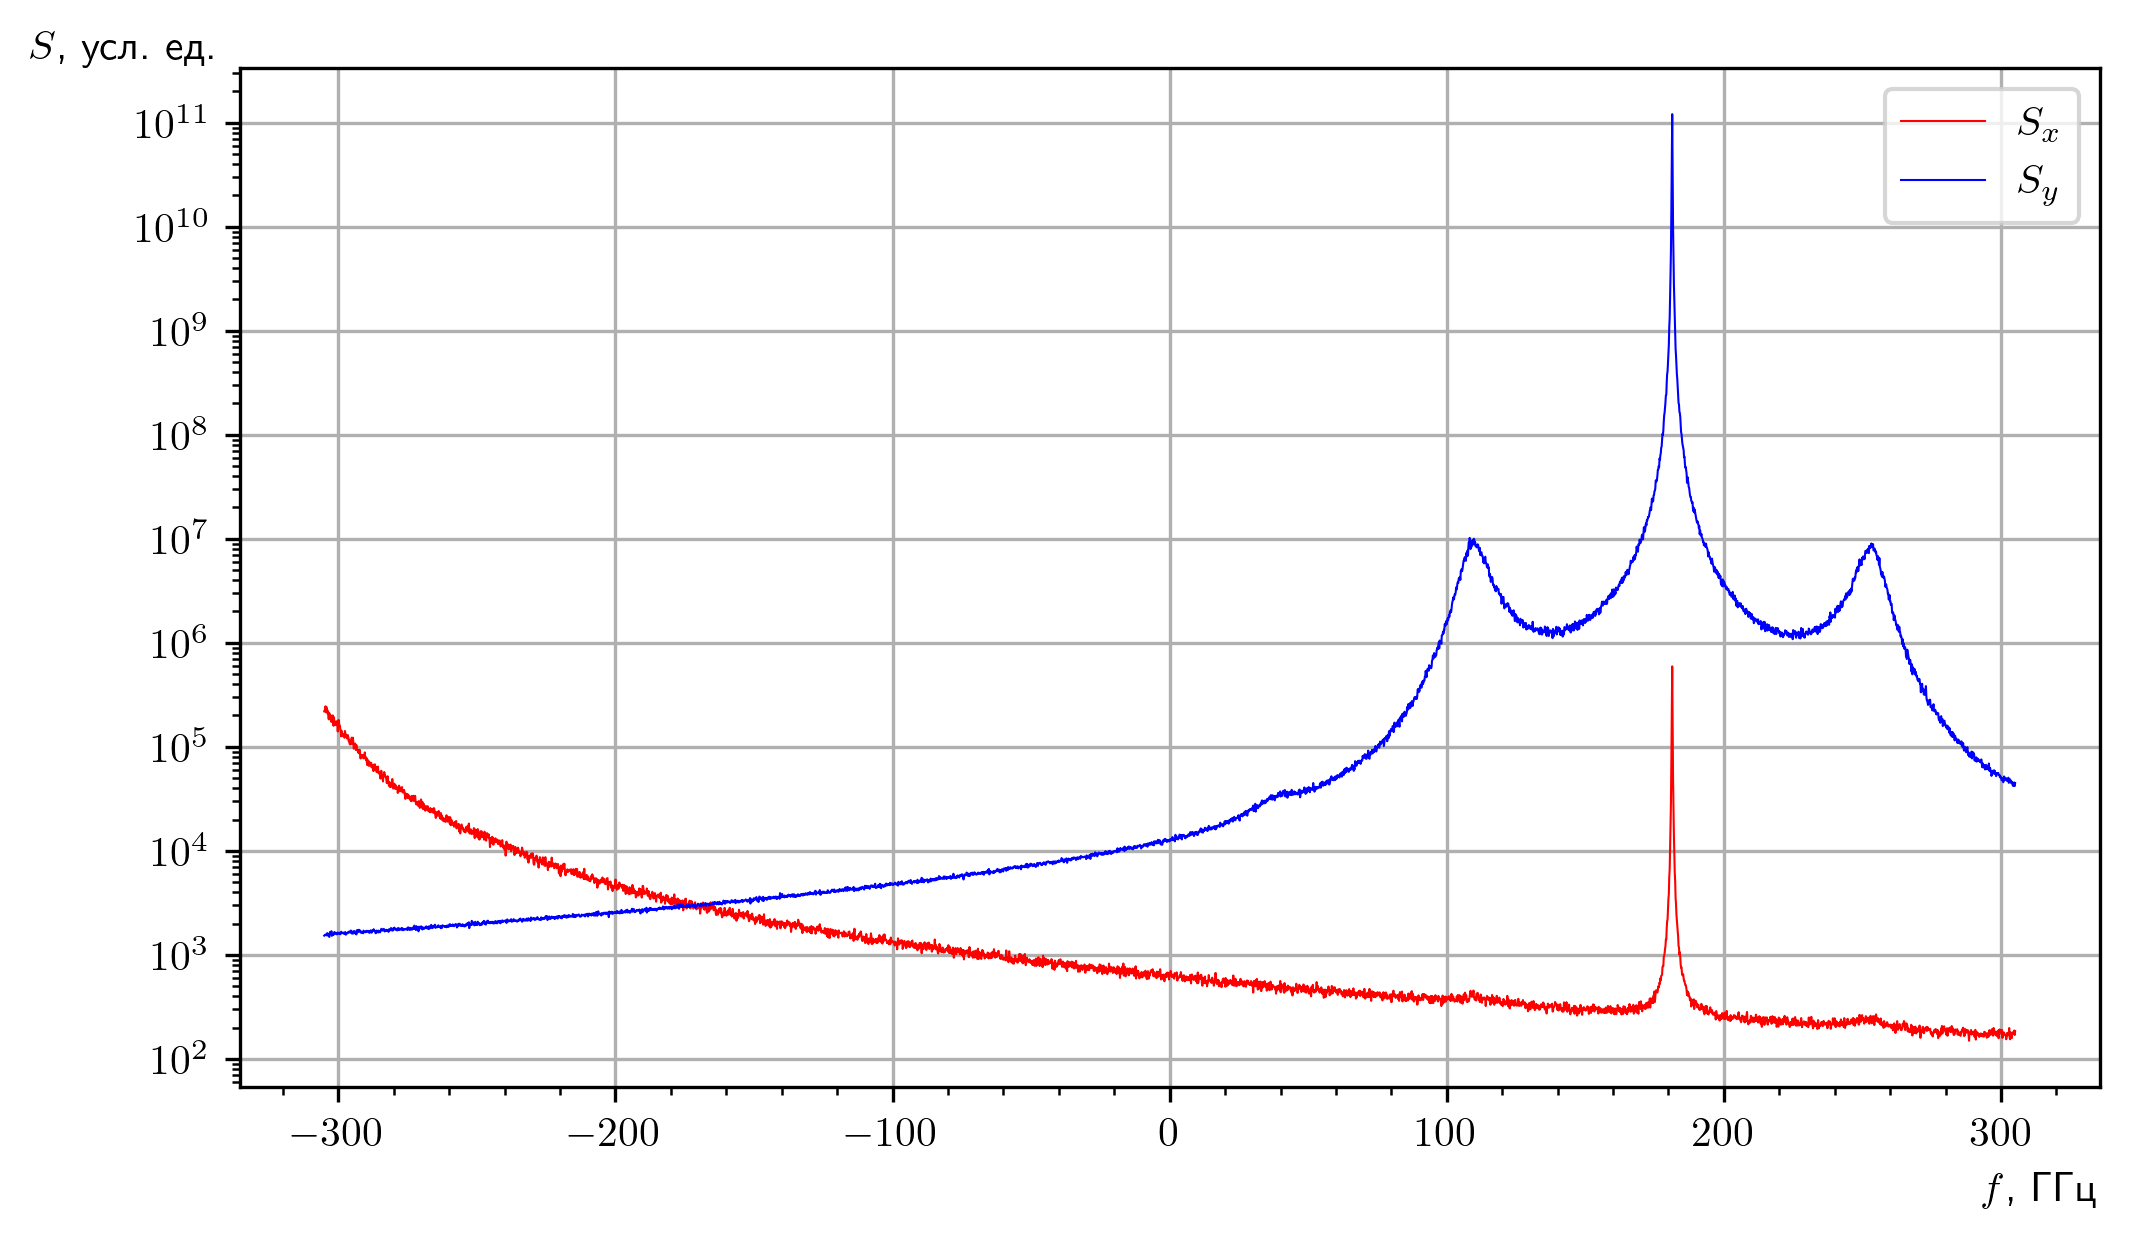

In [9]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\fit450'

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params450);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged


np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 6000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

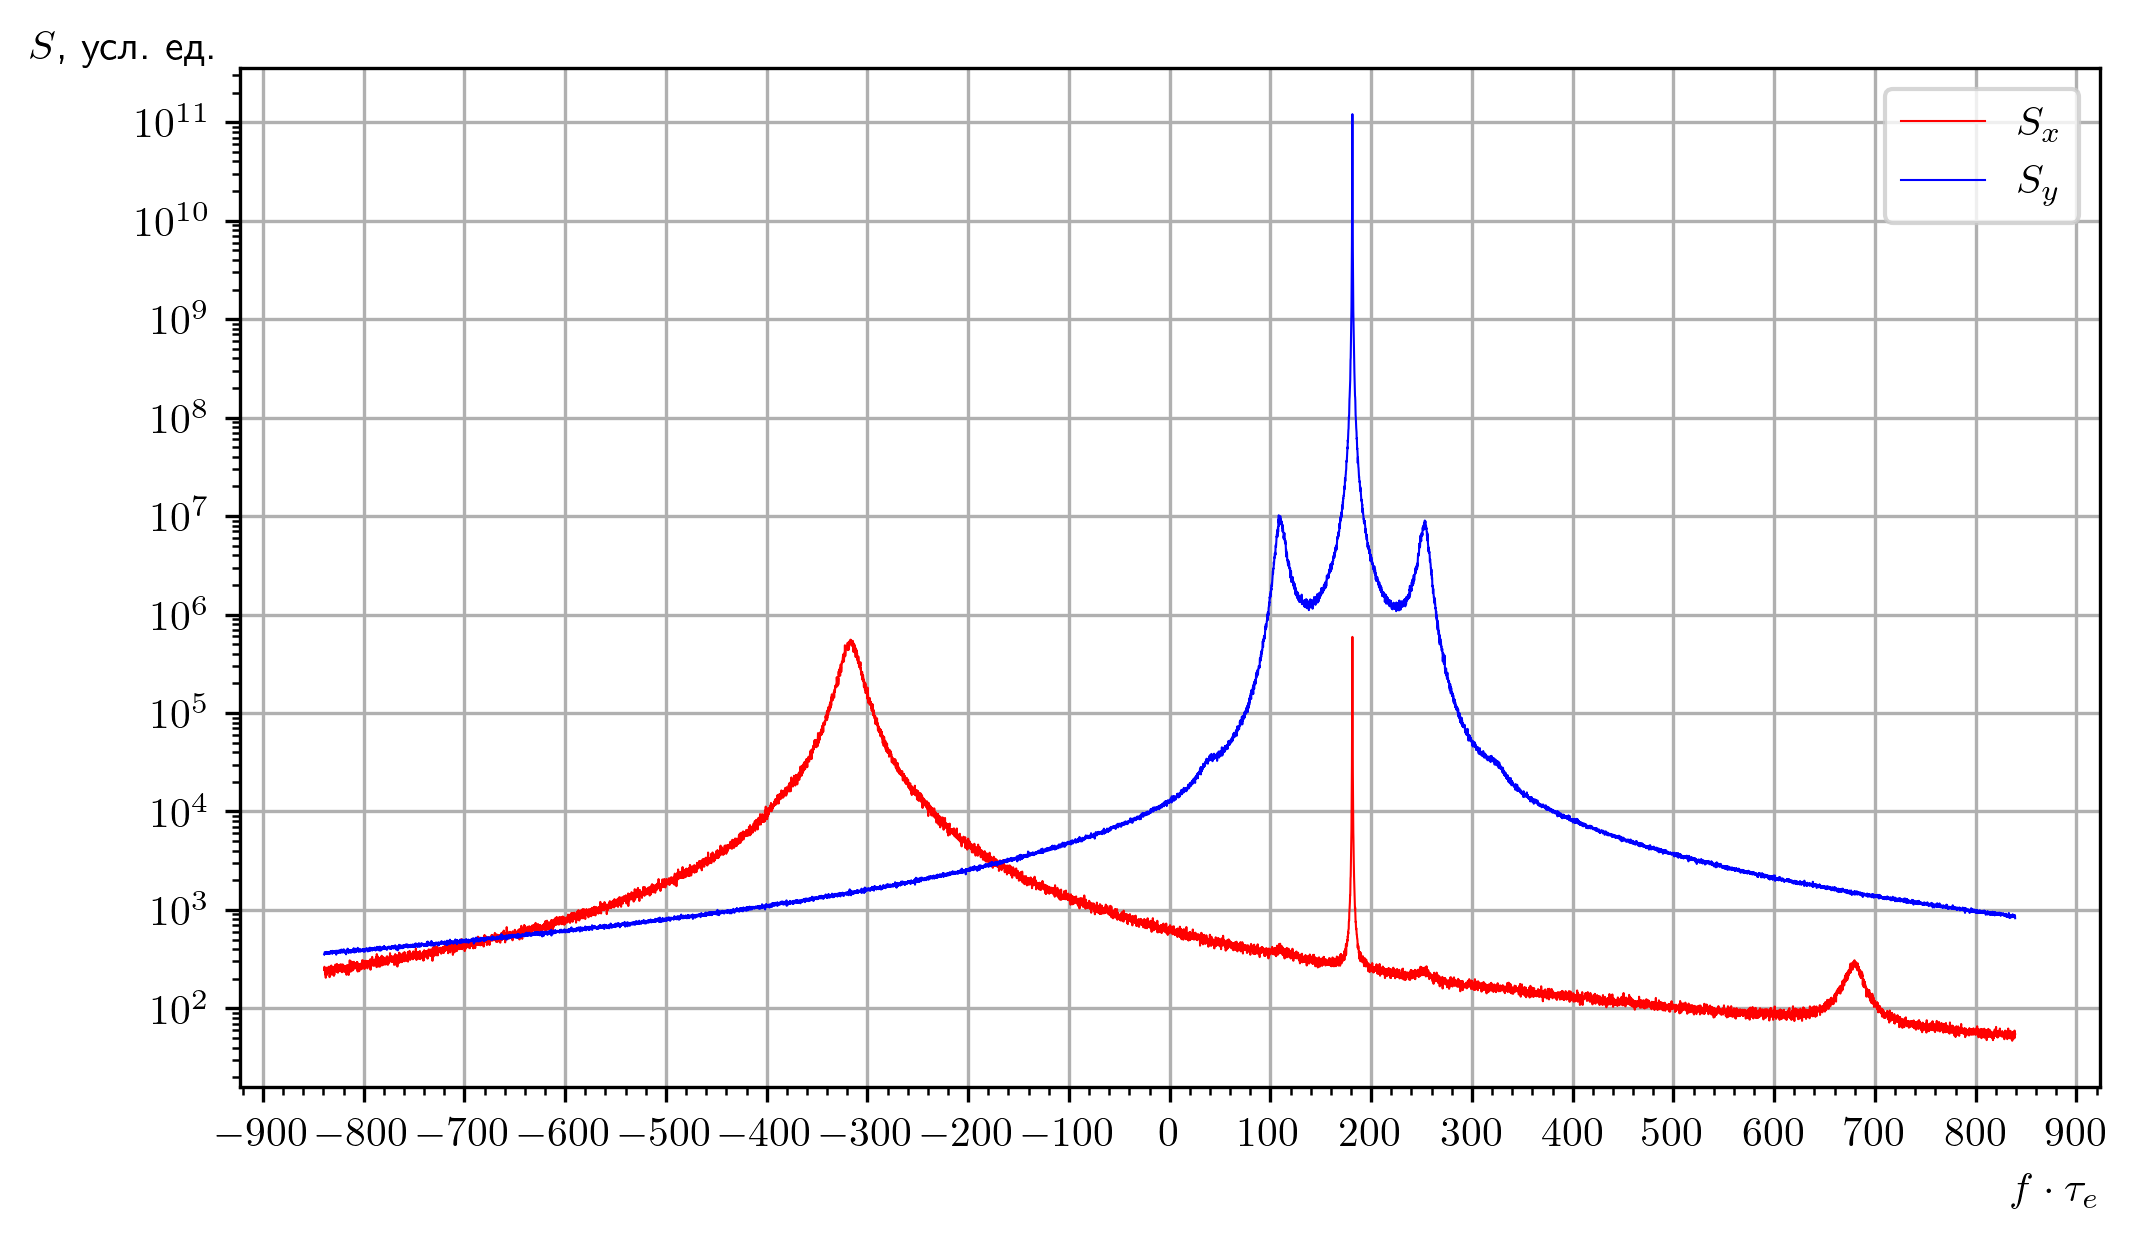

In [13]:
WW = 5500
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

-2
Wall time: 7min 7s


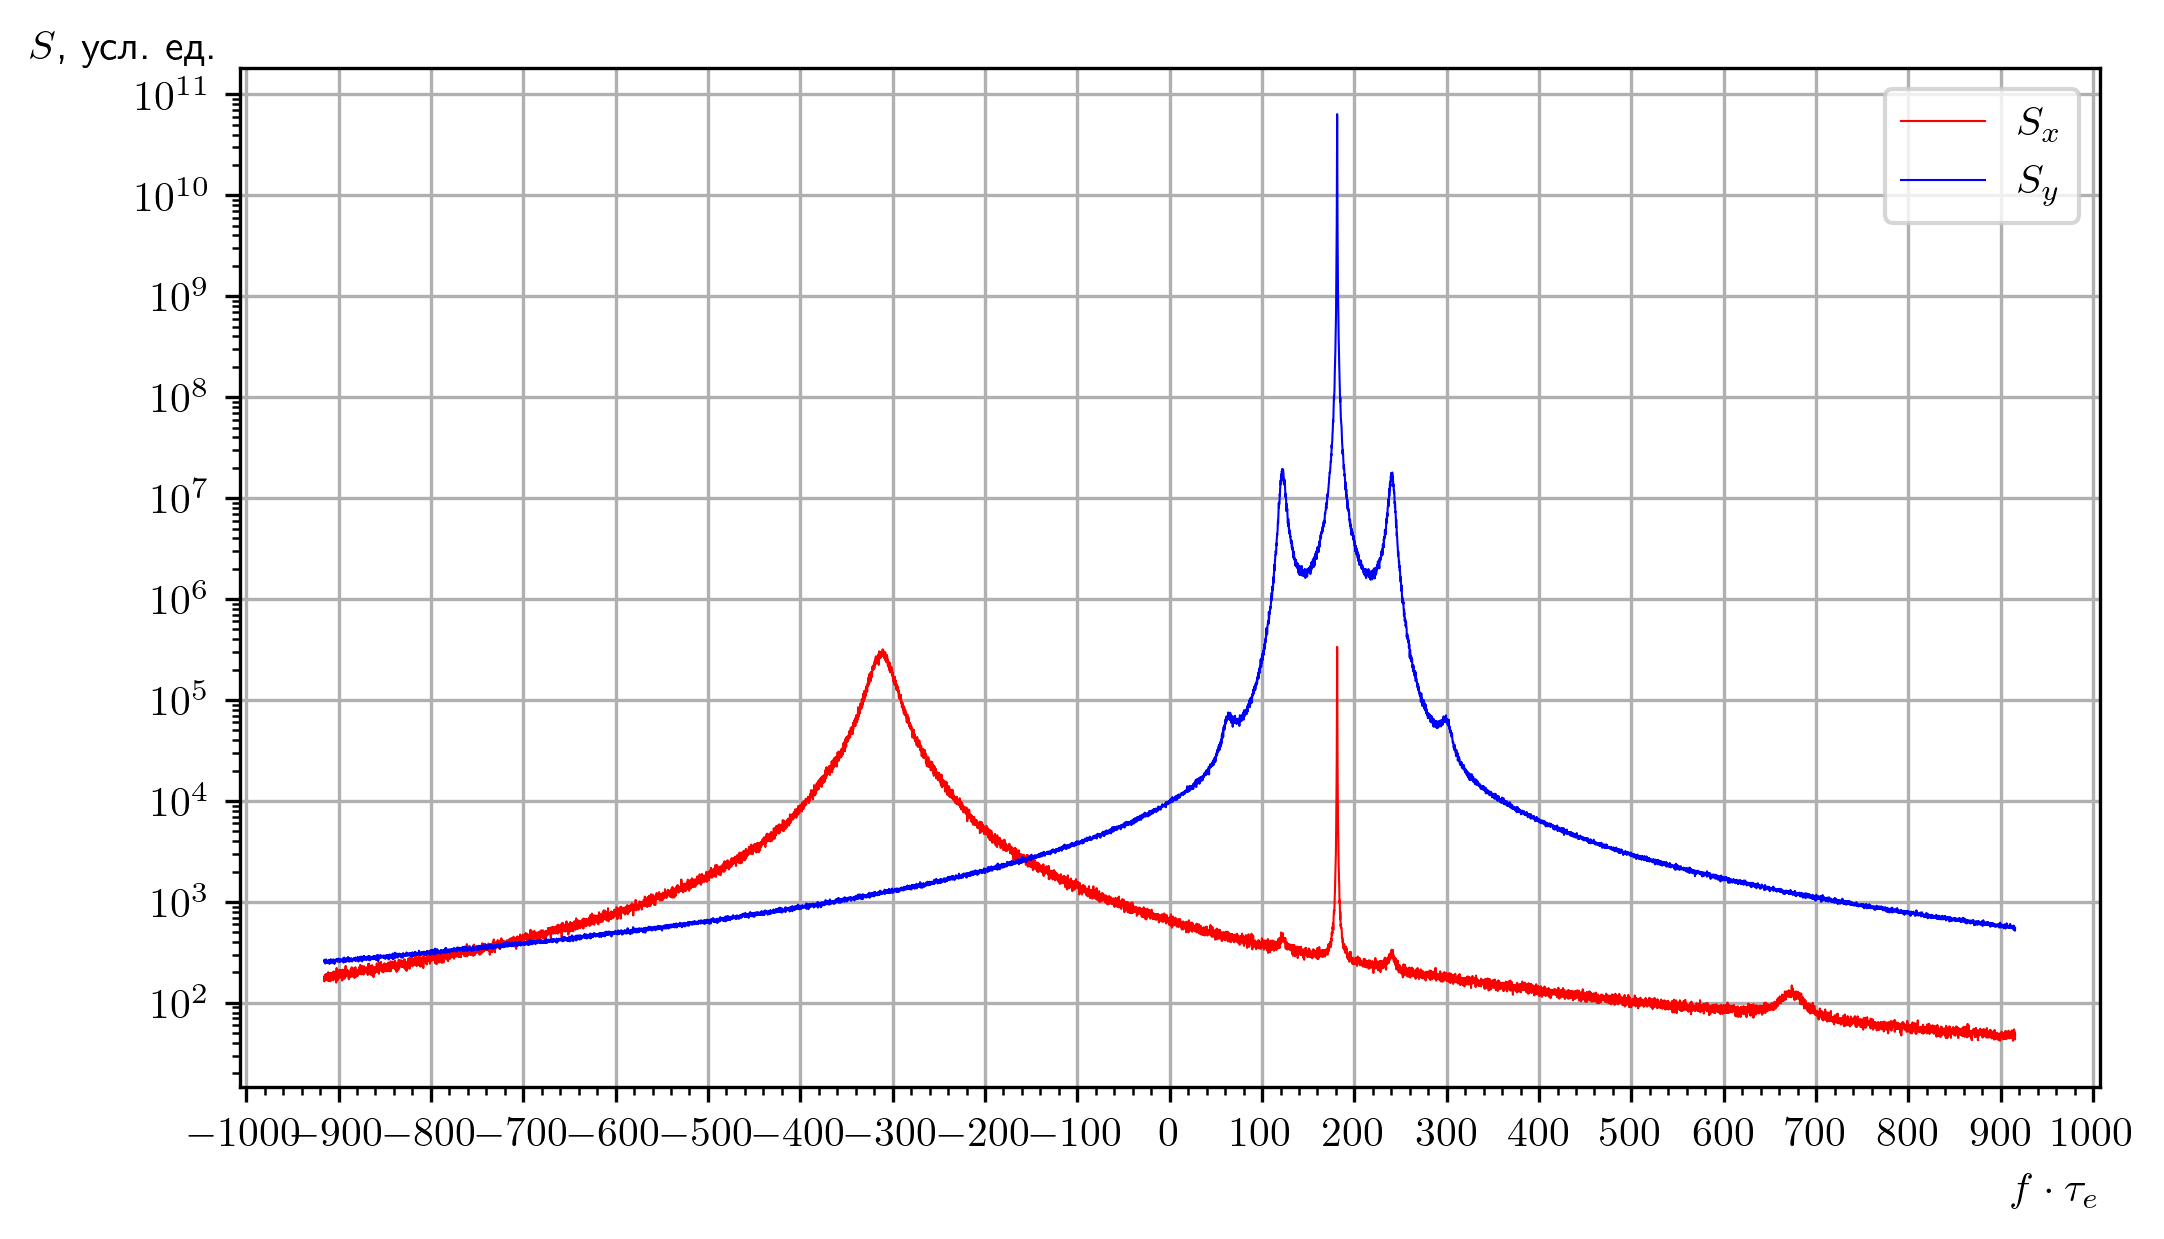

In [42]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\fit345'

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params345);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged


np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 6000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

105
-2
Wall time: 7min 55s


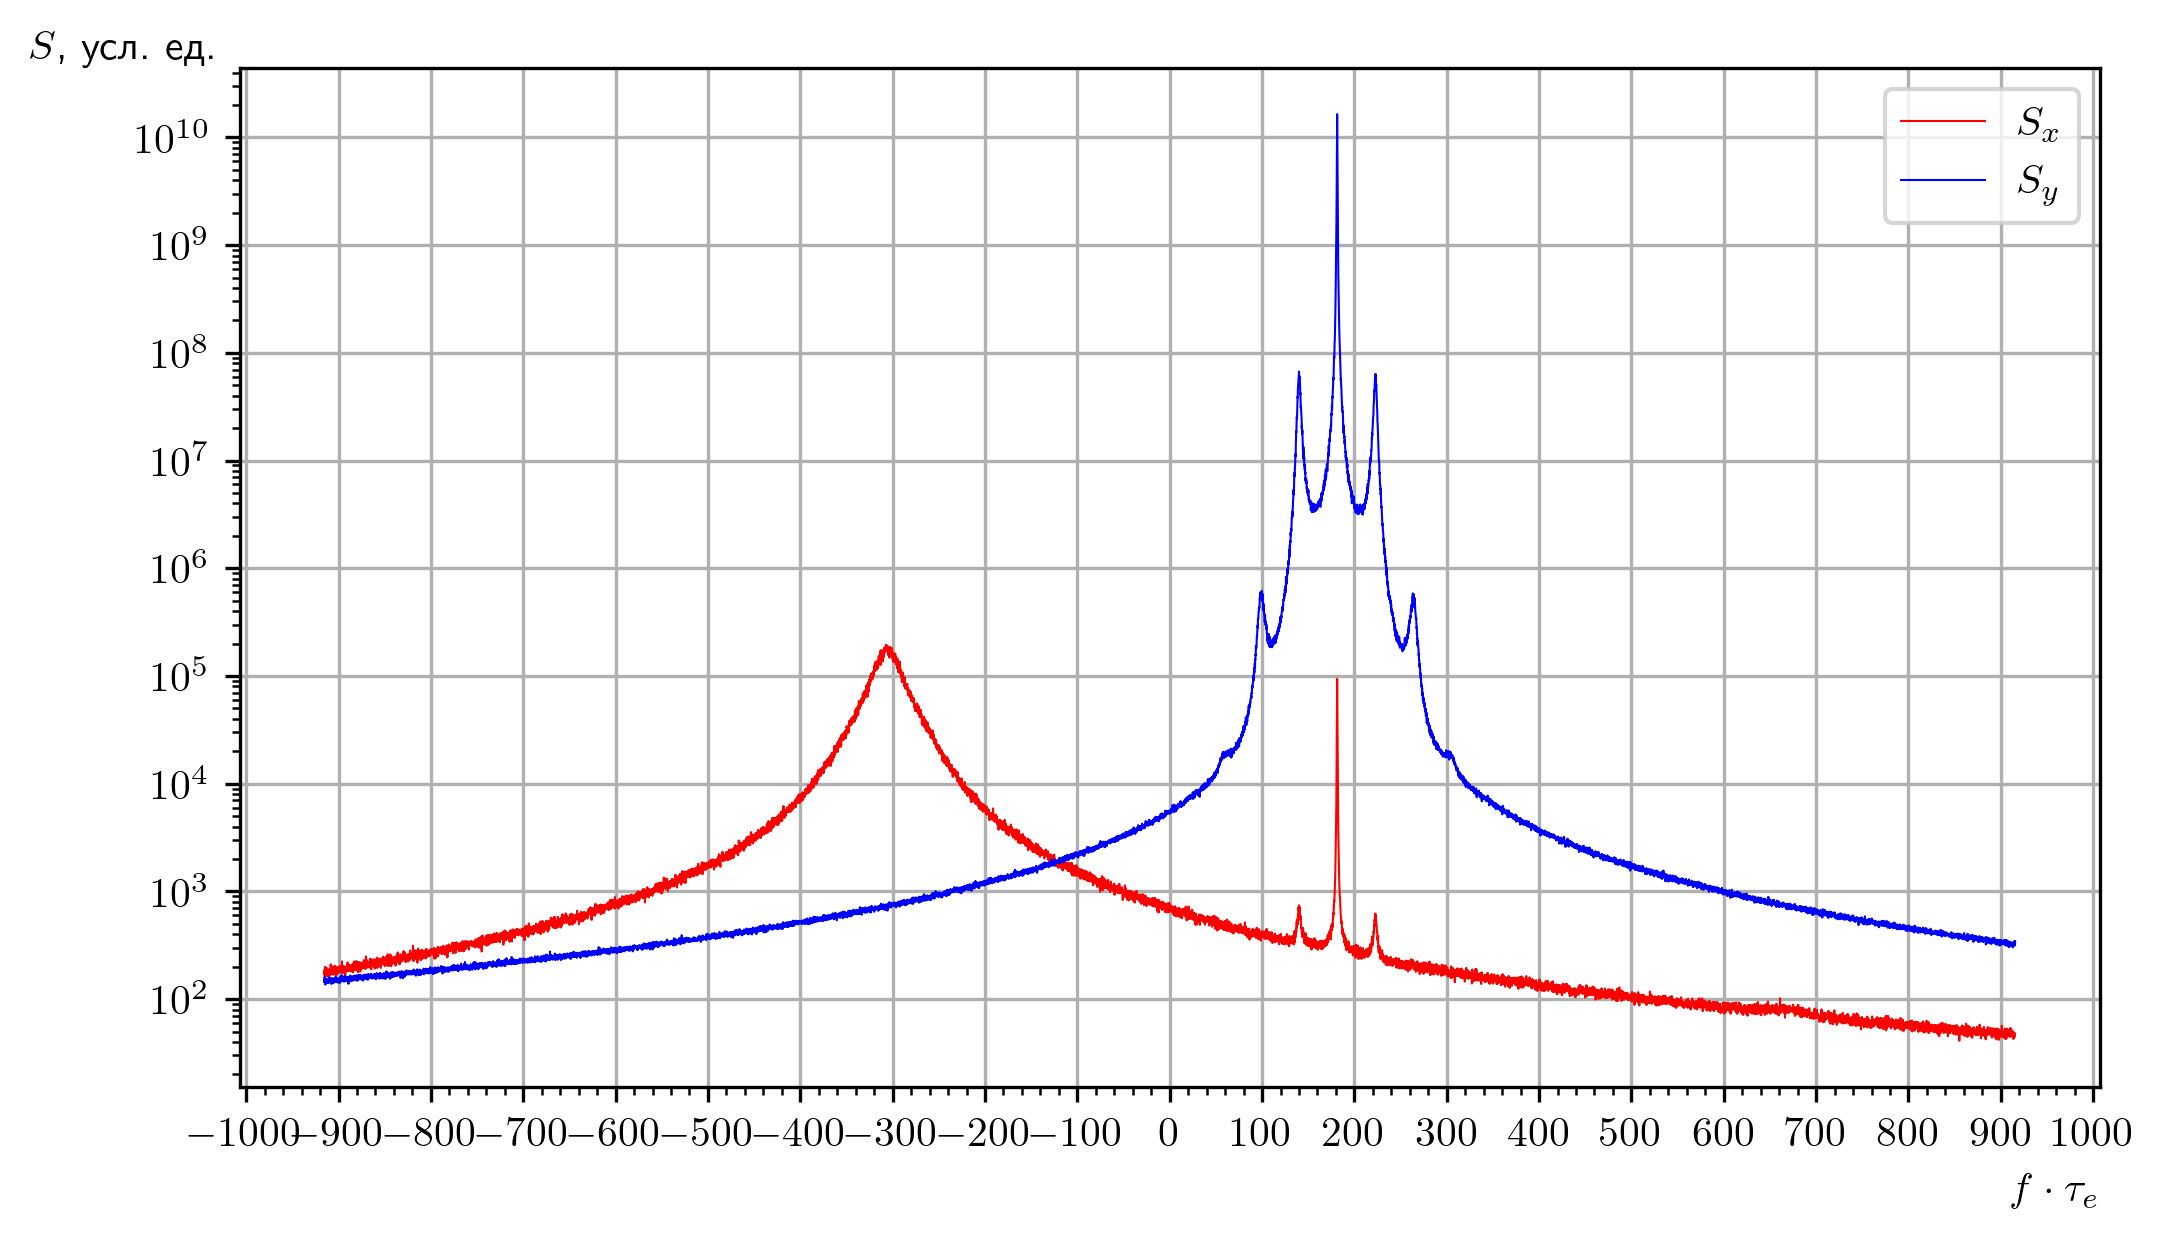

In [43]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\fit233'

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params233);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged


np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 6000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')

In [62]:
def residual(params, freqsdatax, freqsdatay, datax, datay, freqsspec, specx, specy):
    # data MUST be provided in logarithmic10 scale
    # specs - in linear
    parvals = params.valuesdict()
    ext_f0 = parvals['f0']
    ext_gamma = parvals['gamma']
    ext_gain = parvals['gain']
    ext_sigma = parvals['sigma']
    fstep = freqsspec[1] - freqsspec[0]
    # spxgauss = sp.interpolate.interp1d(ext_gamma*self.freqs + ext_f0, np.log10(sp.ndimage.gaussian_filter1d(self.spx, ext_sigma / self.fstep / ext_gamma, mode="constant", cval=0.0)))
    # spygauss = sp.interpolate.interp1d(ext_gamma*self.freqs + ext_f0, np.log10(sp.ndimage.gaussian_filter1d(self.spy, ext_sigma / self.fstep / ext_gamma, mode="constant", cval=0.0)))
    # errx = datax - ext_gain - spxgauss(frequencies)
    # erry = datay - ext_gain - spygauss(frequencies)

    # linear
    spxgauss = sp.interpolate.interp1d(ext_gamma*freqsspec + ext_f0, sp.ndimage.gaussian_filter1d(specx*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0))
    spygauss = sp.interpolate.interp1d(ext_gamma*freqsspec + ext_f0, sp.ndimage.gaussian_filter1d(specy*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0))
    errx = 10**datax - spxgauss(freqsdatax)
    erry = 10**datay - spygauss(freqsdatay)
    return np.reshape(np.concatenate([errx, erry]), -1)

def fit_transform(freqsdatax, datax, datay, freqsspec, specx, specy, freqsdatay=None, gamma=None, gain=None, sigma=None):
    if freqsdatay is None:
        freqsdatay = freqsdatax
    mfdx = freqsdatax[np.argmax(datax)]
    mfdy = freqsdatay[np.argmax(datay)]
    mfx = freqsspec[np.argmax(specx)]
    mfy = freqsspec[np.argmax(specy)]
    deltaf = max(np.max(freqsdatax), np.max(freqsdatay)) - min(np.min(freqsdatax), np.min(freqsdatay))
    if abs(mfx - mfy) < 1e-4:
        # TODO : get other maxima
        mfx = freqsspec[np.argmax(specx[0:int(specx.shape[0]/2)])]
        if abs(mfx - mfy) < 1e-4:
            print(mfx)
            print(mfy)
            return True
    parameters = lmfit.create_params(gamma={}, f0={}, gain={}, sigma={})
    if gamma is None:
        parameters['gamma'].set( (mfdy - mfdx) / (mfy - mfx), min=0.0, vary=True )
        if (mfdy - mfdx) / (mfy - mfx) < 0.01:
            return True
    else:
        parameters['gamma'].set( gamma, vary=False)
    f0 = (mfy*mfdx - mfdy*mfx) / (mfy - mfx)
    parameters['f0'].set( value=f0, min=f0-deltaf/4, max=f0+deltaf/4, vary=True )
    if gain is None:
        parameters['gain'].set( (np.max(datax) - np.log10(np.max(specx)) + np.max(datay) - np.log10(np.max(specy))) / 2, vary=True )
    else:
        parameters['gain'].set( gain, vary=False )
    if sigma is None:
        parameters['sigma'].set( 0.9, min=0.0, vary=True )
    else:
        parameters['sigma'].set( sigma , min=0.0, vary=False )
    return lmfit.minimize(residual, parameters, method="leqst_sq", kws={"freqsdatax":freqsdatax, "datax":datax, 
                                                                        "freqsdatay":freqsdatay, "datay":datay, 
                                                                        "freqsspec":freqsspec, "specx":specx, "specy":specy})

def transform(params, freqsspec, specx, specy):
    parvals = params.valuesdict()
    ext_f0 = parvals['f0']
    ext_gamma = parvals['gamma']
    ext_gain = parvals['gain']
    ext_sigma = parvals['sigma']
    return [ext_gamma*freqsspec + ext_f0, 
            sp.ndimage.gaussian_filter1d(specx*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0),
            sp.ndimage.gaussian_filter1d(specy*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0)]


import pandas as pd
def read_spectrum_csv(path):
    with open(path, 'r') as file:
        next(file)
        next(file)
        start = int(next(file))
        file.close()
        return pd.read_csv(path, skiprows=start+4, names=["Frequency", "Level"], usecols=[0,1]).to_numpy()

In [55]:
data450X = read_spectrum_csv("../Experiments/25.05.23/X450mA.CSV")
data450Y = read_spectrum_csv("../Experiments/25.05.23/Y450mA.CSV")
freqs450x = data450X[:,0] * 1000
spec450x = data450X[:,1] / 10
freqs450y = data450Y[:,0] * 1000
spec450y = data450Y[:,1] / 10
spdata450 = np.loadtxt("include_in_dip/fit450.txt")
spf450 = spdata450[:,0]
spx450 = spdata450[:,1]
spy450 = spdata450[:,2]

data345X = read_spectrum_csv("../Experiments/25.05.23/X346mA.CSV")
data345Y = read_spectrum_csv("../Experiments/25.05.23/Y346mA.CSV")
freqs345x = data345X[:,0] * 1000
spec345x = data345X[:,1] / 10
freqs345y = data345Y[:,0] * 1000
spec345y = data345Y[:,1] / 10
spdata345 = np.loadtxt("include_in_dip/fit345.txt")
spf345 = spdata345[:,0]
spx345 = spdata345[:,1]
spy345 = spdata345[:,2]

data233X = read_spectrum_csv("../Experiments/25.05.23/X233mA.CSV")
data233Y = read_spectrum_csv("../Experiments/25.05.23/Y233mA.CSV")
freqs233x = data233X[:,0] * 1000
spec233x = data233X[:,1] / 10
freqs233y = data233Y[:,0] * 1000
spec233y = data233Y[:,1] / 10
spdata233 = np.loadtxt("include_in_dip/fit233.txt")
spf233 = spdata233[:,0]
spx233 = spdata233[:,1]
spy233 = spdata233[:,2]

In [72]:
res450 = fit_transform(freqs450y, spec450y, spec450x, spf450, spx450, spy450, freqsdatay=freqs450x)
res345 = fit_transform(freqs345y, spec345y, spec345x, spf345, spx345, spy345, freqsdatay=freqs345x)
res233 = fit_transform(freqs233y, spec233y, spec233x, spf233, spx233, spy233, freqsdatay=freqs233x)

In [76]:
gamma = (res450.params['gamma'].value + res450.params['gamma'].value + res450.params['gamma'].value) / 3
sigma = (res345.params['sigma'].value + res345.params['sigma'].value + res345.params['sigma'].value) / 3
gain = (res233.params['gain'].value + res233.params['gain'].value + res233.params['gain'].value) / 3

In [77]:
print("{}, {}, {}".format(gamma, sigma, gain))

0.03876086820039082, 0.9056679615436604, -9.506467294727079


In [78]:
res450 = fit_transform(freqs450y, spec450y, spec450x, spf450, spx450, spy450, freqsdatay=freqs450x, gamma=gamma, sigma=sigma, gain=gain)
res345 = fit_transform(freqs345y, spec345y, spec345x, spf345, spx345, spy345, freqsdatay=freqs345x, gamma=gamma, sigma=sigma, gain=gain)
res233 = fit_transform(freqs233y, spec233y, spec233x, spf233, spx233, spy233, freqsdatay=freqs233x, gamma=gamma, sigma=sigma, gain=gain)

In [79]:
spf450_fit, spx450_fit, spy450_fit = transform(res450.params, spf450, spx450, spy450)
spf345_fit, spx345_fit, spy345_fit = transform(res345.params, spf345, spx345, spy345)
spf233_fit, spx233_fit, spy233_fit = transform(res233.params, spf233, spx233, spy233)

C:\Users\dedko\AppData\Local\Temp/ipykernel_12260/4221993575.py:30: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  wnd = np.arange(freqs.shape[0], dtype=np.integer)
C:\Users\dedko\AppData\Local\Temp/ipykernel_12260/4221993575.py:35: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  wnd = np.arange(wndmin, wndmax, dtype=np.integer)
C:\Users\dedko\AppData\Local\Temp/ipykernel_12260/4221993575.py:30: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)

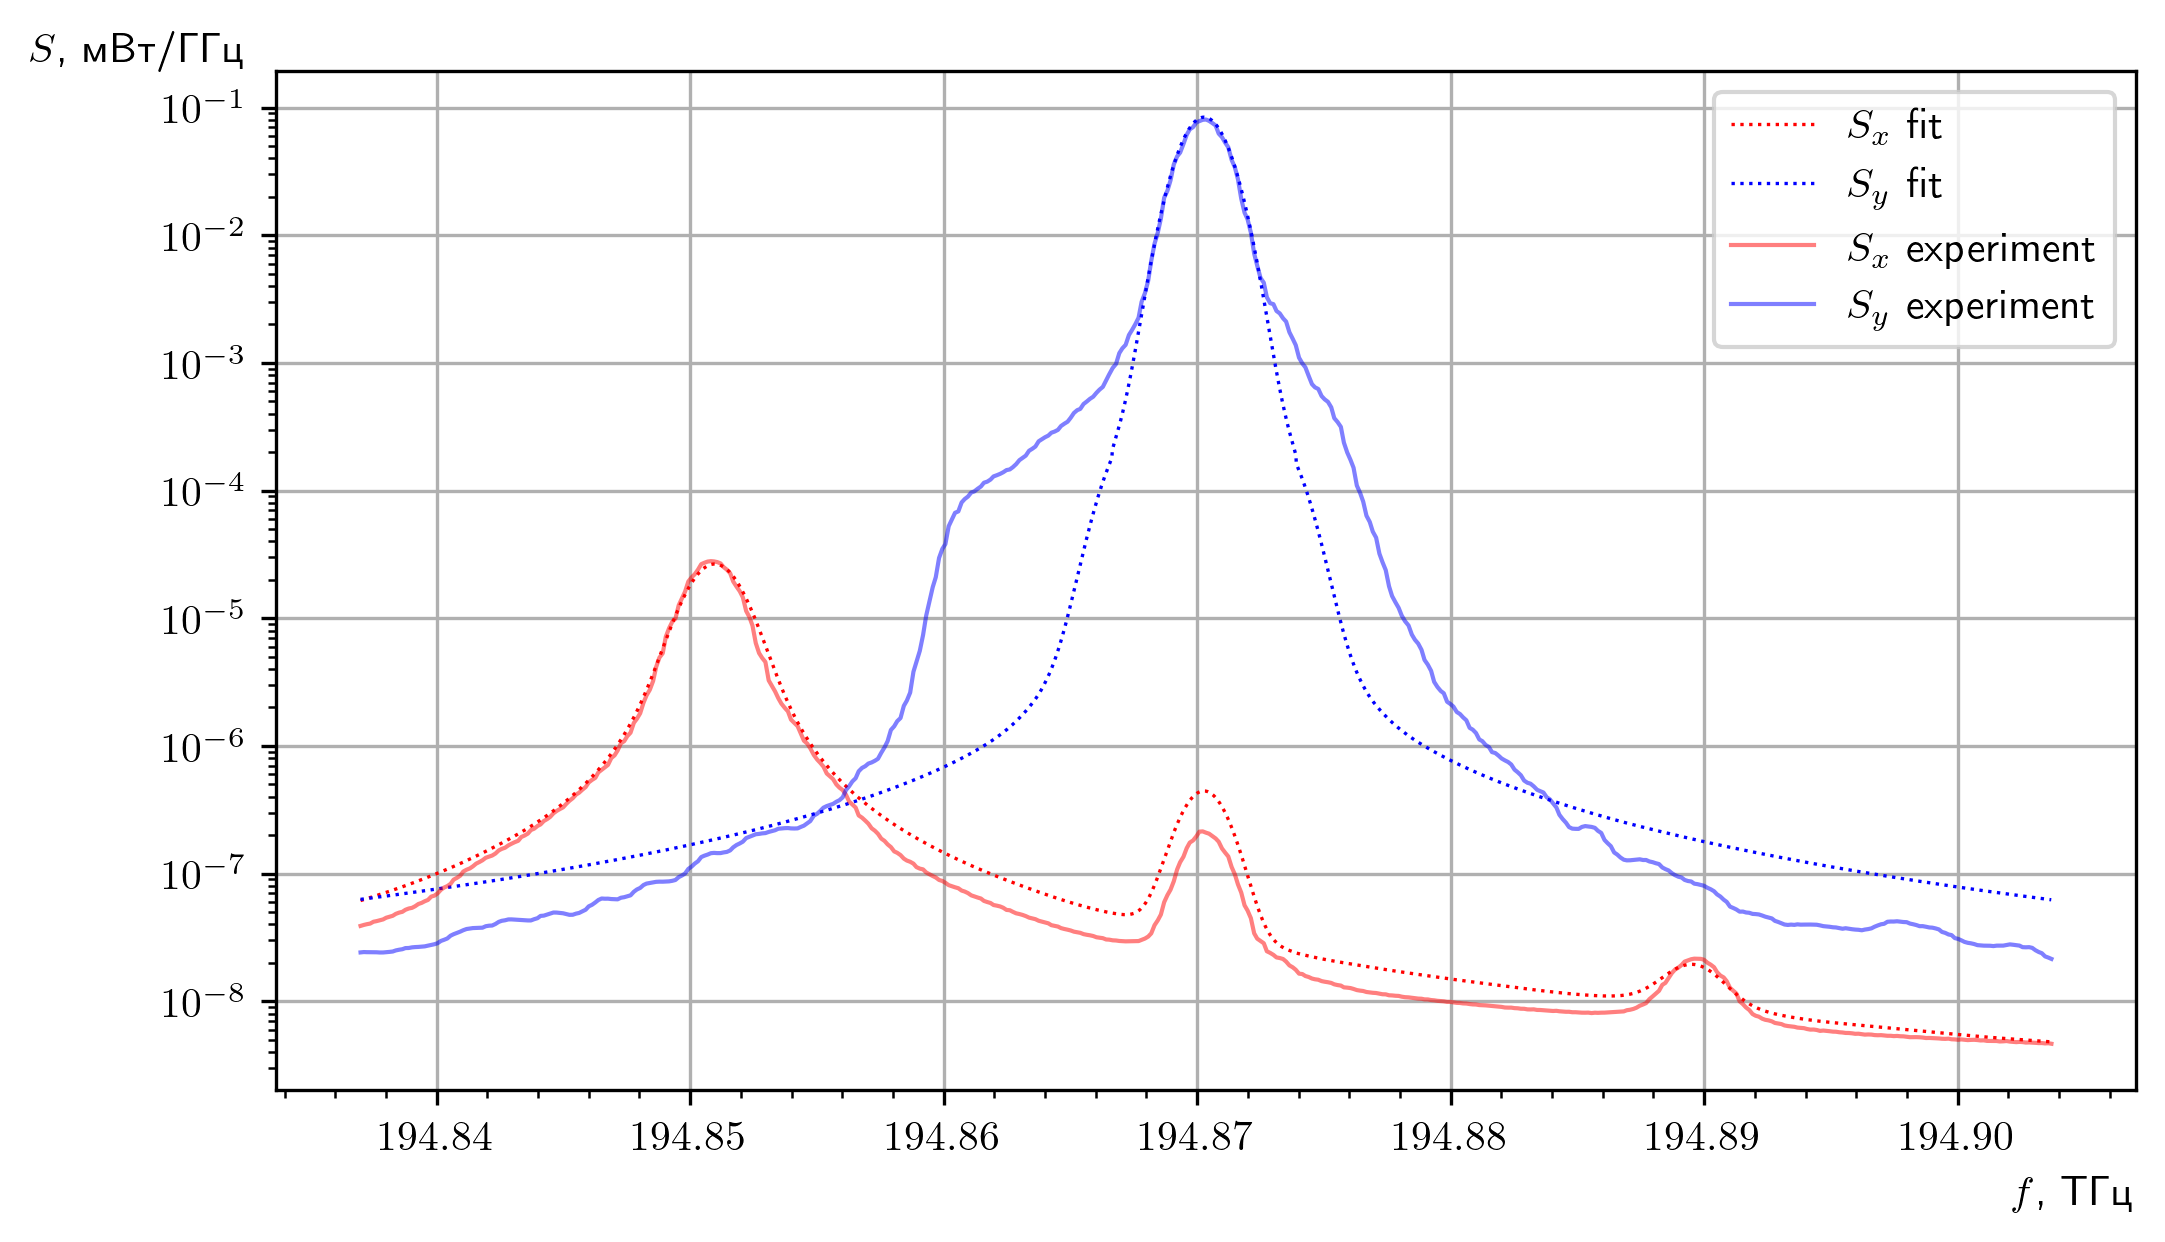

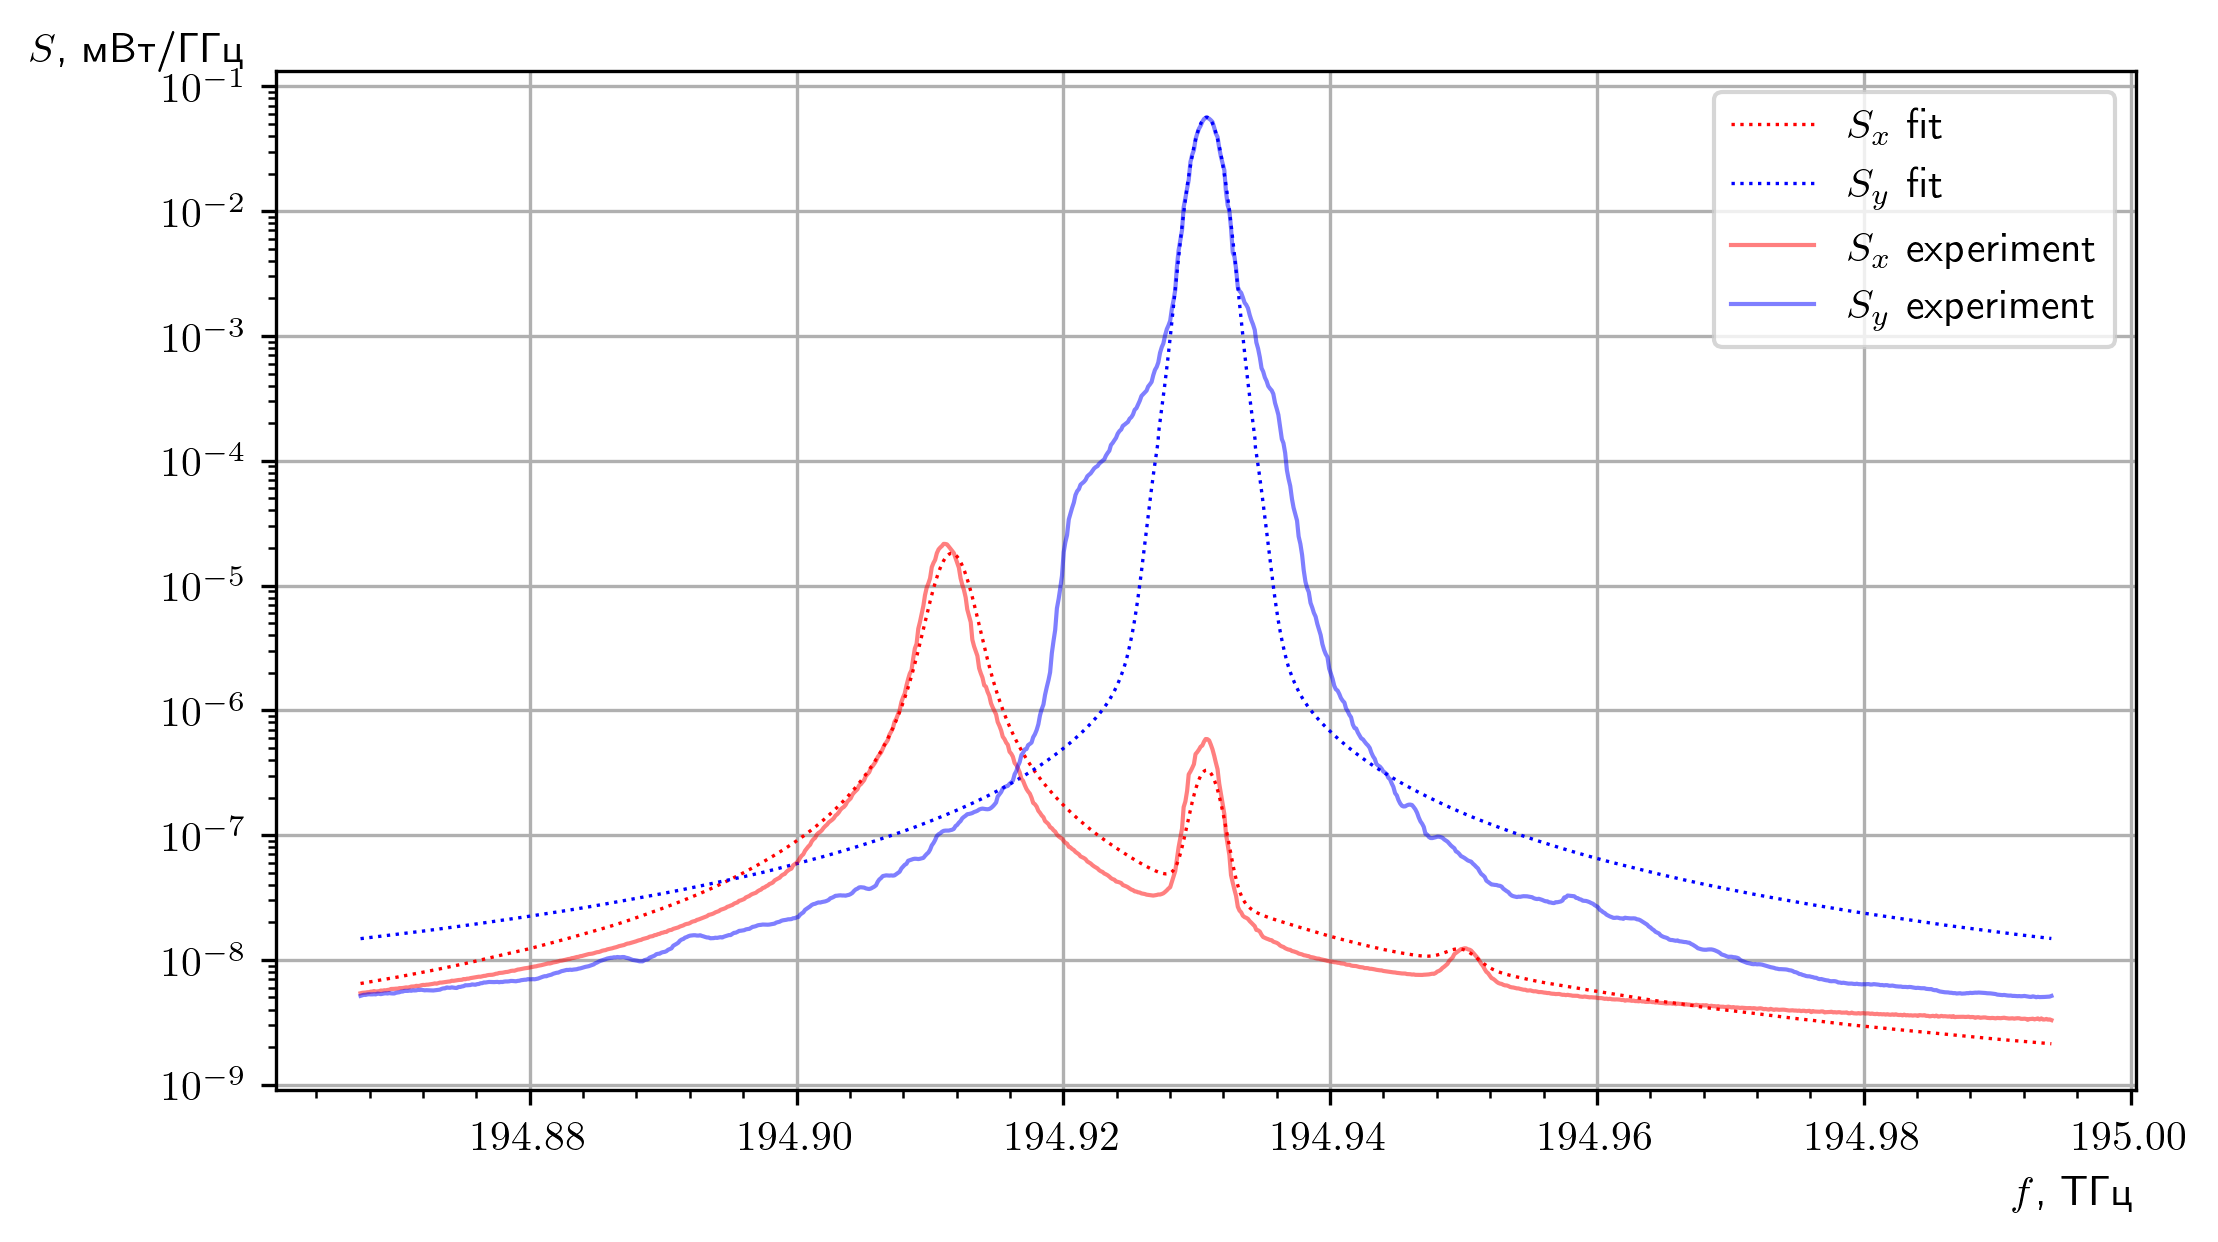

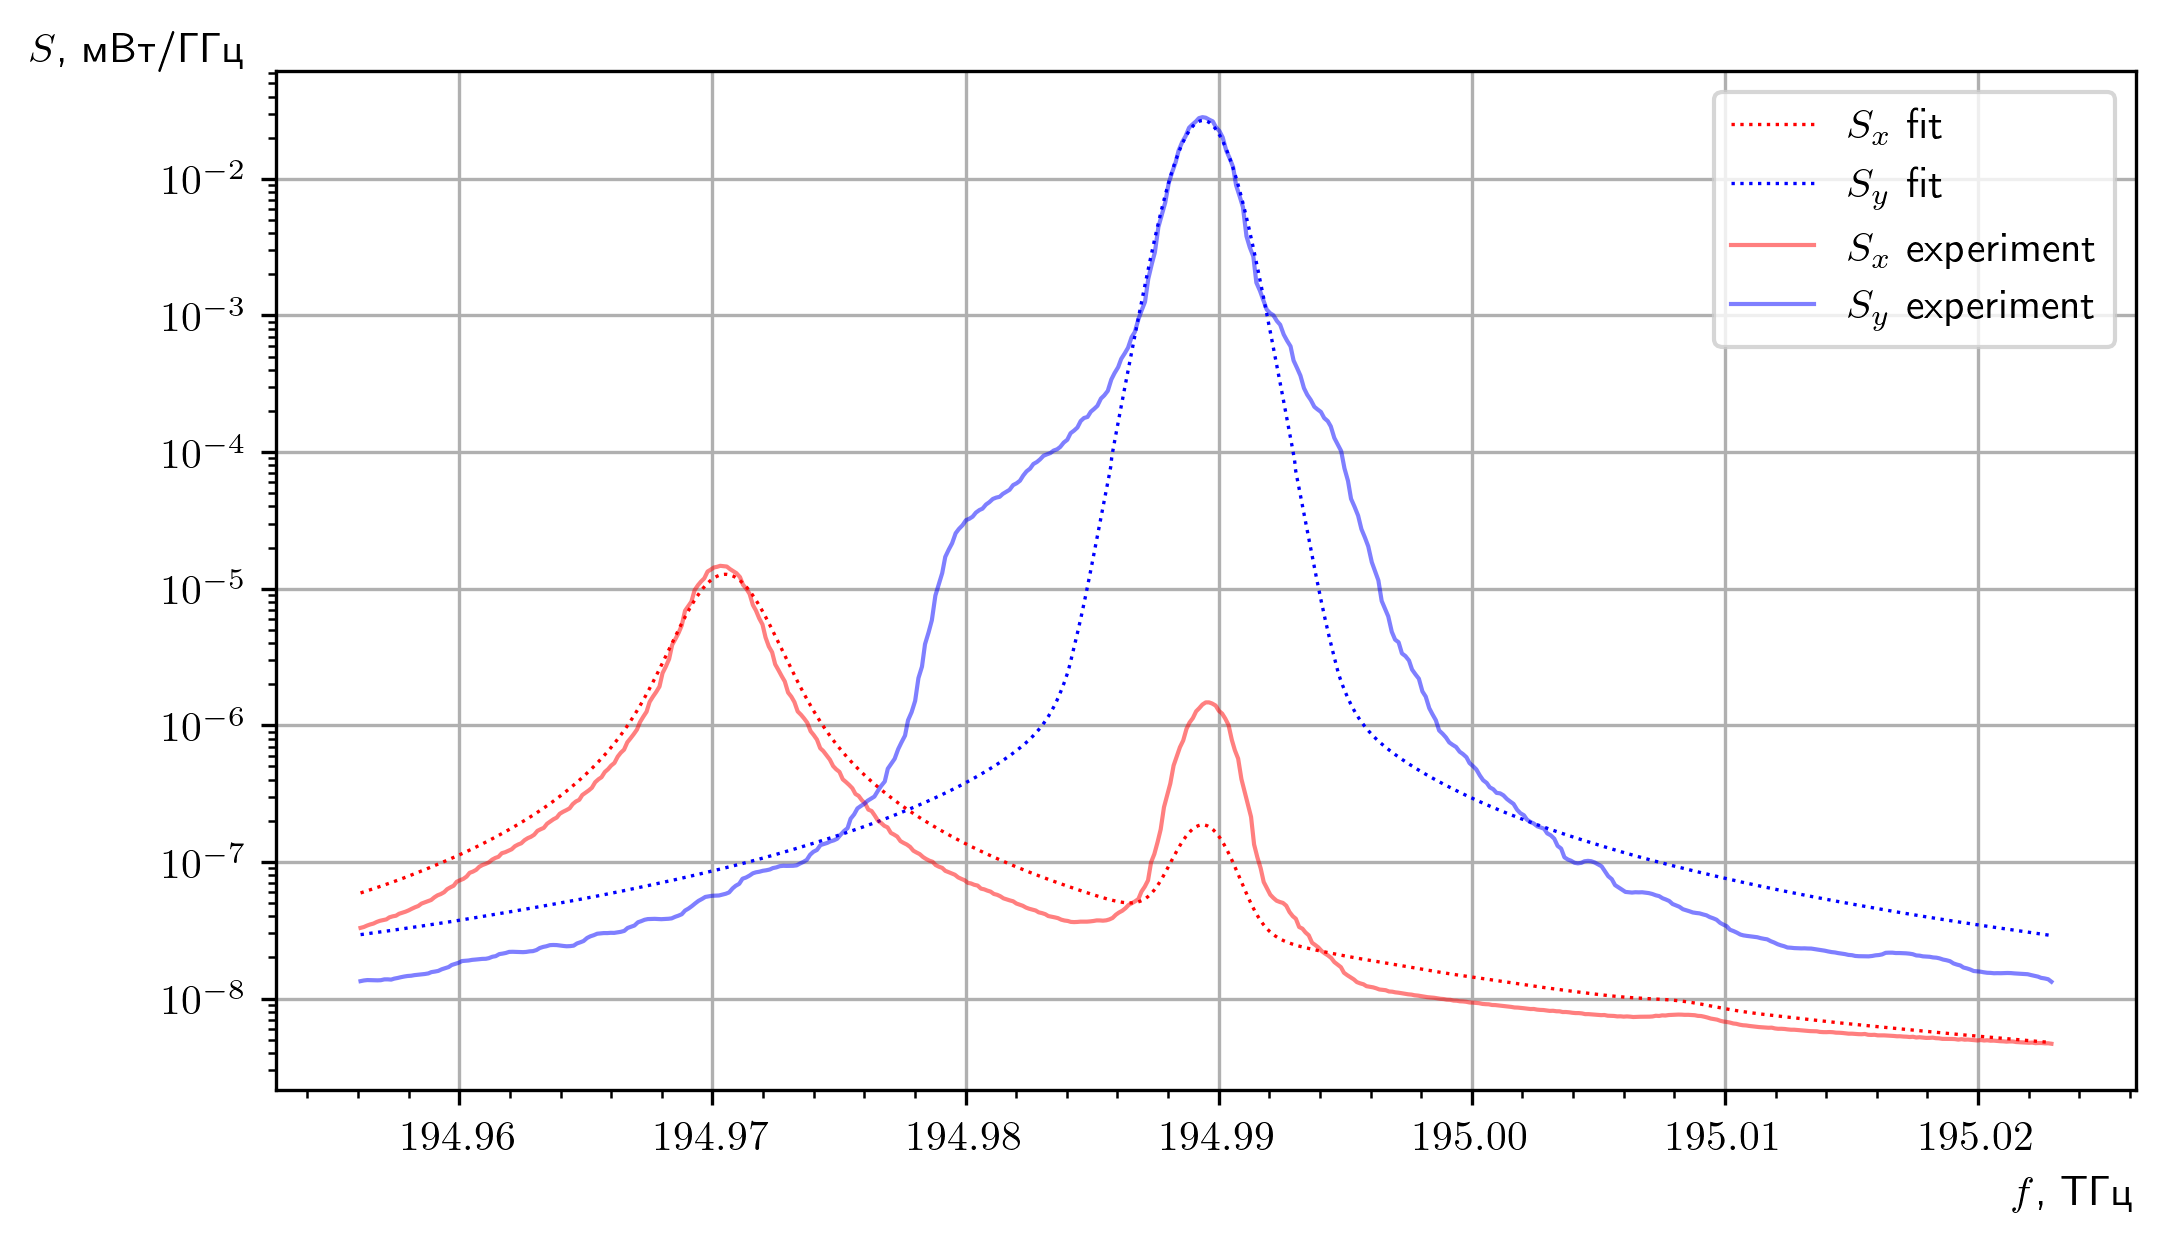

In [117]:
plot_specs_fit(spf450_fit, spx450_fit, spy450_fit, freqs450y, 10**spec450y, freqs450x, 10**spec450x, fout="include_in_dip/fit450.pdf")
plot_specs_fit(spf345_fit, spx345_fit, spy345_fit, freqs345y, 10**spec345y, freqs345x, 10**spec345x, fout="include_in_dip/fit345.pdf", majorx=20)
plot_specs_fit(spf233_fit, spx233_fit, spy233_fit, freqs233y, 10**spec233y, freqs233x, 10**spec233x, fout="include_in_dip/fit233.pdf")

In [157]:
1/gamma

25.799215714933784

In [156]:
sigma

0.9056679615436604

In [ ]:
# free all memory
lib.free_complex_array(Ex)
lib.free_complex_array(Ey)
lib.free_complex_array(tmpEx)
lib.free_complex_array(tmpEy)
lib.free_complex_array(twist)
lib.free_array(specx)
lib.free_array(specy)
lib.free_uint_array(bitrev)